In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import os
from scipy.stats import pearsonr, spearmanr, fisher_exact, mannwhitneyu, ttest_ind

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

from matplotlib.pyplot import rc_context
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.cm as cm

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
sys.path.append('../../Code/')
from utils import read_dataset_log
import pickle as pkl
import matplotlib.gridspec as gridspec

In [2]:
from matplotlib import rcParams, font_manager
import matplotlib


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
label_fontsize = 10
tick_fontsize = 8

In [3]:
figdir = '../../Figures/Components'

In [4]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label,tcat_fn_old
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCA

In [5]:
gep_info = read_dataset_log('cGEP_Name')
rename_map = dict(zip(gep_info['cGep_Name'], gep_info['Short_Name']))

In [88]:
lineage_geps = gep_info[gep_info['Class']=='Lineage']['Short_Name'].tolist()

In [89]:
lineage_geps

['CD8-EM',
 'MAIT',
 'Treg',
 'CD4-Naive',
 'TEMRA',
 'CD4-CM',
 'gdT',
 'Th22',
 'Th17-Resting',
 'Th2-Resting',
 'Th1-Like',
 'CD8-Naive',
 'CD8-Trm',
 'Tfh-2',
 'Tph',
 'Tfh-1']

In [6]:
geps = ['Th1-Like', 'Treg', 'Th2-Resting', 'Th17-Resting', 'Th22', 'Th2-Activated', 'Th17-Activated']


In [7]:
gep_paths = read_dataset_log('cGEP Paths')
Z_spec = pd.read_csv(gep_paths['scores_spectra'][0], index_col = 0, sep = '\t')
Z_spec.index = Z_spec.index.map(rename_map)

In [8]:
top_markers = {}
marker_genes = []
for g in geps:
    marker_genes += list(Z_spec.loc[g, :].sort_values(ascending = False).head(50).index)
    top_markers[g] = list(Z_spec.loc[g, :].sort_values(ascending = False).head(50).index)
    
marker_genes += ['TBX21', 'FOXP3', 'GATA3', 'RORC', 'CCR4', 'CCR6', 'CXCR3', 
                'AHR', 'IL4', 'IL5', 'IL13', 'IL17A', 'IL17F', 'IFNG']

marker_genes = sorted(set(marker_genes))

In [9]:
marker_adts = ['AB_CD194', 'AB_CD195', 'AB_CD4', 'AB_CD8']

# COMBAT

In [15]:
# marker_adts = [
#             # Polarizations
#             'AB_CD194', 'AB_CD195', 'AB_CD4-2', 'AB_CD8',
              
#             # Cytotoxic
#             'AB_CD25', 'AB_CD39', 'AB_CD45RA', 'AB_CD45RO'
#               ]

In [ ]:
min_cells = 20

In [165]:
ms_adt_dict.values()

dict_values([['AB_CD195'], ['AB_CD194'], ['AB_CD194'], ['AB_CD25', 'AB_CD39'], ['AB_CD45RA'], ['AB_CD8', 'AB_CD45RO'], ['AB_TCR-Vd2']])

In [700]:


marker_genes = []

for vs in ms_rna_dict.values():
    marker_genes += vs

marker_genes = sorted(set(marker_genes))




marker_adts = []

for vs in ms_adt_dict.values():
    marker_adts += vs

marker_adts = sorted(set(marker_adts))

In [701]:
marker_genes, marker_adts

(['ANXA1',
  'AQP3',
  'ATP1B1',
  'B2M',
  'BTG1',
  'CCL2',
  'CCL5',
  'CCR4',
  'CCR5',
  'CCR6',
  'CD160',
  'CD2',
  'CD40LG',
  'CFH',
  'CLDND1',
  'CMC1',
  'CRTAM',
  'CST7',
  'CTLA4',
  'CXCR3',
  'CYB561',
  'DTHD1',
  'DUSP2',
  'EOMES',
  'FCGR3A',
  'FOXP3',
  'FXYD2',
  'GATA3',
  'GBP5',
  'GNLY',
  'GZMB',
  'GZMH',
  'GZMM',
  'HOPX',
  'IGFBP3',
  'IL10',
  'IL10RA',
  'IL10RB',
  'IL2',
  'IL2RA',
  'IL3',
  'IL32',
  'IL7R',
  'ITGA1',
  'ITGA4',
  'ITGAE',
  'ITM2B',
  'KIR2DL3',
  'KIR3DL2',
  'KLRC2',
  'KLRF1',
  'KLRG1',
  'LYAR',
  'LYST',
  'MS4A1',
  'MYBL1',
  'NCR1',
  'NSG1',
  'PARP8',
  'PDE4B',
  'PDE4D',
  'PERP',
  'PLCB1',
  'PRF1',
  'PTGDR2',
  'PTGER2',
  'PTPN13',
  'RORC',
  'SH2D1A',
  'STOM',
  'TIMP1',
  'TNF',
  'TRADD',
  'TRDC',
  'TRDV1',
  'TRDV2',
  'TRGC1',
  'TXNIP',
  'TYROBP',
  'XCL1',
  'ZFP36L2',
  'ZNF683'],
 ['AB_CD103',
  'AB_CD194',
  'AB_CD195',
  'AB_CD244',
  'AB_CD25',
  'AB_CD39',
  'AB_CD45RA',
  'AB_CD45RO',
  'AB

In [17]:
# marker_genes = ['AQP3',
#  'CCR4',
#  'CCR6',
#  'CTLA4',
#  'CXCR3',
#  'FCGR3A',
#  'FOXP3',
#  'GATA3',
#  'GNLY',
#  'GZMB',
#  'GZMH',
#  'GZMK',
#  'IL2RA',
#  'KLRF1',
#  'NCR1',
#  'PDE4D',
#  'PRF1',
#  'PTGDR2',
#  'PTPN13',
#  'RORC',
#  'TRDC',
#  'TRDV1',
#  'TRGC1']

In [702]:
geps = ['Th1-Like', 'Treg', 'Th2-Resting', 'Th17-Resting', 'Th22', 'Th2-Activated', 'Th17-Activated', 
                    'Cytotoxic', 'CD8-EM', 'TEMRA', 'gdT', 'CD8-Trm']

In [ ]:
summary = []
for dataset in ['COMBAT']: #, 'Sparks', 'UK-Covid', ' AMP-RA']:
    usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
    usage.columns = usage.columns.map(rename_map)
    usage_norm = usage.div(usage.sum(axis=1), axis=0)
    X = usage_norm[geps]
    X['Dataset'] = dataset
    gating = pd.read_csv(params.loc[dataset, 'manual_gating_fn'], sep='\t', index_col=0)['0']
    X['gating'] = gating.loc[X.index]
    expr_fn = params.loc[dataset, 'raw_counts_filt_fn']
    adata = sc.read(expr_fn)
    adata_RNA = adata[:, adata.var['feature_types'] == 'Gene Expression']
    adata_ADT = adata[:, adata.var['feature_types'] == 'Antibody Capture']
    # meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], index_col = 0, sep = '\t')

    ind = sorted(set(X.index).intersection(adata.obs.index))
    X = X.loc[ind, :]

    X['individual'] = adata_RNA.obs.loc[X.index, params.loc[dataset, 'individual_col']]
    # X['sample'] = meta.loc[X.index, params.loc[dataset, 'sample_col']]
    X['sample'] = adata.obs.loc[X.index, params.loc[dataset, 'sample_col']]    
    X['N'] = np.array(adata_RNA[X.index, :].X.sum(axis=1)).reshape(-1)

    marker_genes_filt = sorted(set(marker_genes).intersection(adata_RNA.var.index))
    print(sorted(set(marker_genes).difference(adata_RNA.var.index)))
    X[marker_genes_filt] = adata_RNA[ind, marker_genes_filt].X.todense()

    X['N_ADT'] = np.array(adata_ADT[X.index, :].X.sum(axis=1)).reshape(-1)
    marker_adts_filt = sorted(set(marker_adts).intersection(adata_ADT.var.index))
    print(sorted(set(marker_adts_filt).difference(adata_ADT.var.index)))
    X[marker_adts_filt] = adata_ADT[ind, marker_adts_filt].X.todense()

/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Only considering the two last: ['.ADTfixed20230831FiltForcNMF', '.h5ad'].
Only considering the two last: ['.ADTfixed20230831FiltForcNMF', '.h5ad'].


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


In [703]:
    marker_genes_filt = sorted(set(marker_genes).intersection(adata_RNA.var.index))
    print(sorted(set(marker_genes).difference(adata_RNA.var.index)))
    X[marker_genes_filt] = adata_RNA[ind, marker_genes_filt].X.todense()

    X['N_ADT'] = np.array(adata_ADT[X.index, :].X.sum(axis=1)).reshape(-1)
    marker_adts_filt = sorted(set(marker_adts).intersection(adata_ADT.var.index))
    print(sorted(set(marker_adts_filt).difference(adata_ADT.var.index)))
    X[marker_adts_filt] = adata_ADT[ind, marker_adts_filt].X.todense()

[]
[]


In [652]:
# X[['CD8-Trm']] =usage_norm.loc[X.index, ['CD8-Trm']]

In [263]:
gep_list

['CD8-EM', 'Th1-Like', 'TEMRA', 'Th17-Resting', 'Treg']

In [20]:
# X[marker_adts_filt] = adata_ADT[ind, marker_adts_filt].X.todense()

In [242]:
marker_adts_filt

['AB_CD194',
 'AB_CD195',
 'AB_CD25',
 'AB_CD39',
 'AB_CD4-2',
 'AB_CD45RA',
 'AB_CD45RO',
 'AB_CD8']

In [653]:
thresh = 0.1#0.0625

for g in geps:
    X['Bin_%s' % g] = X[g]>thresh

In [344]:
cd4_gates = ['CD4_Naive', 'Treg', 'CD4_EM', 'CD4_CM', 'CD4_TEMRA']
cd8_gates = ['CD8_Naive', 'CD8_EM', 'CD8_CM', 'CD8_TEMRA']

X['class'] = 'Other'
X.loc[X['gating'].isin(cd4_gates), 'class'] = 'CD4'
X.loc[X['gating'].isin(cd8_gates), 'class'] = 'CD8'

In [151]:
X.columns

Index(['Th1-Like', 'Treg', 'Th2-Resting', 'Th17-Resting', 'Th22',
       'Th2-Activated', 'Th17-Activated', 'Cytotoxic', 'CD8-EM', 'TEMRA',
       'Dataset', 'gating', 'individual', 'sample', 'N', 'AQP3', 'CCR4',
       'CCR6', 'CTLA4', 'CXCR3', 'FCGR3A', 'FOXP3', 'GATA3', 'GNLY', 'GZMB',
       'GZMH', 'GZMK', 'IFNG', 'IL2RA', 'KLRF1', 'NCR1', 'PDE4D', 'PRF1',
       'PTGDR2', 'PTPN13', 'RORC', 'TBX21', 'N_ADT', 'AB_CD194', 'AB_CD195',
       'AB_CD25', 'AB_CD39', 'AB_CD4-2', 'AB_CD45RA', 'AB_CD45RO', 'AB_CD8',
       'TRDC', 'TRDV1', 'TRGC1', 'Bin_Th1-Like', 'Bin_Treg', 'Bin_Th2-Resting',
       'Bin_Th17-Resting', 'Bin_Th22', 'Bin_Th2-Activated',
       'Bin_Th17-Activated', 'Bin_Cytotoxic', 'Bin_CD8-EM', 'Bin_TEMRA', 'gdT',
       'Bin_gdT'],
      dtype='object')

## Find subset GEPs associated with cytotoxicity

In [25]:
X['Cytotoxic']

AAACCTGAGAACAACT-1-gPlexK3    2.401659e-01
AAACCTGAGAACAATC-1-gPlexJ5    5.269879e-03
AAACCTGAGAATTGTG-1-gPlexF3    5.108226e-01
AAACCTGAGACAAAGG-1-gPlexA2    4.500273e-03
AAACCTGAGACAAAGG-1-gPlexG6    7.800303e-03
                                  ...     
TTTGTCATCTTGTCAT-1-gPlexC1    8.372726e-03
TTTGTCATCTTTACGT-1-gPlexA5    7.033665e-11
TTTGTCATCTTTACGT-1-gPlexB6    4.895017e-01
TTTGTCATCTTTAGGG-1-gPlexJ6    3.910318e-03
TTTGTCATCTTTCCTC-1-gPlexG2    5.389269e-03
Name: Cytotoxic, Length: 399599, dtype: float64

In [ ]:
for

In [32]:
usage_thresh = 0.1

In [36]:
g1 = 'Cytotoxic'

In [40]:
from scipy.stats import fisher_exact

In [31]:
lineage_geps

,cGep_Name,Old_Short_Name,Long_Name,Short_Name,Shortest_Name,Class,Num_Datasets,Notes,Reviewed,Filter
1,CD8_EM,CD8-EM,CD8 Effector Memory,CD8-EM,CD8-EM,Lineage,7.0,Need to confirm overlap with gating since the ...,Y,NaN
7,MAIT,MAIT,MAIT,MAIT,MAIT,Lineage,7.0,NaN,Y,NaN
8,Treg,Treg,Treg,Treg,Treg,Lineage,7.0,NaN,Y,NaN
9,CD4-Naive_TBRU,CD4-Naive,CD4 Naive,CD4-Naive,CD4-Naive,Lineage,6.0,NaN,Y,NaN
16,KLRC2/GNLY_gdT,NK-like,TEMRA,TEMRA,TEMRA,Lineage,6.0,NaN,Y,NaN
17,CD4 TCM_Tfh,CD4-CM,CD4 T Central Memory,CD4-CM,CD4-CM,Lineage,5.0,NaN,Y,NaN
23,gdT-Blood,gdT-Blood,Gamma Delta T,gdT,gdT,Lineage,4.0,NaN,Y,NaN
27,S100A10/LMNA,CCR10-Migration,Th22,Th22,Th22,Lineage,4.0,NaN,Y,NaN
28,Th17,Th17,Th17 Resting,Th17-Resting,Th17-Rest.,Lineage,4.0,Need to confirm enrichment for TH17 geneset,Y,NaN
29,Th2,Th2-1,Th2 Resting,Th2-Resting,Th2-Rest.,Lineage,4.0,NaN,Y,NaN


In [48]:
fisher_exact(pd.crosstab(usage_norm[g1] > usage_thresh, usage_norm[g2] > usage_thresh).T)

(0.01593911287394977, 0.0)

In [601]:
res = pd.DataFrame(0, index = lineage_geps, columns = ['OR', 'pval_fisher', 'padj_fisher',
                                                      'R', 'pval_corr', 'padj_corr', 'N'])

In [602]:
for g2 in lineage_geps:

    dat = pd.crosstab(usage_norm[g1] > usage_thresh, usage_norm[g2] > usage_thresh)

    dat.index = dat.index.astype('str')
    dat.columns = dat.columns.astype('str')

    dat = dat.loc[['True', 'False'], ['True', 'False']]

    OR, p = fisher_exact(dat)
    n = dat.loc['True', 'True']
    res.loc[g2, ['OR', 'pval_fisher', 'N']] = OR, p, n

In [603]:
res['padj_fisher'] = res['pval_fisher']*res.shape[0]

In [604]:
res.sort_values('OR', ascending = False)

,OR,pval_fisher,padj_fisher,R,pval_corr,padj_corr,N
TEMRA,21.577550,0.000000e+00,0.000000e+00,0,0,0,14456
CD8-EM,9.605956,0.000000e+00,0.000000e+00,0,0,0,22972
gdT,8.748085,0.000000e+00,0.000000e+00,0,0,0,7087
CD8-Trm,5.441536,0.000000e+00,0.000000e+00,0,0,0,2452
Th1-Like,0.611376,2.682648e-112,4.292237e-111,0,0,0,2144
Tph,0.423020,1.354180e-12,2.166688e-11,0,0,0,58
Tfh-1,0.301673,4.120095e-65,6.592152e-64,0,0,0,148
MAIT,0.251479,4.471849e-270,7.154958e-269,0,0,0,443
Tfh-2,0.112675,6.271446e-175,1.003431e-173,0,0,0,78
Th22,0.038828,0.000000e+00,0.000000e+00,0,0,0,109


In [761]:
res.sort_values(['padj_fisher', 'OR'], ascending = [True, False])

,OR,pval_fisher,padj_fisher,R,pval_corr,padj_corr,N
TEMRA,21.577550,0.000000e+00,0.000000e+00,0.350755,0.000000e+00,0.000000e+00,14456
CD8-EM,9.605956,0.000000e+00,0.000000e+00,0.291051,0.000000e+00,0.000000e+00,22972
gdT,8.748085,0.000000e+00,0.000000e+00,0.320891,0.000000e+00,0.000000e+00,7087
CD8-Trm,5.441536,0.000000e+00,0.000000e+00,0.226580,0.000000e+00,0.000000e+00,2452
Th22,0.038828,0.000000e+00,0.000000e+00,-0.101203,0.000000e+00,0.000000e+00,109
CD8-Naive,0.020657,0.000000e+00,0.000000e+00,-0.246806,0.000000e+00,0.000000e+00,228
Treg,0.015939,0.000000e+00,0.000000e+00,-0.117629,0.000000e+00,0.000000e+00,53
Th2-Resting,0.012131,0.000000e+00,0.000000e+00,-0.177299,0.000000e+00,0.000000e+00,47
Th17-Resting,0.009342,0.000000e+00,0.000000e+00,-0.161325,0.000000e+00,0.000000e+00,37
CD4-CM,0.001030,0.000000e+00,0.000000e+00,-0.222105,0.000000e+00,0.000000e+00,2


In [762]:
res['OR']

CD8-EM           9.605956
MAIT             0.251479
Treg             0.015939
CD4-Naive        0.000479
TEMRA           21.577550
CD4-CM           0.001030
gdT              8.748085
Th22             0.038828
Th17-Resting     0.009342
Th2-Resting      0.012131
Th1-Like         0.611376
CD8-Naive        0.020657
CD8-Trm          5.441536
Tfh-2            0.112675
Tph              0.423020
Tfh-1            0.301673
Name: OR, dtype: float64

In [605]:
for g2 in lineage_geps:

    R, p = pearsonr(usage_norm[g1], usage_norm[g2])
    res.loc[g2, ['R', 'pval_corr']] = R, p

In [606]:
res['padj_corr'] = res['pval_corr']*res.shape[0]

In [607]:
res.sort_values('R', ascending = False)

,OR,pval_fisher,padj_fisher,R,pval_corr,padj_corr,N
TEMRA,21.577550,0.000000e+00,0.000000e+00,0.350755,0.000000e+00,0.000000e+00,14456
gdT,8.748085,0.000000e+00,0.000000e+00,0.320891,0.000000e+00,0.000000e+00,7087
CD8-EM,9.605956,0.000000e+00,0.000000e+00,0.291051,0.000000e+00,0.000000e+00,22972
CD8-Trm,5.441536,0.000000e+00,0.000000e+00,0.226580,0.000000e+00,0.000000e+00,2452
Tph,0.423020,1.354180e-12,2.166688e-11,0.030710,5.474386e-84,8.759018e-83,58
MAIT,0.251479,4.471849e-270,7.154958e-269,-0.046278,2.511903e-188,4.019045e-187,443
Th1-Like,0.611376,2.682648e-112,4.292237e-111,-0.064247,0.000000e+00,0.000000e+00,2144
Th22,0.038828,0.000000e+00,0.000000e+00,-0.101203,0.000000e+00,0.000000e+00,109
Treg,0.015939,0.000000e+00,0.000000e+00,-0.117629,0.000000e+00,0.000000e+00,53
Tfh-1,0.301673,4.120095e-65,6.592152e-64,-0.126794,0.000000e+00,0.000000e+00,148


In [353]:
g1

'Cytotoxic'

In [355]:
for lineage in ['CD4', 'CD8', 'Other']:
    ind = X[X['class']==lineage].index
    
    for g2 in lineage_geps:

        dat = pd.crosstab(usage_norm.loc[ind, g1] > usage_thresh, 
                          usage_norm.loc[ind, g2] > usage_thresh)

        dat.index = dat.index.astype('str')
        dat.columns = dat.columns.astype('str')

        dat = dat.loc[['True', 'False'], ['True', 'False']]

        OR, p = fisher_exact(dat)
        
        print(lineage, g2, OR, p)
        # res.loc[g2, ['OR', 'pval_fisher']] = OR, p
    print()

CD4 CD8-EM 27.723542774392232 0.0
CD4 MAIT 1.1149604915895426 0.36335460147841747
CD4 Treg 0.05249213891934991 9.328305395126315e-114
CD4 CD4-Naive 0.001715475035269547 0.0
CD4 TEMRA 61.3270040521494 0.0
CD4 CD4-CM 0.004943176141590015 1.6455625692156331e-83
CD4 gdT 75.86081298758725 0.0
CD4 Th22 0.0760258249529816 2.873337119195951e-81
CD4 Th17-Resting 0.042000316057814145 1.2836928441558276e-138
CD4 Th2-Resting 0.037708015466930304 5.961271019512112e-112
CD4 Th1-Like 3.5704414896859875 2.1974506290272515e-143
CD4 CD8-Naive 0.003941445199333228 7.998478930950078e-203
CD4 CD8-Trm 6.474683349445515 3.97128923799626e-17
CD4 Tfh-2 0.08858084787963531 2.2591166227372833e-21
CD4 Tph 1.169513516596327 0.48230525716254036
CD4 Tfh-1 0.20598028685158273 5.339641881043576e-10

CD8 CD8-EM 2.073742561723846 0.0
CD8 MAIT 0.44345490104241997 2.4037292423720657e-20
CD8 Treg 0.1492894530297515 5.309691020685428e-26
CD8 CD4-Naive 7.432053142449517e-05 0.0
CD8 TEMRA 5.153792339663235 0.0
CD8 CD4-CM 0.0 

In [354]:
for lineage in ['CD4', 'CD8', 'Other']:
    ind = X[X['class']==lineage].index
    
    for g2 in lineage_geps:

        dat = pd.crosstab(usage_norm.loc[ind, g1] > usage_thresh, 
                          usage_norm.loc[ind, g2] > usage_thresh)

        dat.index = dat.index.astype('str')
        dat.columns = dat.columns.astype('str')

        dat = dat.loc[['True', 'False'], ['True', 'False']]

        OR, p = fisher_exact(dat)
        
        print(lineage, g2, OR, p)
        # res.loc[g2, ['OR', 'pval_fisher']] = OR, p
    print()

CD4 CD8-EM 27.723542774392232 0.0
CD4 MAIT 1.1149604915895426 0.36335460147841747
CD4 Treg 0.05249213891934991 9.328305395126315e-114
CD4 CD4-Naive 0.001715475035269547 0.0
CD4 TEMRA 61.3270040521494 0.0
CD4 CD4-CM 0.004943176141590015 1.6455625692156331e-83
CD4 gdT 75.86081298758725 0.0
CD4 Th22 0.0760258249529816 2.873337119195951e-81
CD4 Th17-Resting 0.042000316057814145 1.2836928441558276e-138
CD4 Th2-Resting 0.037708015466930304 5.961271019512112e-112
CD4 Th1-Like 3.5704414896859875 2.1974506290272515e-143
CD4 CD8-Naive 0.003941445199333228 7.998478930950078e-203
CD4 CD8-Trm 6.474683349445515 3.97128923799626e-17
CD4 Tfh-2 0.08858084787963531 2.2591166227372833e-21
CD4 Tph 1.169513516596327 0.48230525716254036
CD4 Tfh-1 0.20598028685158273 5.339641881043576e-10
CD8 CD8-EM 2.073742561723846 0.0
CD8 MAIT 0.44345490104241997 2.4037292423720657e-20
CD8 Treg 0.1492894530297515 5.309691020685428e-26
CD8 CD4-Naive 7.432053142449517e-05 0.0
CD8 TEMRA 5.153792339663235 0.0
CD8 CD4-CM 0.0 3

## Genes per cGEP

### Pre-filtered genes

In [639]:
sample_order = list(X['sample'].unique())
len(sample_order)

138

In [640]:
X.columns

Index(['Th1-Like', 'Treg', 'Th2-Resting', 'Th17-Resting', 'Th22',
       'Th2-Activated', 'Th17-Activated', 'Cytotoxic', 'CD8-EM', 'TEMRA',
       ...
       'IL2', 'IL3', 'TNF', 'IL10', 'IL10RB', 'TRDV2', 'ITGAE', 'ZNF683',
       'AB_CD69', 'AB_CD71'],
      dtype='object', length=129)

In [ ]:
[[x for x in v if x not in X.columns] for v in ms_rna_dict.values()]

In [446]:
'IL10' in adata_RNA.var.index

True

In [ ]:
[]

In [447]:
[x for x in  adata_RNA.var.index if 'IL10' in x]

['IL10', 'IL10RA', 'IL10RB']

In [699]:
ms_rna_dict = {
                'Th1-Like' : ['CXCR3', 'CCR5',
                              #'IFNG-AS1',
    'TNF', 'IL3', 'CD40LG', 'CCL2', 'IL2','IL10',   'IL10RB',                      # 'IFNG', 'TBX21'
                              
   'LYAR',
 'IL7R',
 'NSG1',
 'PTGER2',
 'TXNIP',
 'IGFBP3',
 'ZFP36L2',
 'MS4A1',
 'GBP5',
 'ITGA4',
 'FXYD2',
 'HOPX',
 'IL32',
 'STOM',
 'IL10RA',
 'B2M',
 'XCL1',
 'TRADD',
 'ITM2B',
 'BTG1',
 'CLDND1',
 'PDE4B',
 'CYB561',
 'PARP8',
 'CD2',
 'ITGA1',
 'ANXA1',
 'ATP1B1',
 # 'LINC01943',
 'MYBL1',
 'TIMP1',
 'CFH',
 'PLCB1',
 'PERP'       
                            ],
              'Th2-Resting' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Resting' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
               
               'Treg':['FOXP3', 'IL2RA', 'CTLA4'],
                'Cytotoxic': ['GZMB', 'GZMH', 'PRF1', 'GNLY'],
               'TEMRA' : ['FCGR3A', 'KLRF1', 'NCR1',
                         
                         'KIR2DL3',
'KLRC2',
'TYROBP',
'KIR3DL2'],
               'CD8-EM' : ['CMC1',

                    'CST7',
                    'CCL5',

                    'EOMES',

                    'GZMM',
                    'SH2D1A',
                    'DUSP2',
                    'DTHD1',
                    'KLRG1',
                    'CRTAM',
                    'LYST',
                    'CD160',
                    ]
    ,
               'gdT' : ['TRDC', 'TRDV2', 'TRDV1', 'TRGC1'],
    'CD8-Trm' :['ITGA1', 'ZNF683', 'ITGAE']
              }

ms_adt_dict = {'Th1-Like' : [ 'AB_CD195', 'AB_CXCR3'],
              'Th2-Resting' : ['AB_CD194'],
              'Th2-Activated' : ['AB_CD194'],
              'Treg' : ['AB_CD25', 'AB_CD39'],
              'TEMRA' : ['AB_CD45RA'],
              'CD8-EM' : ['AB_CD8', 'AB_CD45RO', 'AB_CD244', 'AB_TIGIT', 'AB_KLRG1_MAFA'],
               'gdT' : ['AB_TCR-Vd2'],
               'CD8-Trm' : ['AB_CD69', 'AB_CD103']
}


In [698]:
sorted(adata_ADT.var.index)

['AB_B7-H4',
 'AB_CCR3',
 'AB_CCR7',
 'AB_CD10',
 'AB_CD101',
 'AB_CD103',
 'AB_CD106',
 'AB_CD107a',
 'AB_CD112',
 'AB_CD117',
 'AB_CD11a',
 'AB_CD11b-1',
 'AB_CD11c',
 'AB_CD122',
 'AB_CD123',
 'AB_CD124',
 'AB_CD127',
 'AB_CD133-2',
 'AB_CD137',
 'AB_CD137L',
 'AB_CD138-2',
 'AB_CD14-1',
 'AB_CD141',
 'AB_CD144',
 'AB_CD146',
 'AB_CD15',
 'AB_CD150',
 'AB_CD152',
 'AB_CD154',
 'AB_CD155',
 'AB_CD158',
 'AB_CD158b',
 'AB_CD158e1',
 'AB_CD158f',
 'AB_CD16',
 'AB_CD161',
 'AB_CD163',
 'AB_CD169',
 'AB_CD178',
 'AB_CD18',
 'AB_CD184',
 'AB_CD185',
 'AB_CD19',
 'AB_CD194',
 'AB_CD195',
 'AB_CD196',
 'AB_CD1a',
 'AB_CD1c',
 'AB_CD1d',
 'AB_CD2',
 'AB_CD20',
 'AB_CD204',
 'AB_CD206',
 'AB_CD207',
 'AB_CD209',
 'AB_CD21',
 'AB_CD22',
 'AB_CD223',
 'AB_CD224',
 'AB_CD226-2',
 'AB_CD23',
 'AB_CD235ab',
 'AB_CD24',
 'AB_CD244',
 'AB_CD25',
 'AB_CD252',
 'AB_CD254',
 'AB_CD257',
 'AB_CD258',
 'AB_CD26',
 'AB_CD267',
 'AB_CD268',
 'AB_CD269',
 'AB_CD27-1',
 'AB_CD272',
 'AB_CD273',
 'AB_CD274',


In [642]:
usage.columns

Index(['CellCycle-G2M', 'Translation', 'HLA', 'ISG', 'Mito', 'Doublet-RBC',
       'gdT', 'CellCycle-S', 'Cytotoxic', 'Doublet-Platelet', 'NME1/FABP5',
       'Th22', 'MAIT', 'CellCycle-Late-S', 'Cytoskeleton', 'Heatshock',
       'Multi-Cytokine', 'TEMRA', 'Doublet-Myeloid', 'Metallothionein',
       'CD4-CM', 'IEG', 'CD8-EM', 'IEG2', 'CD4-Naive', 'Treg', 'Th17-Resting',
       'Poor-Quality', 'CD8-Naive', 'RGCC/MYADM', 'TIMD4/TIM3',
       'Doublet-Plasmablast', 'BCL2/FAM13A', 'IL10/IL19', 'Th2-Activated',
       'Th2-Resting', 'ICOS/CD38', 'Doublet-Bcell', 'Th1-Like', 'CTLA4/CD38',
       'CD8-Trm', 'Th17-Activated', 'Tfh-2', 'OX40/EBI3', 'CD172a/MERTK',
       'IEG3', 'Doublet-Fibroblast', 'SOX4/TOX2', 'CD40LG/TXNIP', 'Tph',
       'Exhaustion', 'Tfh-1'],
      dtype='object')

In [380]:
# ms_rna_dict = {
#                 'Th1-Like' : ['CXCR3', 'CCR5'
#                               #'IFNG-AS1',
#                              # 'IFNG', 'TBX21'
#                             ],
#               'Th2-Resting' : ['GATA3', 'CCR4', 'PTGDR2',],
#               'Th17-Resting' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
               
#                'Treg':['FOXP3', 'IL2RA', 'CTLA4'],
#                 'Cytotoxic': ['GZMB', 'GZMH', 'PRF1', 'GNLY'],
#                'TEMRA' : ['FCGR3A', 'KLRF1', 'NCR1'],
#                'CD8-EM' : ['GZMK'],
#                'gdT' : ['TRDC', 'TRDV1', 'TRGC1'],
#               }

# ms_adt_dict = {'Th1-Like' : [ 'AB_CD195', 'AB_CXCR3'],
#               'Th2-Resting' : ['AB_CD194'],
#               'Th2-Activated' : ['AB_CD194'],
#               'Treg' : ['AB_CD25', 'AB_CD39'],
#               'TEMRA' : ['AB_CD45RA'],
#               'CD8-EM' : ['AB_CD8', 'AB_CD45RO'],
#                'gdT' : ['AB_TCR-Vd2']
# }


In [358]:
pd.crosstab(usage_norm['Th1-Like']>.1,
            usage_norm['Cytotoxic']>.1,)

Cytotoxic,False,True
Th1-Like,,
False,320636,57141
True,19678,2144


In [662]:
gep_list = ['TEMRA', 'CD8-EM', 'gdT', 'Th1-Like',
            'CD8-Trm'
           ]

In [654]:
X_test = X#[(X['class'].isin(['CD4', 'CD8']))]
# X_test_nocyto = X[(X['class'].isin(['CD4', 'CD8'])) & (X['Cytotoxic'] <= thresh)]

In [122]:
list(Z_spec.loc['gdT', :].sort_values(ascending= False).index).index('TRDC')

1

In [410]:
marker_genes_filt

['AQP3',
 'CCL5',
 'CCR4',
 'CCR5',
 'CCR6',
 'CD160',
 'CMC1',
 'CRTAM',
 'CST7',
 'CTLA4',
 'CXCR3',
 'DTHD1',
 'DUSP2',
 'EOMES',
 'FCGR3A',
 'FOXP3',
 'GATA3',
 'GNLY',
 'GZMB',
 'GZMH',
 'GZMM',
 'IL2RA',
 'KIR2DL3',
 'KIR3DL2',
 'KLRC2',
 'KLRF1',
 'KLRG1',
 'LYST',
 'NCR1',
 'PDE4D',
 'PRF1',
 'PTGDR2',
 'PTPN13',
 'RORC',
 'SH2D1A',
 'TRDC',
 'TRDV1',
 'TRGC1',
 'TYROBP']

In [412]:
# th1_high = [x for x in Z_spec.loc['Th1-Like', :].sort_values(ascending= False).head(50).index.tolist() if 'AB_'
# not in x and x not in marker_genes_filt]

['LYAR',
 'GZMK',
 'IFNG-AS1',
 'IL7R',
 'NSG1',
 'PTGER2',
 'TXNIP',
 'IGFBP3',
 'ZFP36L2',
 'MS4A1',
 'GBP5',
 'ITGA4',
 'FXYD2',
 'HOPX',
 'IL32',
 'STOM',
 'IL10RA',
 'B2M',
 'XCL1',
 'TRADD',
 'ITM2B',
 'BTG1',
 'CLDND1',
 'PDE4B',
 'CYB561',
 'PARP8',
 'CD2',
 'ITGA1',
 'ANXA1',
 'ATP1B1',
 'LINC01943',
 'MYBL1',
 'TIMP1',
 'CFH',
 'PLCB1',
 'PERP']

In [414]:
Z_spec.loc['Th1-Like', :].sort_values(ascending= False).head(100).tail(50)

ID2              0.002619
DPP4             0.002614
SAMD3            0.002576
SESN1            0.002565
GIMAP7           0.002552
IGLV2-14         0.002544
CXCR4            0.002487
GPR171           0.002470
MT-ND2           0.002459
EMB              0.002454
AB_CD226-2       0.002450
RPL36AL          0.002430
GZMA             0.002395
ANTXR2           0.002378
PIM1             0.002372
S100A11          0.002368
PRDM1            0.002363
DKK3             0.002323
S100A10          0.002308
NELL2            0.002308
ERN1             0.002297
MT-ND1           0.002239
LINC01871        0.002232
TPRG1            0.002200
GBP4             0.002198
GLIPR1           0.002188
GIMAP4           0.002149
FTL              0.002140
CDC42EP3         0.002113
AB_CD29          0.002084
CEBPB            0.002084
PDCD4            0.002062
HLA-E            0.002049
HLA-B            0.002043
AB_CD45RO        0.002040
SAMSN1           0.002016
SYNM             0.001989
TMX4             0.001959
ALOX5AP     

In [359]:
Z_spec.loc['Th1-Like', :].sort_values(ascending= False).head(50)

LYAR             0.010917
GZMK             0.009963
IFNG-AS1         0.009108
IL7R             0.009032
CXCR3            0.007151
NSG1             0.005895
PTGER2           0.005784
TXNIP            0.005111
AB_CXCR3         0.004747
IGFBP3           0.004727
ZFP36L2          0.004719
MS4A1            0.004487
CCL5             0.004248
AB_CD127         0.004227
GBP5             0.004164
ITGA4            0.003992
AB_CD49d         0.003954
FXYD2            0.003926
AB_CD49a         0.003886
HOPX             0.003833
AB_CD2           0.003724
DUSP2            0.003700
IL32             0.003682
STOM             0.003605
AB_CD99          0.003529
IL10RA           0.003376
B2M              0.003284
AB_Integrin-7    0.003268
XCL1             0.003239
TRADD            0.003187
ITM2B            0.003182
BTG1             0.003105
CLDND1           0.003039
PDE4B            0.003013
CYB561           0.003011
PARP8            0.003009
CD2              0.002976
ITGA1            0.002943
ANXA1       

In [504]:
Z_spec.loc['gdT', :].sort_values(ascending= False).head(50)

TRDV2            0.031136
TRDC             0.030905
AB_TCR-Vd2       0.025953
TRGV9            0.023175
KLRC1            0.022362
TRGC1            0.021482
AB_CD94          0.019639
AB_TCR-V-9       0.015430
AB_CD3-1         0.013923
AB_CD3-2         0.011350
TYROBP           0.010267
KLRD1            0.009330
AB_CD226-1       0.009328
AB_CD43          0.008571
ZBTB16           0.008151
HOPX             0.007232
KLRG1            0.007189
KLRB1            0.006898
AB_CD102         0.006783
AB_CD119         0.006754
AB_CD44-2        0.006457
AB_CD11b-2       0.006390
AB_CLEC2         0.006285
AB_CD93          0.006239
IL18RAP          0.006227
AB_CD307c        0.006211
AB_KLRG1_MAFA    0.006186
AB_CD63          0.006168
S100B            0.005935
CD300A           0.005773
AB_CD205         0.005747
AB_CD271         0.005379
AB_CD45RB        0.005306
FEZ1             0.005207
GNLY             0.005183
CD247            0.005148
CST7             0.005028
CTSW             0.004933
AB_CD161    

In [125]:
Z_spec.loc['gdT', :].sort_values(ascending= False).head(50)

TRDV2            0.031136
TRDC             0.030905
AB_TCR-Vd2       0.025953
TRGV9            0.023175
KLRC1            0.022362
TRGC1            0.021482
AB_CD94          0.019639
AB_TCR-V-9       0.015430
AB_CD3-1         0.013923
AB_CD3-2         0.011350
TYROBP           0.010267
KLRD1            0.009330
AB_CD226-1       0.009328
AB_CD43          0.008571
ZBTB16           0.008151
HOPX             0.007232
KLRG1            0.007189
KLRB1            0.006898
AB_CD102         0.006783
AB_CD119         0.006754
AB_CD44-2        0.006457
AB_CD11b-2       0.006390
AB_CLEC2         0.006285
AB_CD93          0.006239
IL18RAP          0.006227
AB_CD307c        0.006211
AB_KLRG1_MAFA    0.006186
AB_CD63          0.006168
S100B            0.005935
CD300A           0.005773
AB_CD205         0.005747
AB_CD271         0.005379
AB_CD45RB        0.005306
FEZ1             0.005207
GNLY             0.005183
CD247            0.005148
CST7             0.005028
CTSW             0.004933
AB_CD161    

In [363]:
Z_spec.loc['CD8-EM', :].sort_values(ascending= False).head(50)

CMC1             0.011686
GZMK             0.009678
AB_CD244         0.007998
CST7             0.007550
CCL5             0.006828
AB_TIGIT         0.006445
EOMES            0.006148
CD8A             0.006125
AB_CD8a          0.006124
CD8B             0.005828
AB_KLRG1_MAFA    0.005820
GZMM             0.005732
SH2D1A           0.005632
AB_CD8           0.005575
DUSP2            0.005362
DTHD1            0.005328
KLRG1            0.005261
CRTAM            0.005073
LYST             0.005027
CD160            0.005022
GZMA             0.004891
NKG7             0.004869
AOAH             0.004703
CCL3L1           0.004597
PLEK             0.004540
XCL2             0.004423
HLA-DPB1         0.004411
FCRL3            0.004364
AB_CD81          0.004349
ENC1             0.004308
CD74             0.004165
PECAM1           0.004087
AB_CD54          0.004086
AB_CD314         0.003987
HLA-DPA1         0.003920
CTSW             0.003919
APMAP            0.003901
HCST             0.003851
SLAMF7      

In [123]:
Z_spec.loc['gdT', :].sort_values(ascending= False).head(100).tail(50)

AB_CD9        0.004142
MAP3K8        0.004099
AB_CD244      0.004027
TRDJ1         0.004000
DUSP2         0.003955
IL12RB2       0.003942
AB_CD270      0.003878
GZMM          0.003780
AB_CD45-1     0.003771
AB_CD122      0.003770
AB_CD13       0.003599
AB_CD11b-1    0.003594
AB_CD199      0.003576
AKR1C3        0.003546
AB_CD46       0.003525
AB_CD195      0.003502
AB_Notch-1    0.003467
ALOX5AP       0.003457
AB_CD354      0.003405
AB_CD61       0.003349
XCL2          0.003301
AB_CD85g      0.003288
AB_CD110      0.003240
MYOM2         0.003216
SH2D2A        0.003205
AB_CD235a     0.003205
AB_CD172a     0.003158
PTMS          0.003154
HCST          0.003152
TRBC1         0.003112
CD7           0.003109
AB_CD193      0.003107
DTHD1         0.003028
CEBPD         0.003014
PRF1          0.003008
GABARAPL1     0.002996
AB_CD301      0.002992
PIK3AP1       0.002975
ITGAM         0.002973
SPON2         0.002953
C1orf21       0.002912
AB_CD226-2    0.002907
FHL3          0.002896
LAG3       

In [148]:
X

,Th1-Like,Treg,Th2-Resting,Th17-Resting,Th22,Th2-Activated,Th17-Activated,Cytotoxic,CD8-EM,TEMRA,...,Bin_Treg,Bin_Th2-Resting,Bin_Th17-Resting,Bin_Th22,Bin_Th2-Activated,Bin_Th17-Activated,Bin_Cytotoxic,Bin_CD8-EM,Bin_TEMRA,gdT
AAACCTGAGAACAACT-1-gPlexK3,2.463007e-03,5.874538e-04,1.215762e-03,1.081555e-04,7.259323e-04,9.383075e-05,1.496604e-04,2.401659e-01,3.761120e-02,5.872743e-02,...,False,False,False,False,False,False,True,False,False,2.903957e-01
AAACCTGAGAACAATC-1-gPlexJ5,2.818928e-03,2.853224e-01,5.538064e-03,5.867556e-03,8.016638e-02,2.961446e-03,7.967624e-03,5.269879e-03,6.285533e-03,4.694106e-03,...,True,False,False,False,False,False,False,False,False,3.021514e-03
AAACCTGAGAATTGTG-1-gPlexF3,1.303662e-02,1.117950e-02,8.637312e-03,2.024733e-03,6.947797e-03,1.775204e-03,1.114011e-03,5.108226e-01,1.173696e-01,2.248883e-02,...,False,False,False,False,False,False,True,True,False,4.537772e-02
AAACCTGAGACAAAGG-1-gPlexA2,3.336304e-02,5.421862e-03,5.906795e-02,7.403315e-03,3.300755e-03,7.590727e-04,1.716027e-03,4.500273e-03,1.222459e-02,1.488415e-02,...,False,False,False,False,False,False,False,False,False,4.030901e-03
AAACCTGAGACAAAGG-1-gPlexG6,1.339853e-01,4.667963e-03,3.071777e-02,5.911997e-02,4.393079e-02,8.057824e-03,1.340031e-02,7.800303e-03,8.807357e-03,2.116733e-03,...,False,False,False,False,False,False,False,False,False,2.407457e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCTTGTCAT-1-gPlexC1,6.772800e-02,1.480976e-02,3.907468e-02,2.876638e-01,6.055566e-03,1.642182e-03,2.228235e-03,8.372726e-03,4.788661e-03,3.387648e-03,...,False,False,True,False,False,False,False,False,False,3.488202e-03
TTTGTCATCTTTACGT-1-gPlexA5,6.936333e-10,1.145474e-10,1.975413e-10,8.875575e-11,9.932157e-09,2.151147e-11,1.065224e-11,7.033665e-11,3.790578e-10,2.196183e-11,...,False,False,False,False,False,False,False,False,False,1.988960e-10
TTTGTCATCTTTACGT-1-gPlexB6,6.722583e-03,2.625276e-03,6.107389e-03,5.401903e-03,3.933763e-02,3.230294e-03,3.687946e-03,4.895017e-01,1.668227e-02,1.092438e-02,...,False,False,False,False,False,False,True,False,False,1.203519e-01
TTTGTCATCTTTAGGG-1-gPlexJ6,1.671444e-02,5.485851e-03,1.211013e-02,1.584983e-02,3.422903e-03,3.958993e-03,2.779581e-03,3.910318e-03,4.490820e-03,7.389849e-03,...,False,False,False,False,False,False,False,False,False,1.248649e-02


In [152]:
gep_list

['TEMRA', 'CD8-EM', 'gdT']

In [391]:
X.columns


Index(['Th1-Like', 'Treg', 'Th2-Resting', 'Th17-Resting', 'Th22',
       'Th2-Activated', 'Th17-Activated', 'Cytotoxic', 'CD8-EM', 'TEMRA',
       'Dataset', 'gating', 'individual', 'sample', 'N', 'AQP3', 'CCR4',
       'CCR6', 'CTLA4', 'CXCR3', 'FCGR3A', 'FOXP3', 'GATA3', 'GNLY', 'GZMB',
       'GZMH', 'GZMK', 'IFNG', 'IL2RA', 'KLRF1', 'NCR1', 'PDE4D', 'PRF1',
       'PTGDR2', 'PTPN13', 'RORC', 'TBX21', 'N_ADT', 'AB_CD194', 'AB_CD195',
       'AB_CD25', 'AB_CD39', 'AB_CD4-2', 'AB_CD45RA', 'AB_CD45RO', 'AB_CD8',
       'TRDC', 'TRDV1', 'TRGC1', 'Bin_Th1-Like', 'Bin_Treg', 'Bin_Th2-Resting',
       'Bin_Th17-Resting', 'Bin_Th22', 'Bin_Th2-Activated',
       'Bin_Th17-Activated', 'Bin_Cytotoxic', 'Bin_CD8-EM', 'Bin_TEMRA', 'gdT',
       'Bin_gdT', 'AB_TCR-Vd2', 'class', 'CCL5', 'CCR5', 'AB_CXCR3'],
      dtype='object')

In [655]:
X_test = X

In [656]:
# Pseudobulk and normalize for each thresholded GEP
gep_dat = {}
ms_all = []
ms_all += ms_rna_dict['Cytotoxic']
# ms_rna_all = []
# ms_adt_all = []

for g in gep_list:
    sample_sum = X_test.groupby(['sample', 'Bin_Cytotoxic', 'Bin_%s' % g]).sum().reset_index().dropna()
    sample_sum['Ncell'] = X_test.groupby(['sample', 'Bin_Cytotoxic', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']
        
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict[g]
    ms += ms_rna
    
    ms_rna += ms_rna_dict['Cytotoxic']
    pseudobulk = sample_sum[ms_rna] #+1
    pseudobulk = pseudobulk.multiply(1e4 / sample_sum['N'], axis=0) #.apply(np.log2)
    sample_sum[ms_rna] = pseudobulk
    
    # ms_rna_all += ms_rna
    
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        pseudobulk_adt = sample_sum[ms_adt] #+1
        pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
        sample_sum[ms_adt] = pseudobulk_adt
        ms += ms_adt
        # ms_adt_all += ms_adt

    sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

    dat_all = sample_sum.copy()
    ms_cyto = ms + ms_rna_dict['Cytotoxic']
    dat_all[ms_cyto] = dat_all[ms_cyto].subtract(sample_sum[ms_cyto].mean(), axis =1)
    dat_all[ms_cyto] = dat_all[ms_cyto].divide(sample_sum[ms_cyto].std(), axis = 1)

    gep_dat[g] = dat_all
    ms_all += ms

In [657]:
len(ms_all), len(set(ms_all))

(83, 82)

In [188]:
# # Add normalized data for CD4/CD8 also:

# sample_sum = X_test.groupby(['sample']).sum().reset_index().dropna()
# sample_sum['Ncell'] = X_test.groupby(['sample']).count().reset_index().dropna()['Th1-Like']

# ms_adt = ms_adt_all
# ms_rna = ms_rna_all

# ms = []
# # ms_adt = ['AB_CD4-2', 'AB_CD8']
# pseudobulk_adt = sample_sum[ms_adt] #+1
# pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
# sample_sum[ms_adt] = pseudobulk_adt
# ms += ms_adt

# sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

# dat_all = sample_sum.copy()
# dat_all[ms] = dat_all[ms].subtract(sample_sum[ms].mean(), axis =1)
# dat_all[ms] = dat_all[ms].divide(sample_sum[ms].std(), axis = 1)

# gep_dat['CD4_CD8'] = dat_all
# ms_all += ms

In [658]:
vmax_list = []
# Get vmax using normalized dat and markers
for g in gep_list:
    dat_all = gep_dat[g]    
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict['Cytotoxic']
    ms_rna += ms_rna_dict[g]
    ms += ms_rna
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt
    
    vmax_list += dat_all[ms].unstack().tolist()


vmax = pd.Series(vmax_list).quantile(.98)
vmin = -vmax

In [456]:
vmax

2.5053814268112182

In [659]:
label_fontsize = 10
tick_fontsize = 8

In [313]:
4*len(gep_list)

12

In [323]:
[0, 0, 0, .05]*3

[0, 0, 0, 0.05, 0, 0, 0, 0.05, 0, 0, 0, 0.05]

In [663]:
gep_list_test = [['TEMRA'], ['CD8-EM'], ['gdT'], ['Th1-Like'], ['CD8-Trm']]

TEMRA True True 0
TEMRA True False 1
TEMRA False True 2
TEMRA False False 3
CD8-EM True True 0
CD8-EM True False 1
CD8-EM False True 2
CD8-EM False False 3
gdT True True 0
gdT True False 1
gdT False True 2
gdT False False 3
Th1-Like True True 0
Th1-Like True False 1
Th1-Like False True 2
Th1-Like False False 3
CD8-Trm True True 0
CD8-Trm True False 1
CD8-Trm False True 2
CD8-Trm False False 3


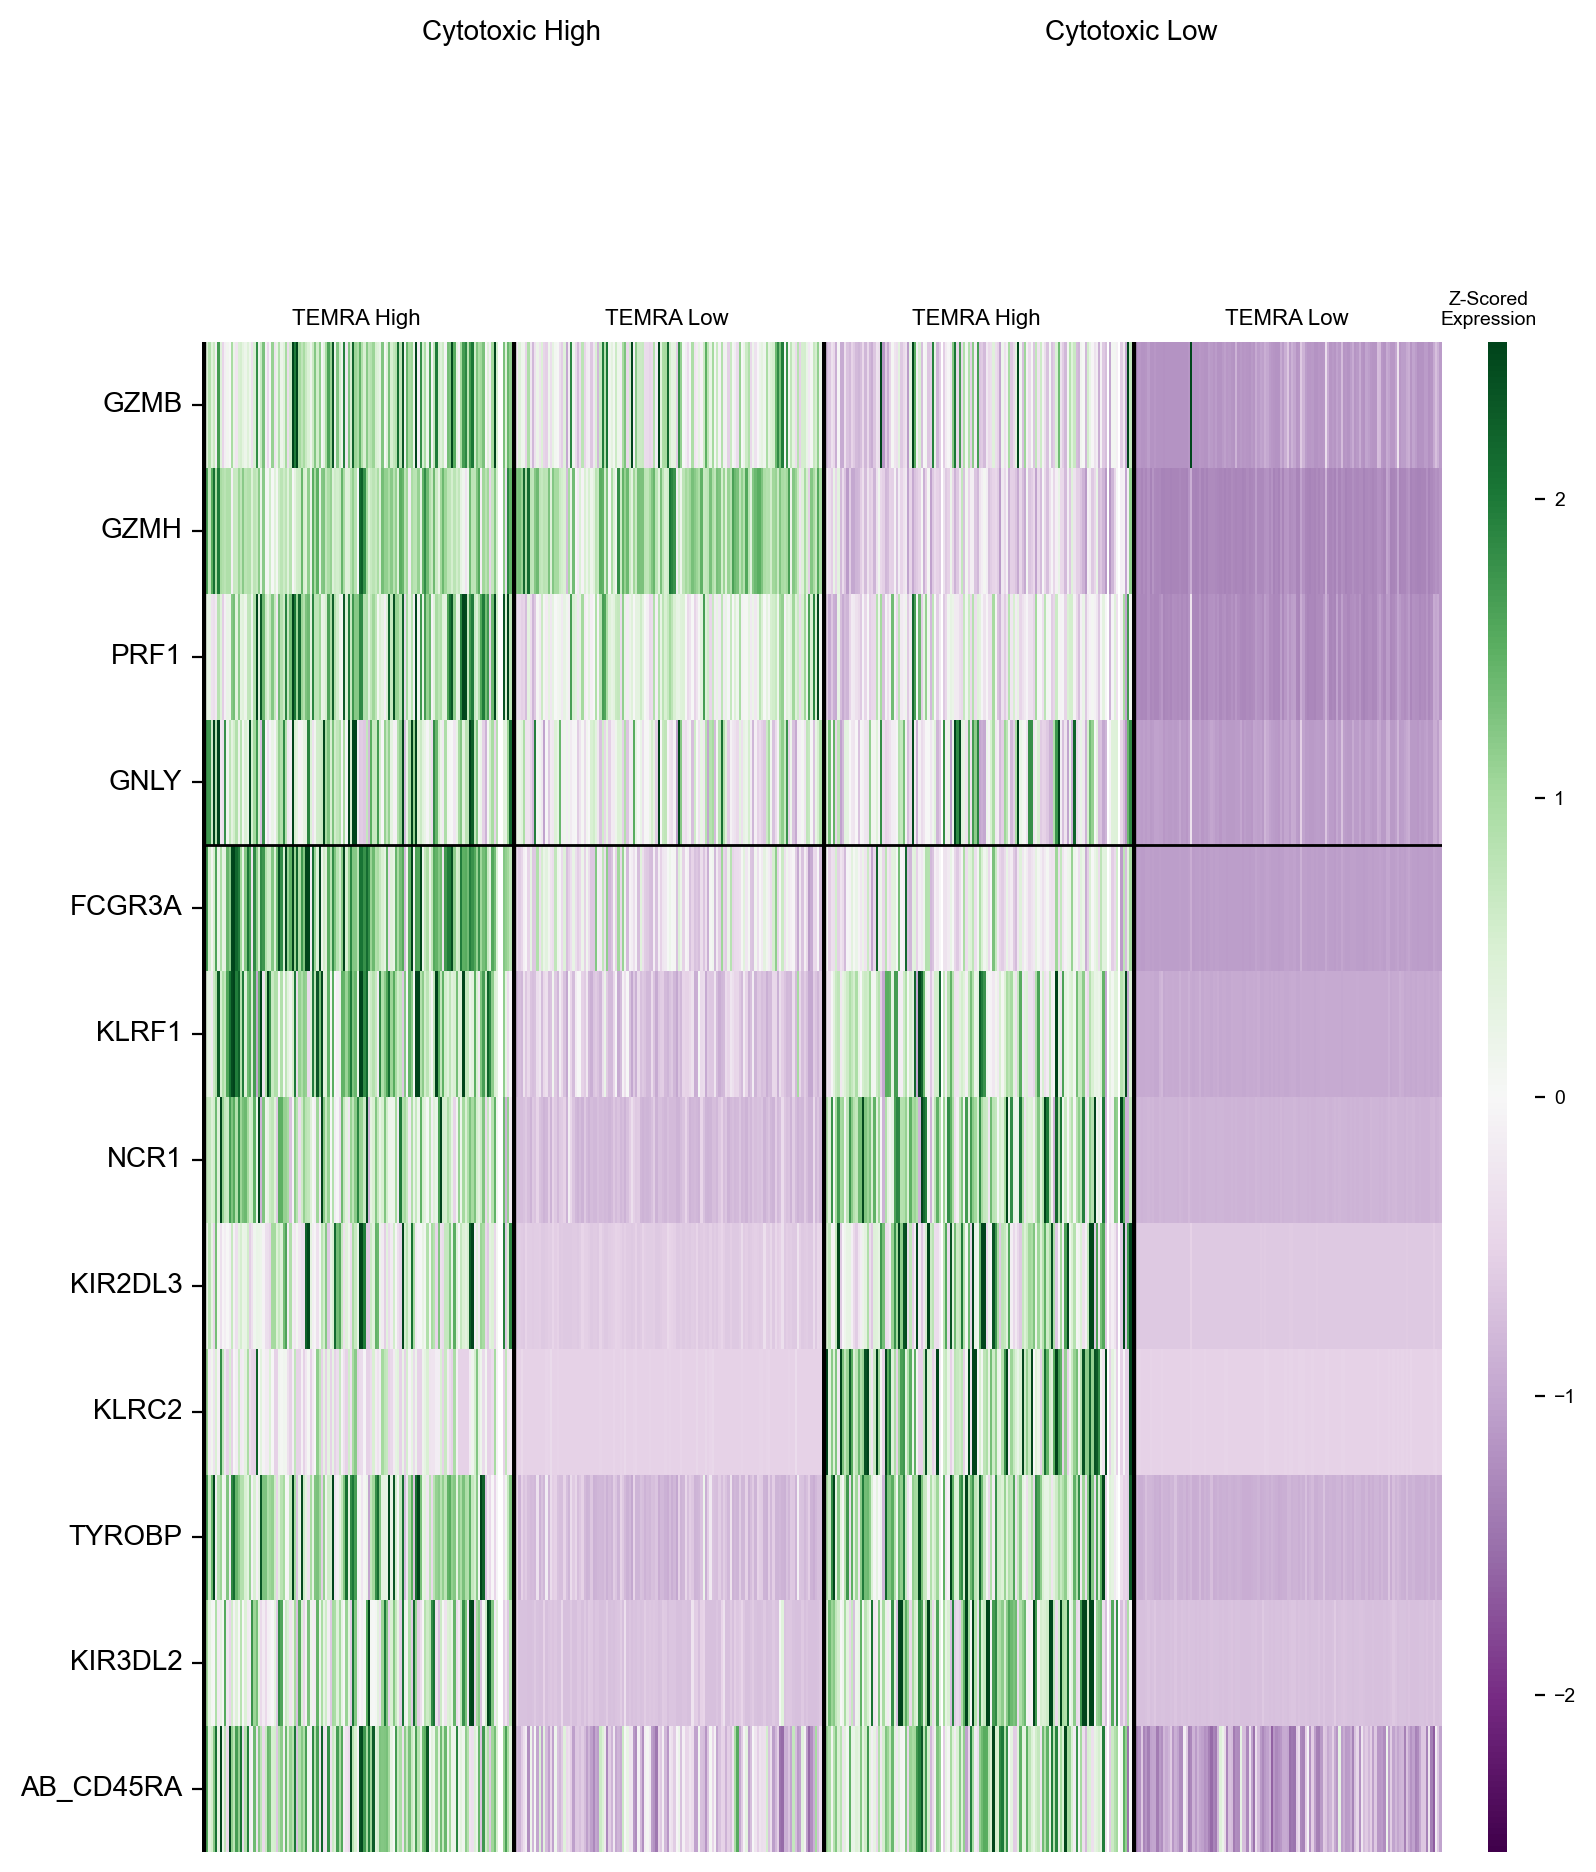

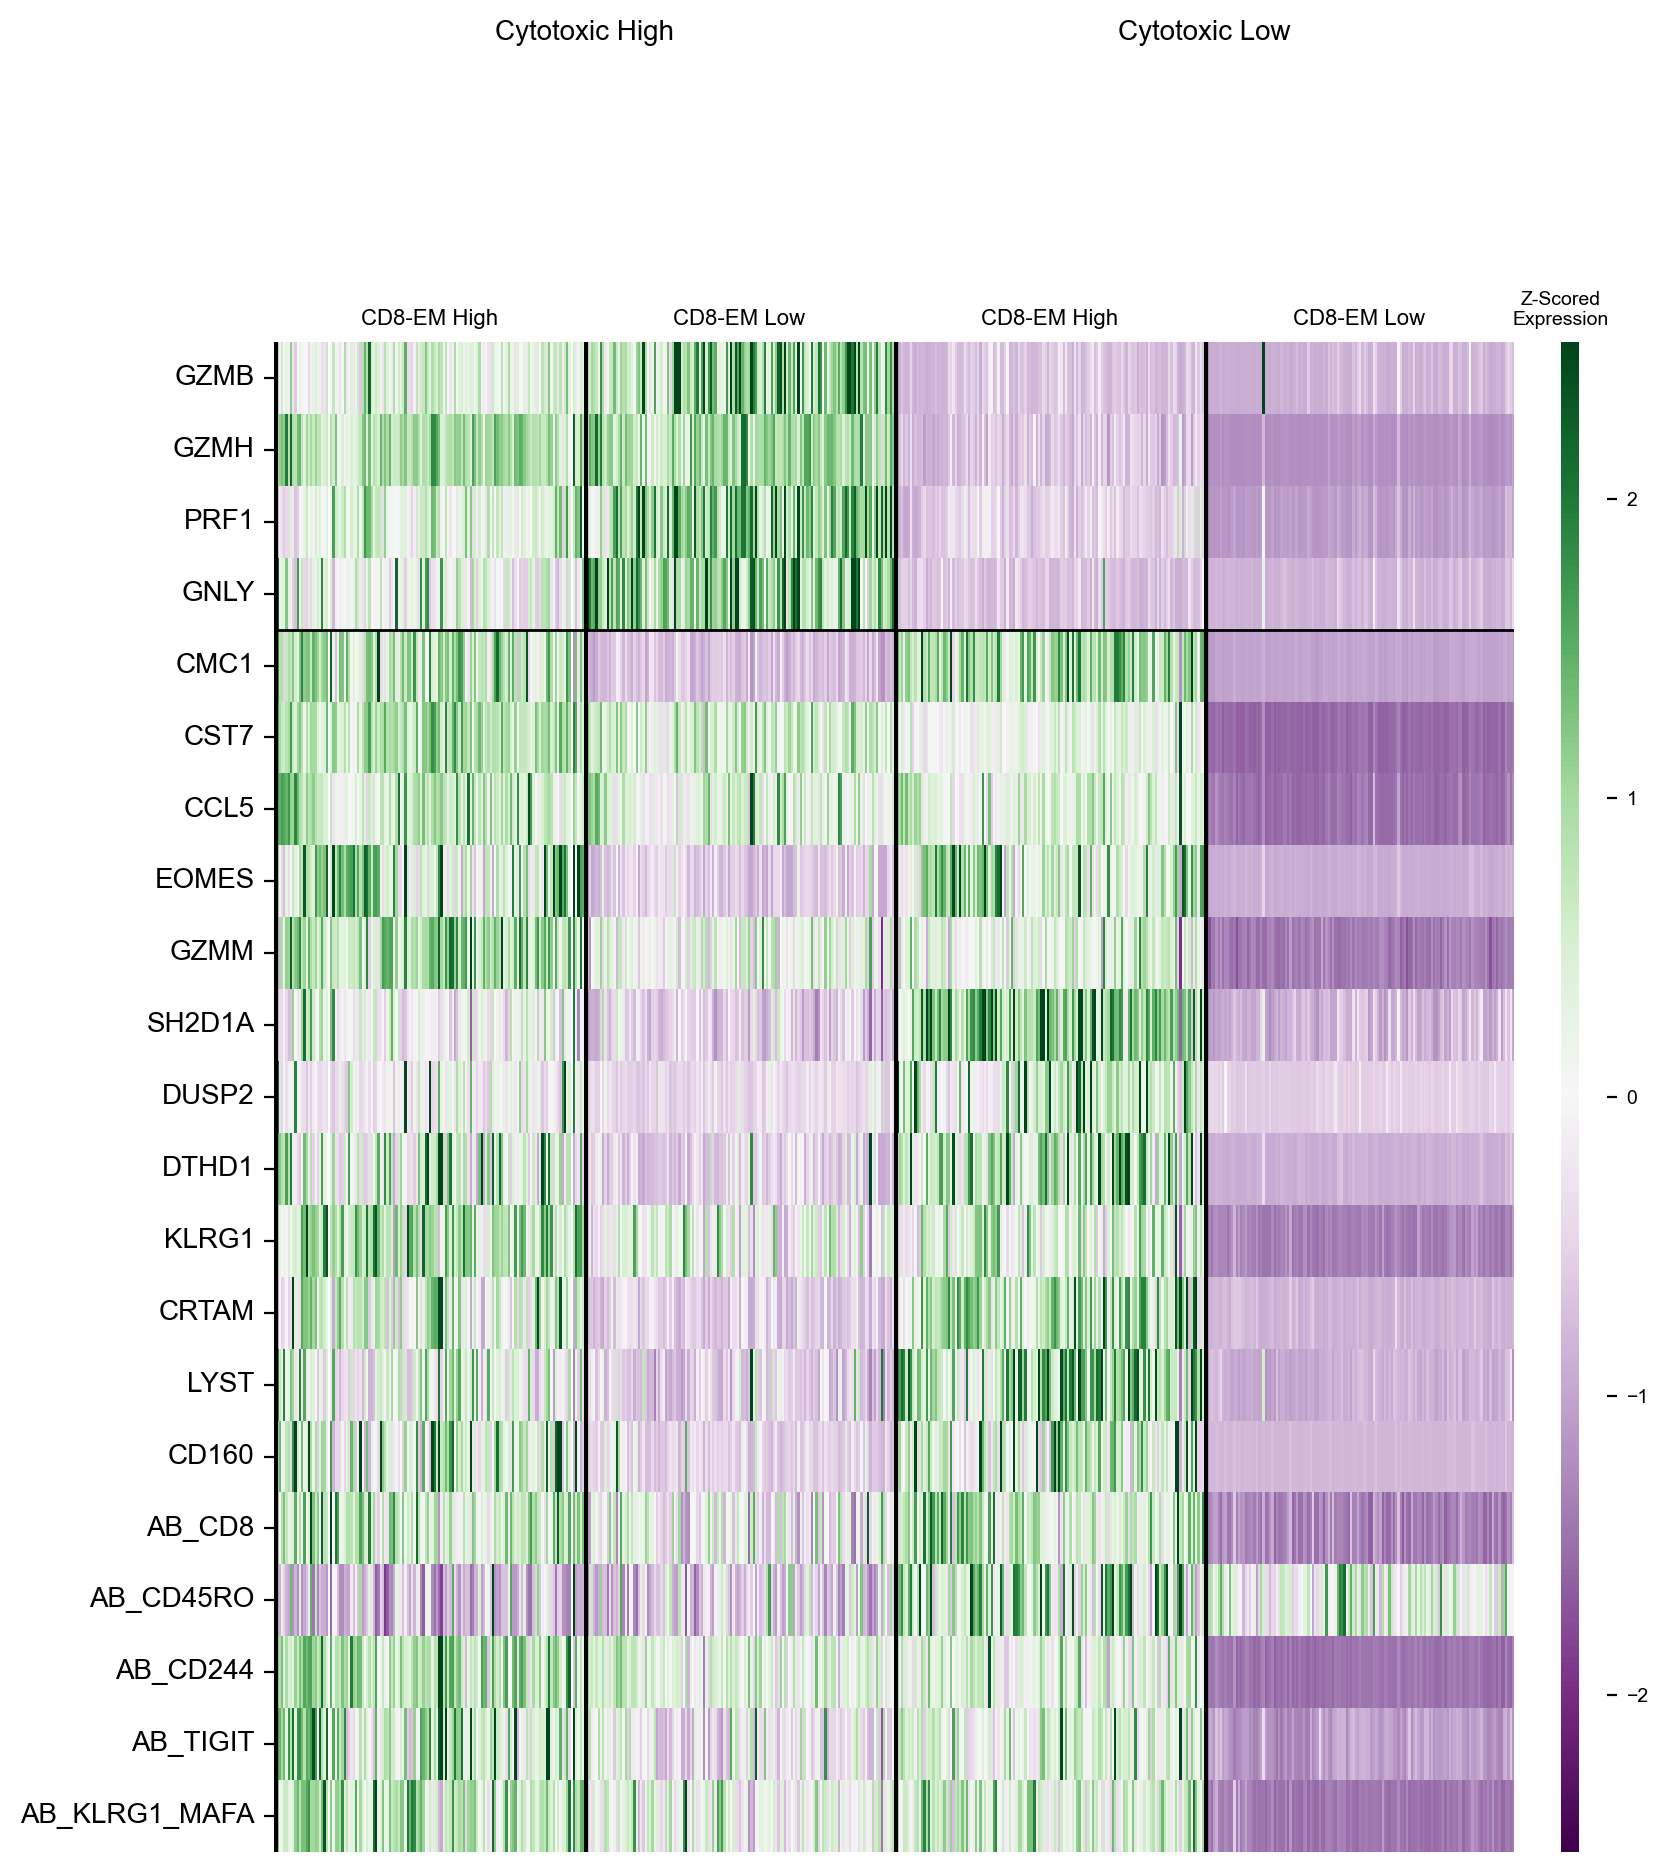

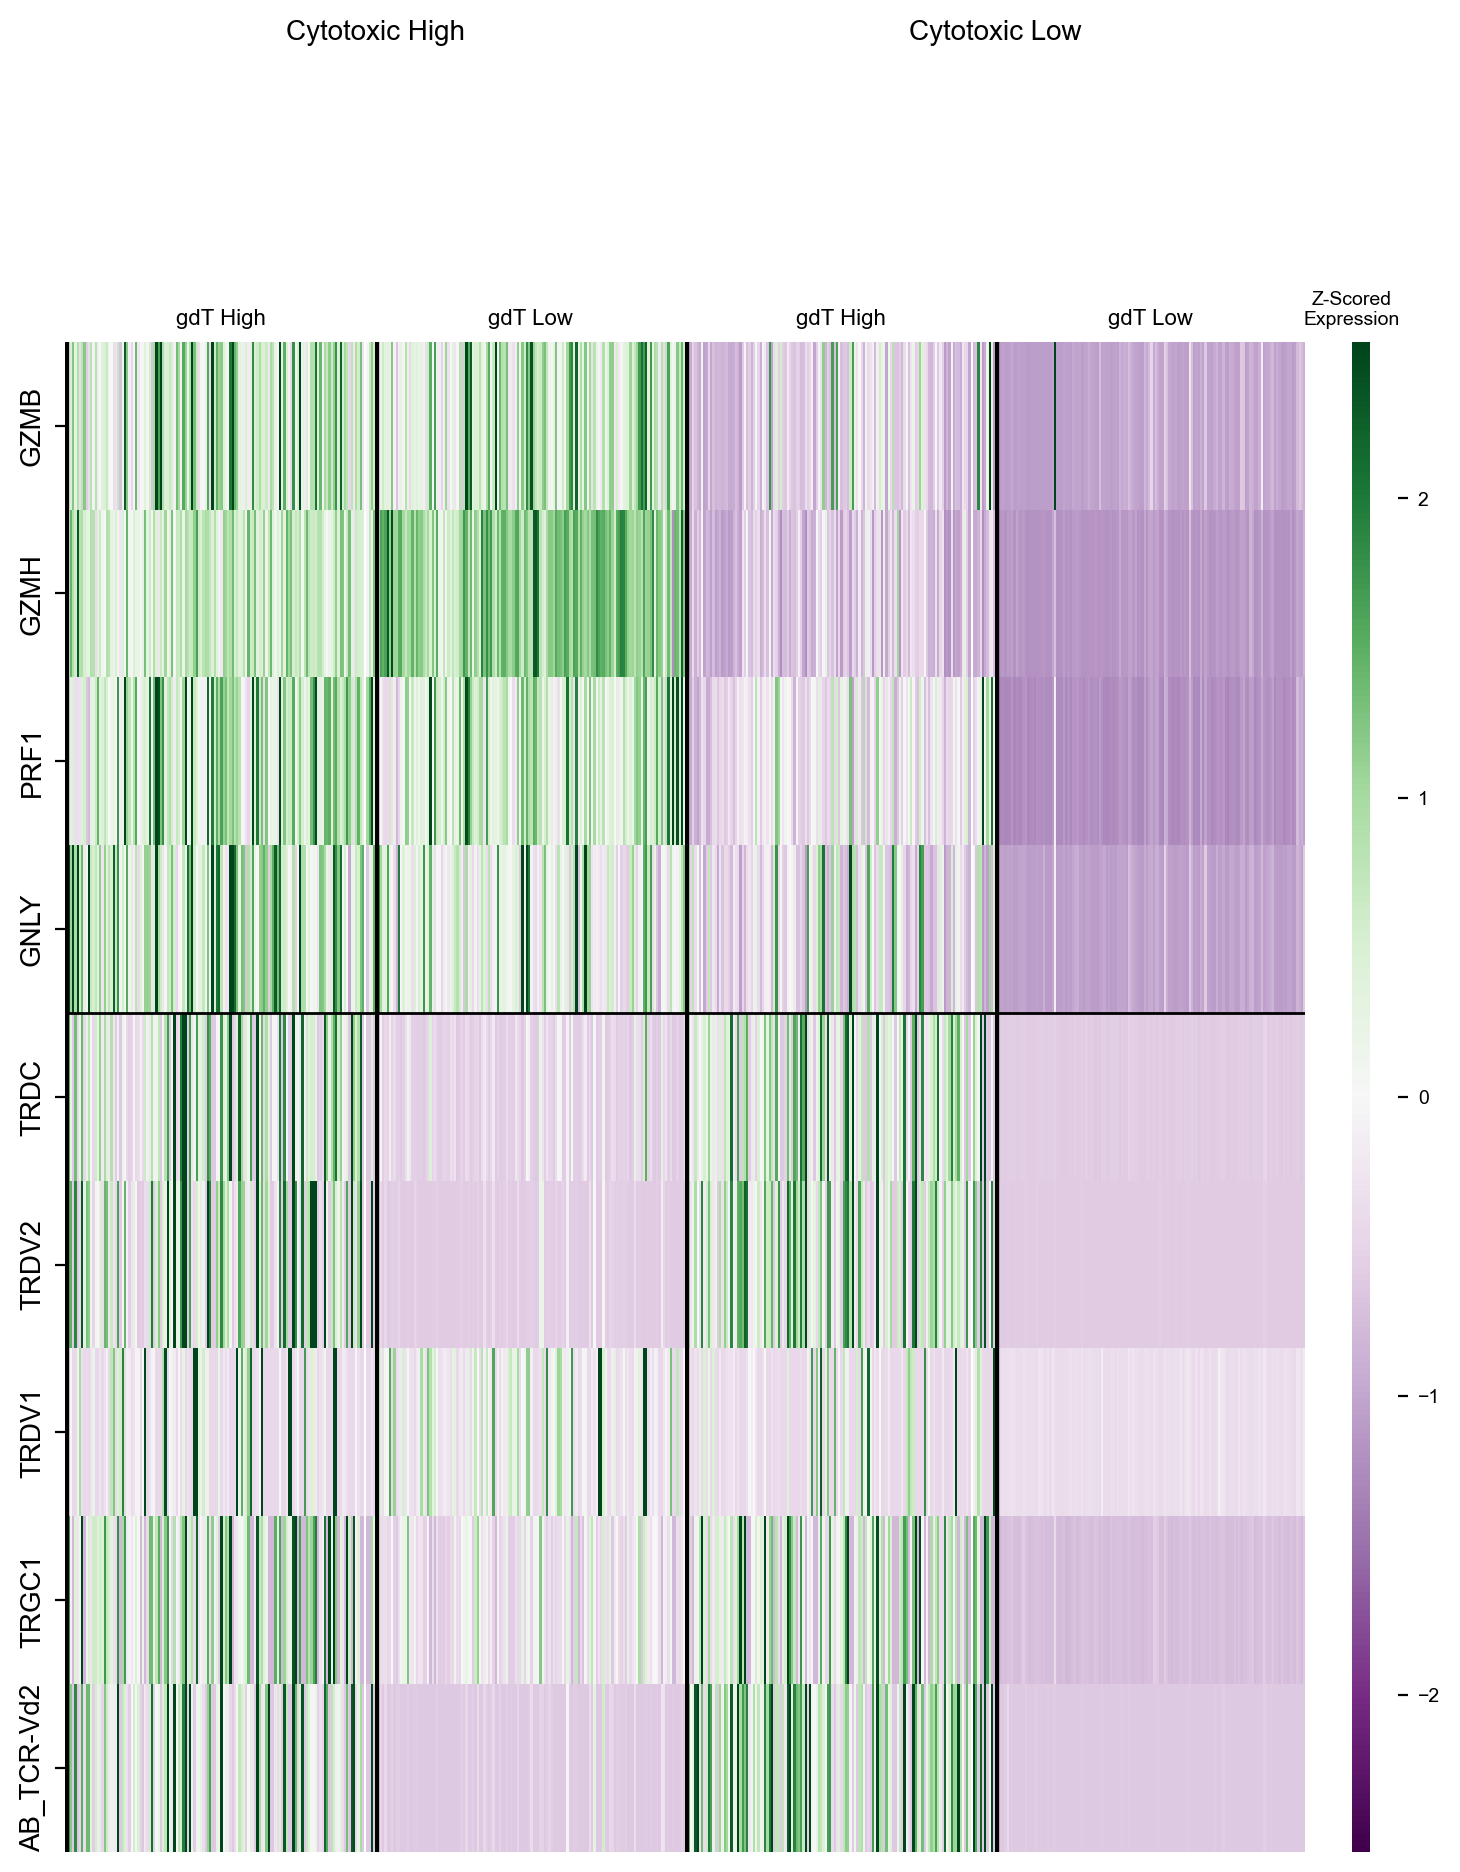

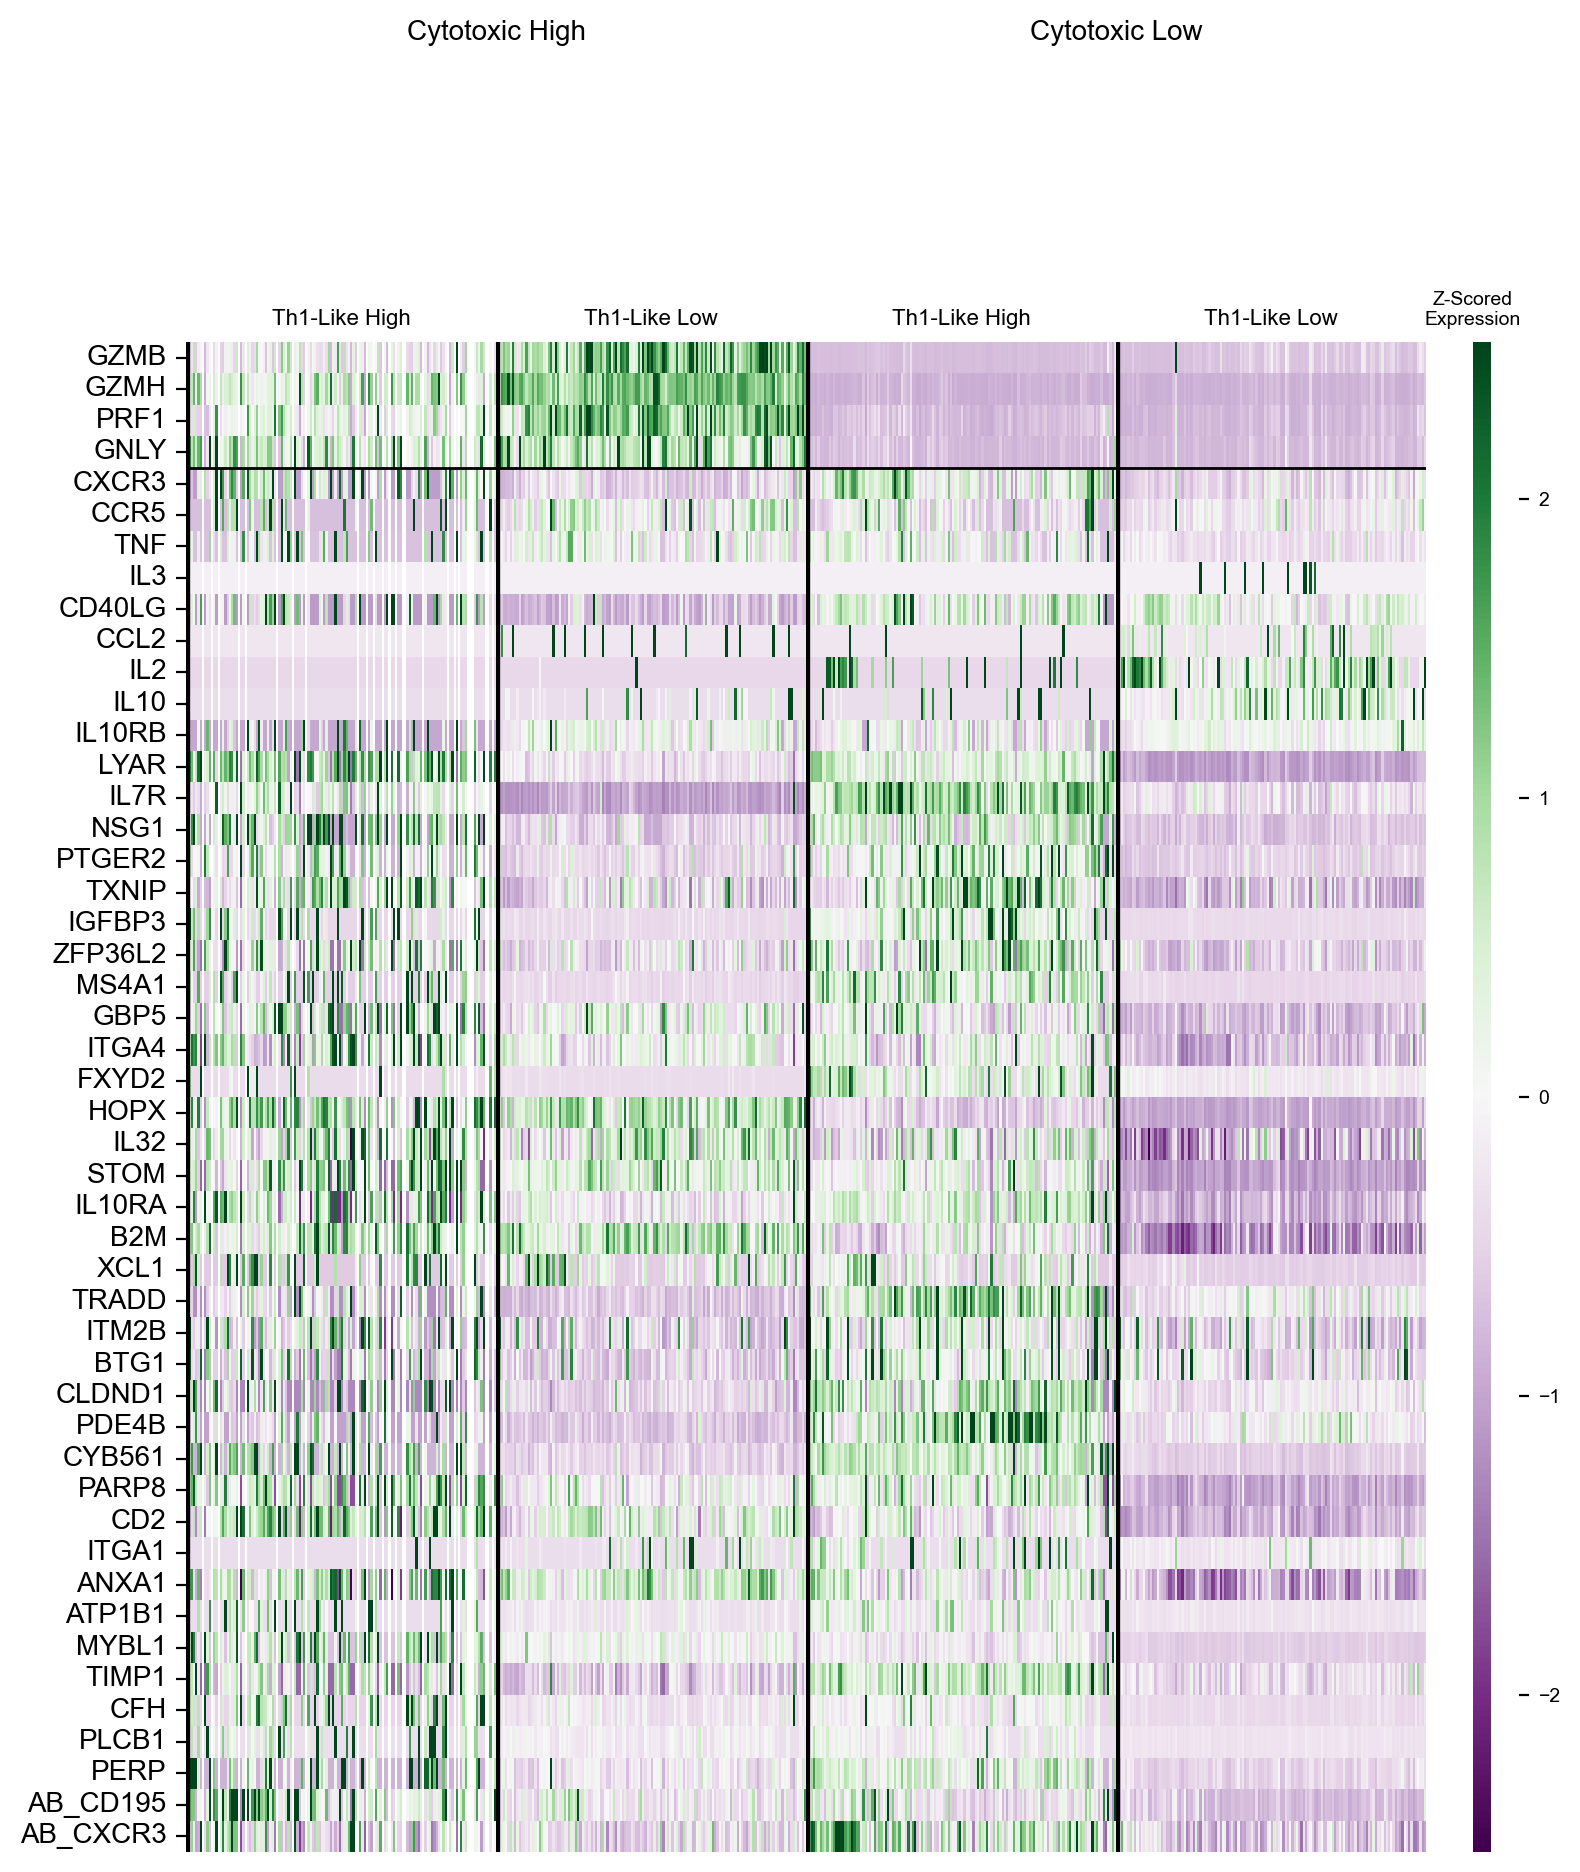

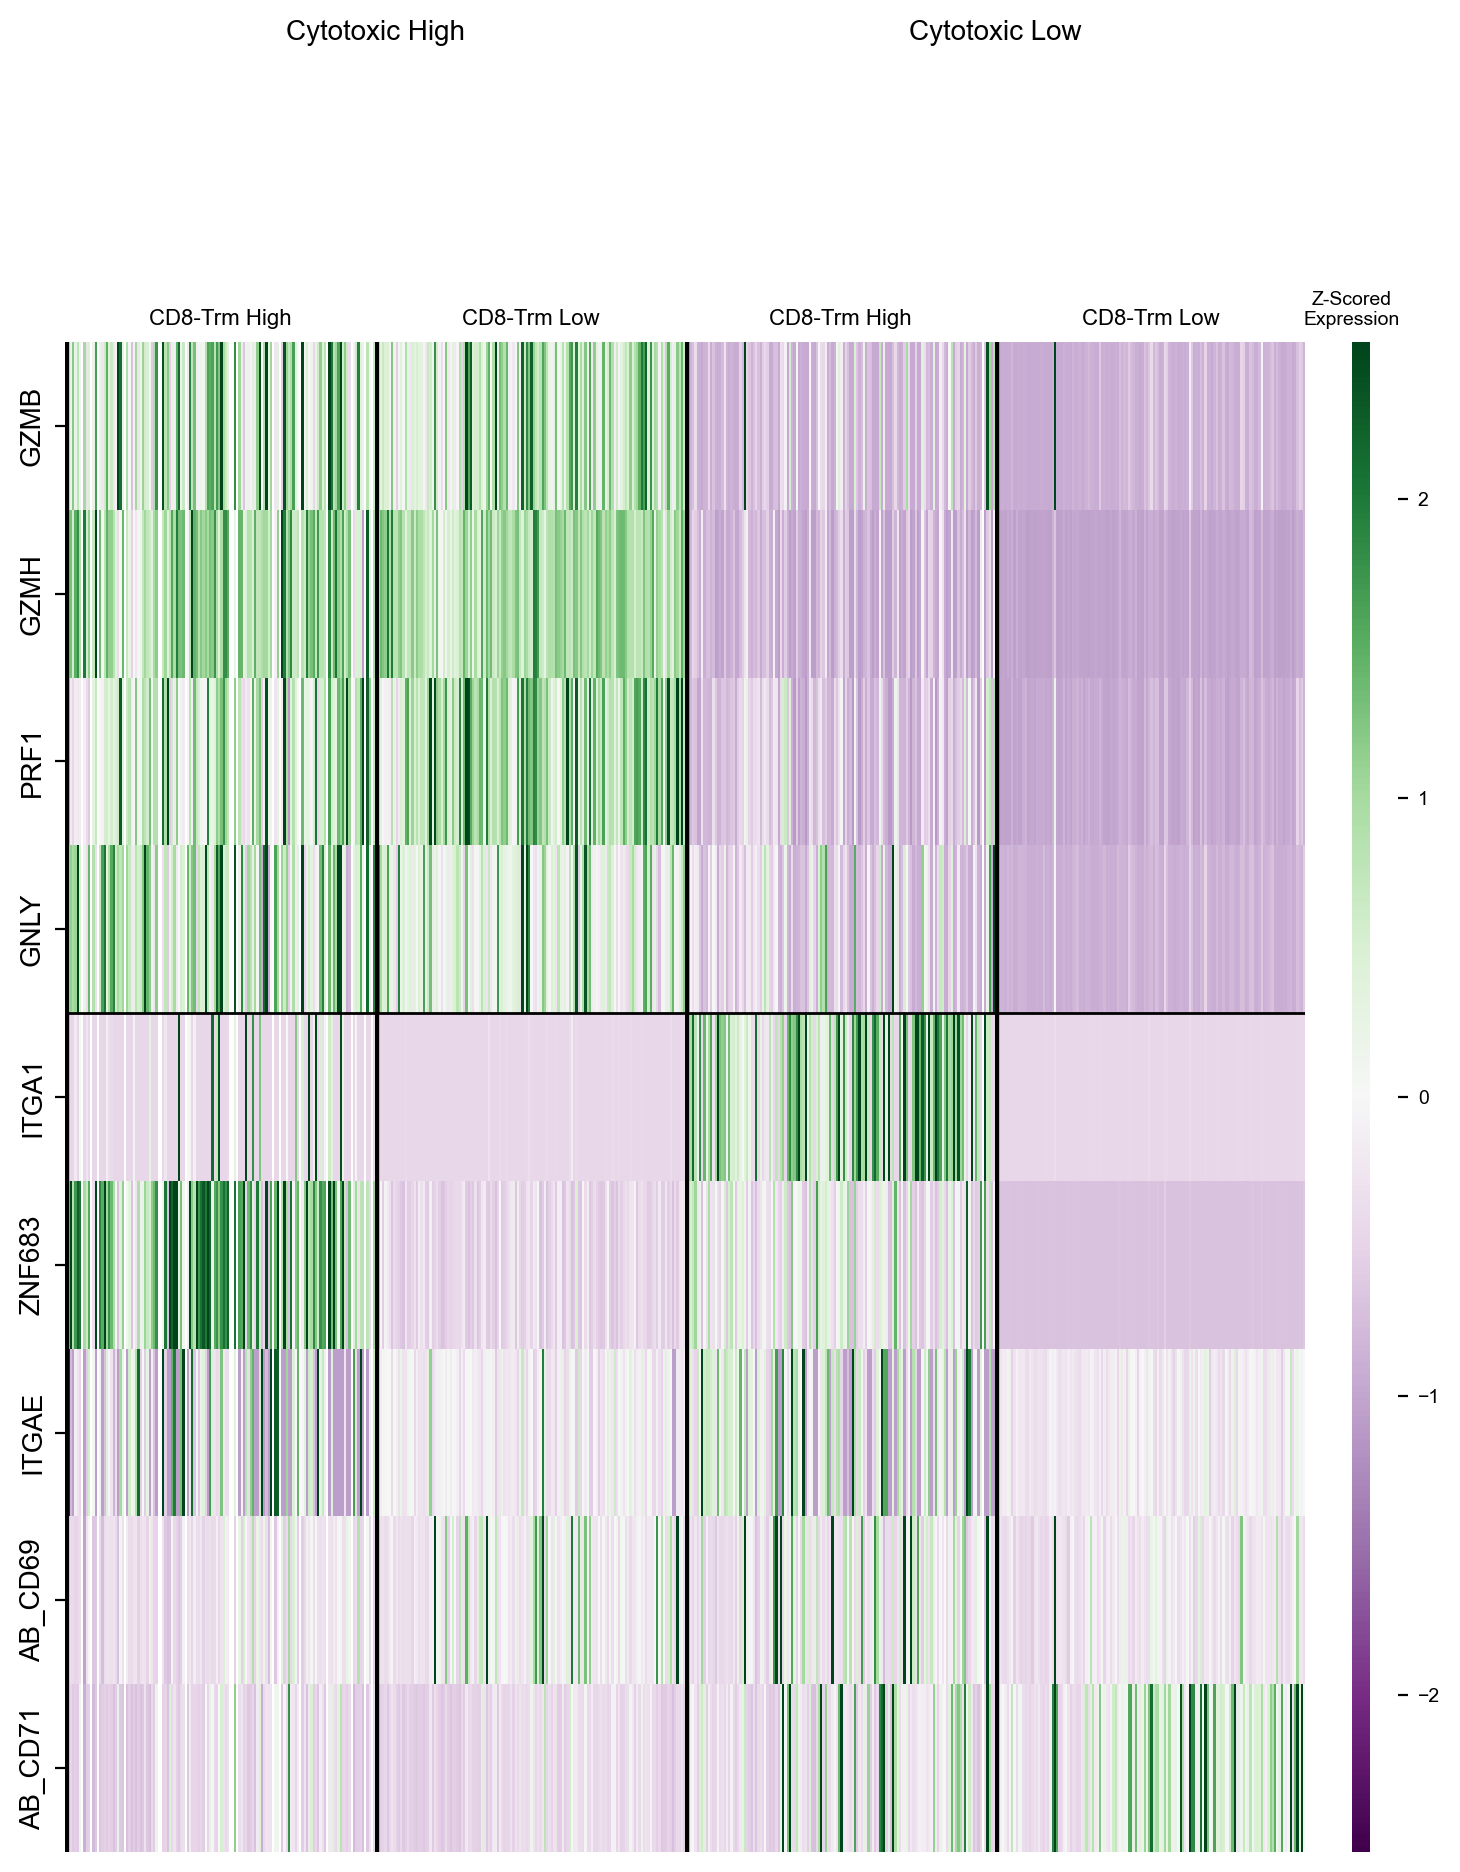

In [664]:
for glist in gep_list_test:
    nrows = 1
    ncols = 4*len(glist)
    width = 8*len(glist)
    height = 10
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                             dpi = 200, gridspec_kw = {'wspace' : 0
                                                      })
    for j, g in enumerate(glist):   
        dat_all = gep_dat[g]
        ms = []
        ms_rna = []
        ms_rna += ms_rna_dict['Cytotoxic']
        ms_rna += ms_rna_dict[g]
        ms += ms_rna

        if g in ms_adt_dict.keys():
            ms_adt = ms_adt_dict[g]
            ms += ms_adt

        for class_i, class_bool in enumerate([True, False]):
            for bin_i, bin_bool in enumerate([True, False]):
                ax = axes[4*j + 2*class_i + bin_i]
                print(g, class_bool, bin_bool, 2*class_i + bin_i)


                dat = dat_all[(dat_all['Bin_%s' % g]==bin_bool) & (dat_all['Bin_Cytotoxic']==class_bool)]
                sns.heatmap(dat[ms].T, cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                            ax = ax)
                # ax.set_title(label_map[b] % g, fontsize = label_fontsize)

                # if n==0:
                gname=g
                ax.set_title({True: '%s High' % gname, False: '%s Low' %gname}[bin_bool], 
                             y = 1, fontsize = tick_fontsize)

                if bin_i==0:
                    ax.text(1, 1.2, s = {True: 'Cytotoxic High', False: 'Cytotoxic Low'}[class_bool], 
                            transform=ax.transAxes, ha = 'center', fontsize = label_fontsize)
                ax.set_xticks([])


                # ax.set_yticks(np.arange(0.5, len(ms)), ms)
                ax.axhline(4, 0, 4, color = 'black', linewidth = 1)

                if (4*j + 2*class_i + bin_i)!=0:
                    ax.set_yticks([])
                ax.tick_params('x', labelsize = tick_fontsize)


                # ax.set_ylabel(lineage, fontsize = label_fontsize)

                # if (j!=0):
                ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 3)

    #             else:
    #                 ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 1)


    cax = ax.inset_axes([1, 0, .3, 1], transform=ax.transAxes)
    cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
                                cmap=sns.color_palette("PRGn", as_cmap=True)),
                 ax=ax, cax=cax, orientation='vertical')
    cbar.outline.set_linewidth(0) 
    cax.set_xticks([vmin, vmax])
    cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
                         '%.1f' % vmax])
    cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-1)
    cax.tick_params(labelsize=tick_fontsize-1)


    # plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers.COMBAT.png'), bbox_inches="tight")
    # plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers.COMBAT.pdf'), bbox_inches="tight")

TEMRA True True 0
TEMRA True False 1
TEMRA False True 2
TEMRA False False 3
CD8-EM True True 0
CD8-EM True False 1
CD8-EM False True 2
CD8-EM False False 3
gdT True True 0
gdT True False 1
gdT False True 2
gdT False False 3


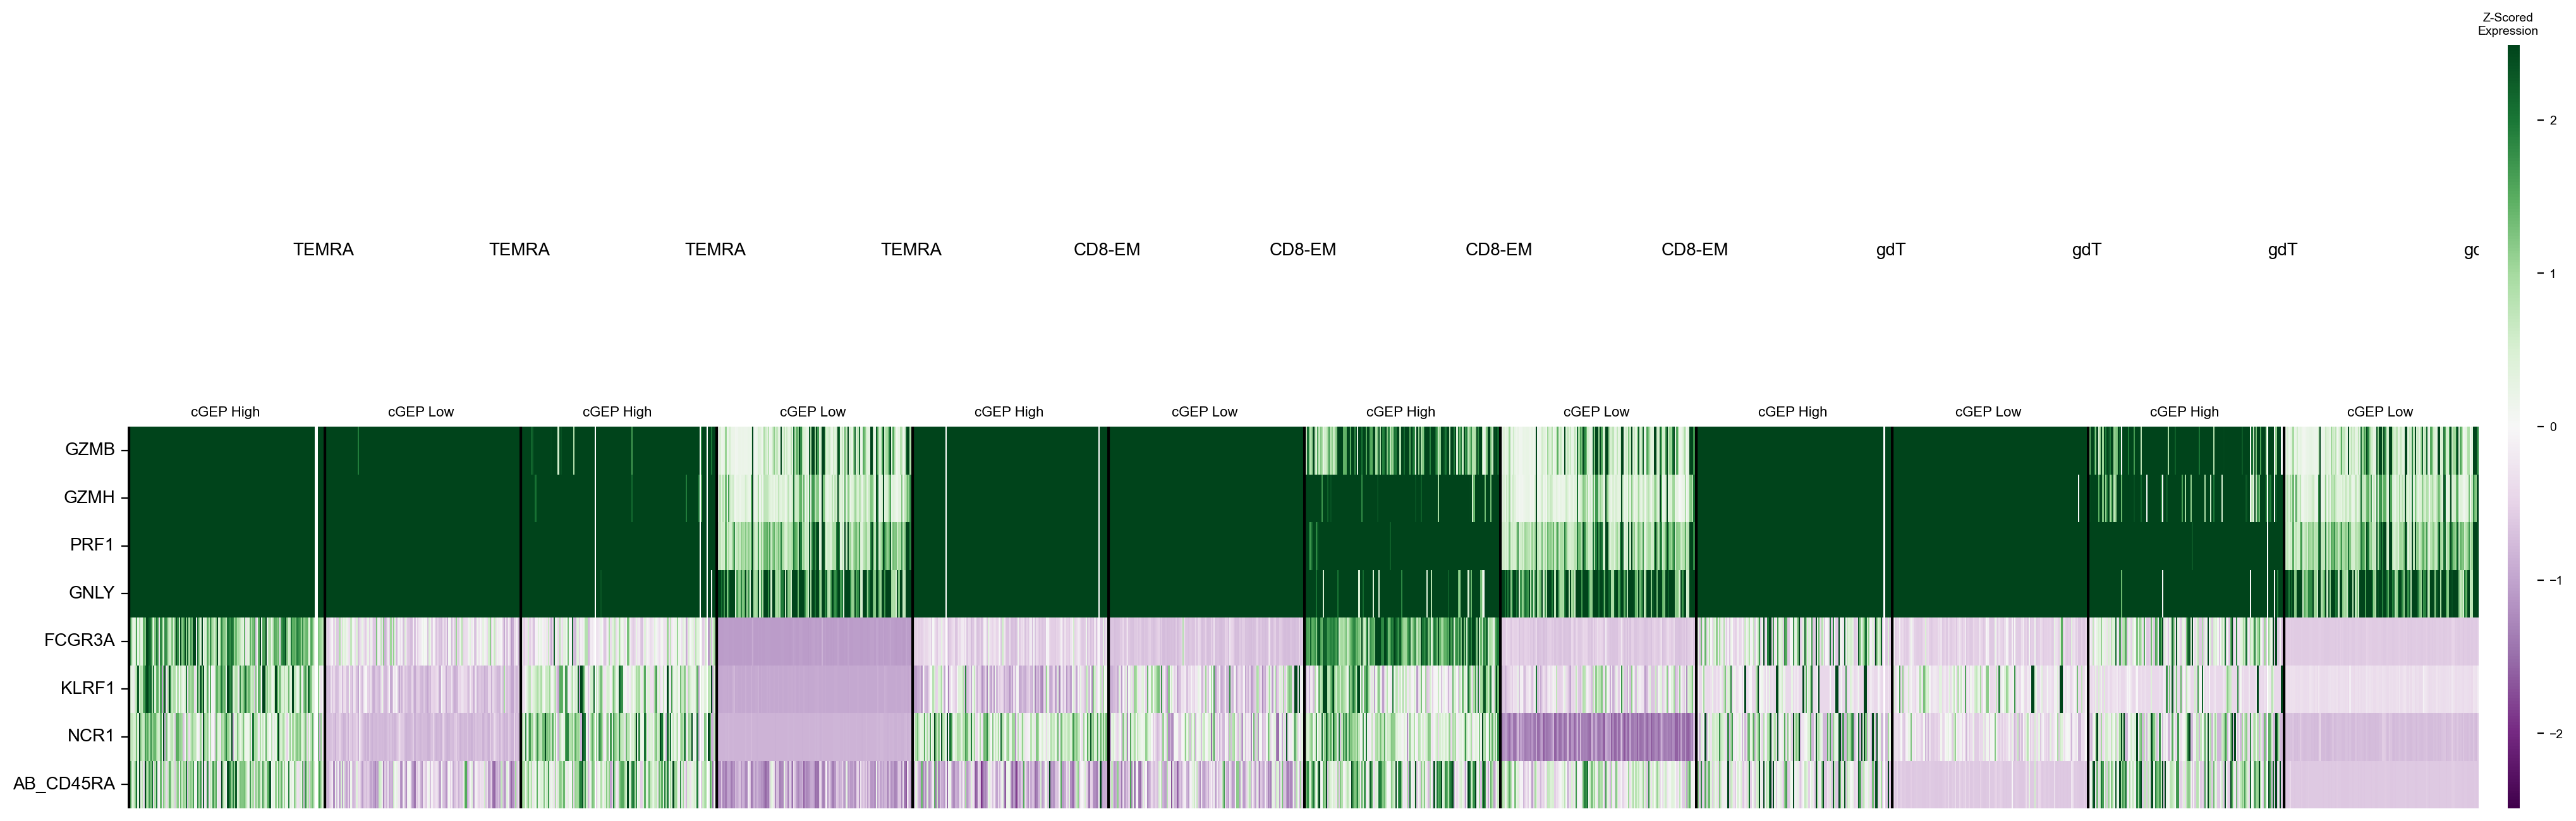

In [272]:
nrows = 1
ncols = 4*len(gep_list)
width = 8*len(gep_list)
height = 4
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                         dpi = 200, gridspec_kw = {'wspace' : 0, 'hspace' : 0,
                                                  })
for j, g in enumerate(gep_list):   
    dat_all = gep_dat[g]
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict['Cytotoxic']
    ms_rna += ms_rna_dict[g]
    ms += ms_rna
    
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt

    for class_i, class_bool in enumerate([True, False]):
        for bin_i, bin_bool in enumerate([True, False]):
            ax = axes[4*j + 2*class_i + bin_i]
            print(g, class_bool, bin_bool, 2*class_i + bin_i)
            
            
            dat = dat_all[(dat_all['Bin_%s' % g]==bin_bool) & (dat_all['Bin_Cytotoxic']==class_bool)]
            sns.heatmap(dat[ms].T, cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                        ax = ax)
            # ax.set_title(label_map[b] % g, fontsize = label_fontsize)
            
            # if n==0:
            ax.set_title({True: 'cGEP High', False: 'cGEP Low'}[bin_bool], y = 1, fontsize = tick_fontsize)

            gname=g

            ax.text(1, 1.45, s = gname, transform=ax.transAxes, ha = 'center', fontsize = label_fontsize)
            ax.set_xticks([])
                
            
            # ax.set_yticks(np.arange(0.5, len(ms)), ms)
                # ax.axhline(0, 0, 10, color = 'black', linewidth = 1)
                
            if (4*j + 2*class_i + bin_i)!=0:
                ax.set_yticks([])
            ax.tick_params('x', labelsize = tick_fontsize)
            

            # ax.set_ylabel(lineage, fontsize = label_fontsize)
                
            if (i==0):
                ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 3)

            else:
                ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 1)

                
cax = ax.inset_axes([1, 0, .3, 2], transform=ax.transAxes)
cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
                            cmap=sns.color_palette("PRGn", as_cmap=True)),
             ax=ax, cax=cax, orientation='vertical')
cbar.outline.set_linewidth(0) 
cax.set_xticks([vmin, vmax])
cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
                     '%.1f' % vmax])
cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-1)
cax.tick_params(labelsize=tick_fontsize-1)


# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers.COMBAT.png'), bbox_inches="tight")
# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers.COMBAT.pdf'), bbox_inches="tight")

In [250]:
for j, g in enumerate(gep_list):    
    for class_i, class_bool in enumerate([True, False]):
        for bin_i, bin_bool in enumerate([True, False]):
            print(g, class_bool, bin_bool, 2*class_i + bin_i)

TEMRA True True 0
TEMRA True False 1
TEMRA False True 2
TEMRA False False 3
CD8-EM True True 0
CD8-EM True False 1
CD8-EM False True 2
CD8-EM False False 3
gdT True True 0
gdT True False 1
gdT False True 2
gdT False False 3


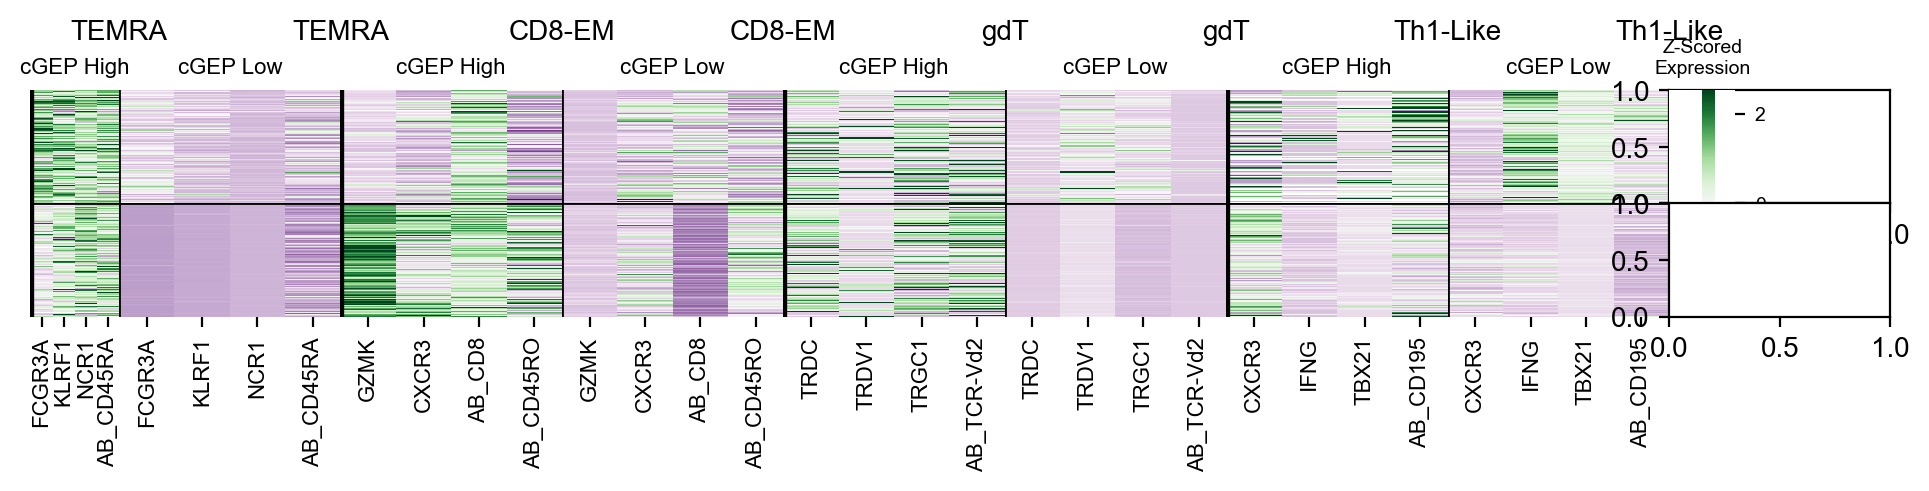

In [196]:
nrows = 2
ncols = 2*len(gep_list) + 1
width = 3*len(gep_list)
height = 1.5
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                         dpi = 200, gridspec_kw = {'wspace' : 0, 'hspace' : 0,
                                                  'width_ratios' : [2] + [5]*2*len(gep_list)})

# g = 'CD4_CD8'
# dat_all = gep_dat[g]
# ms = ['AB_CD4-2', 'AB_CD8']
# for n, lineage in enumerate(['CD4', 'CD8']):
#     ax = axes[n, 0]
#     dat = dat_all[(dat_all['class']==lineage)]
#     sns.heatmap(dat[ms], cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
#                 ax = ax)
#     ax.set_yticks([])
#     ax.set_ylabel(lineage, fontsize = tick_fontsize)
    
#     if n==0:
#         ax.set_xticks([])
#         ax.set_title('All', y = 1, fontsize = tick_fontsize)
    
#     else:
#         ax.set_xticks(np.arange(0.5, len(ms)), ms)
#         ax.tick_params('x', labelsize = tick_fontsize, rotation = 90)
#         ax.axhline(0, 0, 10, color = 'black', linewidth = 1)
    

for j, g in enumerate(gep_list):
    dat_all = gep_dat[g]
    ms = []
    ms_rna = ms_rna_dict[g]
    ms += ms_rna
    
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt
    
    for n, a in enumerate([True, False]):
        # High/Low polarizations
        for i, b in enumerate([True, False]):
            ax = axes[n, 2*j + i]   
            dat = dat_all[(dat_all['Bin_%s' % g]==b) & (dat_all['Bin_Cytotoxic']==a)
                         ]
            sns.heatmap(dat[ms], cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                        ax = ax)
            # ax.set_title(label_map[b] % g, fontsize = label_fontsize)
            
            if n==0:
                ax.set_title({True: 'cGEP High', False: 'cGEP Low'}[b], y = 1, fontsize = tick_fontsize)

                gname=g

                ax.text(1, 1.45, s = gname, transform=ax.transAxes, ha = 'center', fontsize = label_fontsize)
                ax.set_xticks([])
                
            else:
                ax.set_xticks(np.arange(0.5, len(ms)), ms)
                ax.axhline(0, 0, 10, color = 'black', linewidth = 1)
                
            ax.set_yticks([])
            ax.tick_params('x', labelsize = tick_fontsize)
            

            # ax.set_ylabel(lineage, fontsize = label_fontsize)
                
            if (i==0):
                ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 3)

            else:
                ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 1)

                
cax = ax.inset_axes([1, 0, .3, 2], transform=ax.transAxes)
cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
                            cmap=sns.color_palette("PRGn", as_cmap=True)),
             ax=ax, cax=cax, orientation='vertical')
cbar.outline.set_linewidth(0) 
cax.set_xticks([vmin, vmax])
cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
                     '%.1f' % vmax])
cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-1)
cax.tick_params(labelsize=tick_fontsize-1)


# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers.COMBAT.png'), bbox_inches="tight")
# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers.COMBAT.pdf'), bbox_inches="tight")

In [199]:
2*j

0

### Pre-filtered genes - CD4/CD8 split

In [564]:
sample_order = list(X['sample'].unique())
len(sample_order)

138

In [581]:
ms_rna_dict = {
                'Th1-Like' : ['CXCR3', 'CCR5',
                              #'IFNG-AS1',
    'TNF', 'IL3', 'CD40LG', 'CCL2', 'IL2','IL10',   'IL10RB',                      # 'IFNG', 'TBX21'
                              
   'LYAR',
 'IL7R',
 'NSG1',
 'PTGER2',
 'TXNIP',
 'IGFBP3',
 'ZFP36L2',
 'MS4A1',
 'GBP5',
 'ITGA4',
 'FXYD2',
 'HOPX',
 'IL32',
 'STOM',
 'IL10RA',
 'B2M',
 'XCL1',
 'TRADD',
 'ITM2B',
 'BTG1',
 'CLDND1',
 'PDE4B',
 'CYB561',
 'PARP8',
 'CD2',
 'ITGA1',
 'ANXA1',
 'ATP1B1',
 # 'LINC01943',
 'MYBL1',
 'TIMP1',
 'CFH',
 'PLCB1',
 'PERP'       
                            ],
              'Th2-Resting' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Resting' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
               
               'Treg':['FOXP3', 'IL2RA', 'CTLA4'],
                'Cytotoxic': ['GZMB', 'GZMH', 'PRF1', 'GNLY'],
               'TEMRA' : ['FCGR3A', 'KLRF1', 'NCR1',
                         
                         'KIR2DL3',
'KLRC2',
'TYROBP',
'KIR3DL2'],
               'CD8-EM' : ['CMC1',

                    'CST7',
                    'CCL5',

                    'EOMES',

                    'GZMM',
                    'SH2D1A',
                    'DUSP2',
                    'DTHD1',
                    'KLRG1',
                    'CRTAM',
                    'LYST',
                    'CD160',
                    ]
    ,
               'gdT' : ['TRDC', 'TRDV2', 'TRDV1', 'TRGC1'],
              }

ms_adt_dict = {'Th1-Like' : [ 'AB_CD195', 'AB_CXCR3'],
              'Th2-Resting' : ['AB_CD194'],
              'Th2-Activated' : ['AB_CD194'],
              'Treg' : ['AB_CD25', 'AB_CD39'],
              'TEMRA' : ['AB_CD45RA'],
              'CD8-EM' : ['AB_CD8', 'AB_CD45RO', 'AB_CD244', 'AB_TIGIT', 'AB_KLRG1_MAFA'],
               'gdT' : ['AB_TCR-Vd2']
}


In [582]:
gep_list = ['TEMRA', 'CD8-EM', 'gdT', 'Th1-Like'
            #'CD8-Trm'
           ]

In [583]:
X_test = X[(X['class'].isin(['CD4', 'CD8']))]


In [584]:
# Pseudobulk and normalize for each thresholded GEP
gep_dat = {}
ms_all = []
ms_all += ms_rna_dict['Cytotoxic']
# ms_rna_all = []
# ms_adt_all = []

for g in gep_list:
    sample_sum = X_test.groupby(['sample', 'class', 'Bin_Cytotoxic', 'Bin_%s' % g]).sum().reset_index().dropna()
    sample_sum['Ncell'] = X_test.groupby(['sample','class', 'Bin_Cytotoxic', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']
        
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict[g]
    ms += ms_rna
    
    ms_rna += ms_rna_dict['Cytotoxic']
    pseudobulk = sample_sum[ms_rna] #+1
    pseudobulk = pseudobulk.multiply(1e4 / sample_sum['N'], axis=0) #.apply(np.log2)
    sample_sum[ms_rna] = pseudobulk
    
    # ms_rna_all += ms_rna
    
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        pseudobulk_adt = sample_sum[ms_adt] #+1
        pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
        sample_sum[ms_adt] = pseudobulk_adt
        ms += ms_adt
        # ms_adt_all += ms_adt

    sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

    dat_all = sample_sum.copy()
    ms_cyto = ms + ms_rna_dict['Cytotoxic']
    dat_all[ms_cyto] = dat_all[ms_cyto].subtract(sample_sum[ms_cyto].mean(), axis =1)
    dat_all[ms_cyto] = dat_all[ms_cyto].divide(sample_sum[ms_cyto].std(), axis = 1)

    gep_dat[g] = dat_all
    ms_all += ms

In [585]:
len(ms_all), len(set(ms_all))

(78, 78)

In [188]:
# # Add normalized data for CD4/CD8 also:

# sample_sum = X_test.groupby(['sample']).sum().reset_index().dropna()
# sample_sum['Ncell'] = X_test.groupby(['sample']).count().reset_index().dropna()['Th1-Like']

# ms_adt = ms_adt_all
# ms_rna = ms_rna_all

# ms = []
# # ms_adt = ['AB_CD4-2', 'AB_CD8']
# pseudobulk_adt = sample_sum[ms_adt] #+1
# pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
# sample_sum[ms_adt] = pseudobulk_adt
# ms += ms_adt

# sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

# dat_all = sample_sum.copy()
# dat_all[ms] = dat_all[ms].subtract(sample_sum[ms].mean(), axis =1)
# dat_all[ms] = dat_all[ms].divide(sample_sum[ms].std(), axis = 1)

# gep_dat['CD4_CD8'] = dat_all
# ms_all += ms

In [586]:
vmax_list = []
# Get vmax using normalized dat and markers
for g in gep_list:
    dat_all = gep_dat[g]    
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict['Cytotoxic']
    ms_rna += ms_rna_dict[g]
    ms += ms_rna
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt
    
    vmax_list += dat_all[ms].unstack().tolist()


vmax = pd.Series(vmax_list).quantile(.98)
vmin = -vmax

In [587]:
vmax

2.516514301300048

In [498]:
label_fontsize = 10
tick_fontsize = 8

In [499]:
4*len(gep_list)

16

In [500]:
[0, 0, 0, .05]*3

[0, 0, 0, 0.05, 0, 0, 0, 0.05, 0, 0, 0, 0.05]

In [501]:
gep_list_test = [['TEMRA'], ['CD8-EM'], ['gdT'], ['Th1-Like']]

In [524]:
tick_fontsize = 6
label_fontsize = 8

In [ ]:
for lineage in ['CD4', 'CD8']:

In [588]:
g = 'Th1-Like'
dat_all = gep_dat[g]


In [589]:
lineage='CD8'

In [578]:
dat_all[dat_all['class']==lineage]

,sample,class,Bin_Cytotoxic,Bin_Th1-Like,Th1-Like,Treg,Th2-Resting,Th17-Resting,Th22,Th2-Activated,...,ZFP36L2,CCL2,CD40LG,IL2,IL3,TNF,IL10,IL10RB,TRDV2,Ncell
4,G05061-Ja005,CD8,False,False,0.023059,0.010147,0.012744,0.009001,0.009418,0.004364,...,213.0,0.0,11.0,2.0,0.0,18.0,0.0,19.0,3.0,425
5,G05061-Ja005,CD8,False,True,0.149584,0.008516,0.009099,0.011561,0.010385,0.002674,...,54.0,0.0,1.0,0.0,0.0,7.0,0.0,2.0,0.0,61
6,G05061-Ja005,CD8,True,False,0.013544,0.007531,0.004528,0.004346,0.004486,0.002795,...,58.0,0.0,1.0,0.0,0.0,4.0,0.0,9.0,0.0,188
7,G05061-Ja005,CD8,True,True,0.135959,0.003344,0.014307,0.018730,0.005499,0.012321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
12,G05064-Ja005,CD8,False,False,0.016442,0.007830,0.012235,0.010338,0.006764,0.004503,...,953.0,0.0,15.0,0.0,0.0,6.0,6.0,56.0,2.0,1119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,U00619-Ua005,CD8,True,True,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1100,U00701-Ua005,CD8,False,False,0.038884,0.004598,0.014796,0.007864,0.010033,0.003175,...,30.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,57
1101,U00701-Ua005,CD8,False,True,0.182158,0.006442,0.009945,0.006861,0.012101,0.008471,...,15.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,13
1102,U00701-Ua005,CD8,True,False,0.026718,0.004062,0.009115,0.005286,0.011635,0.002219,...,133.0,0.0,2.0,0.0,0.0,6.0,0.0,12.0,0.0,250


Th1-Like True True 0
Th1-Like True False 1
Th1-Like False True 2
Th1-Like False False 3
Th1-Like True True 0
Th1-Like True False 1
Th1-Like False True 2
Th1-Like False False 3


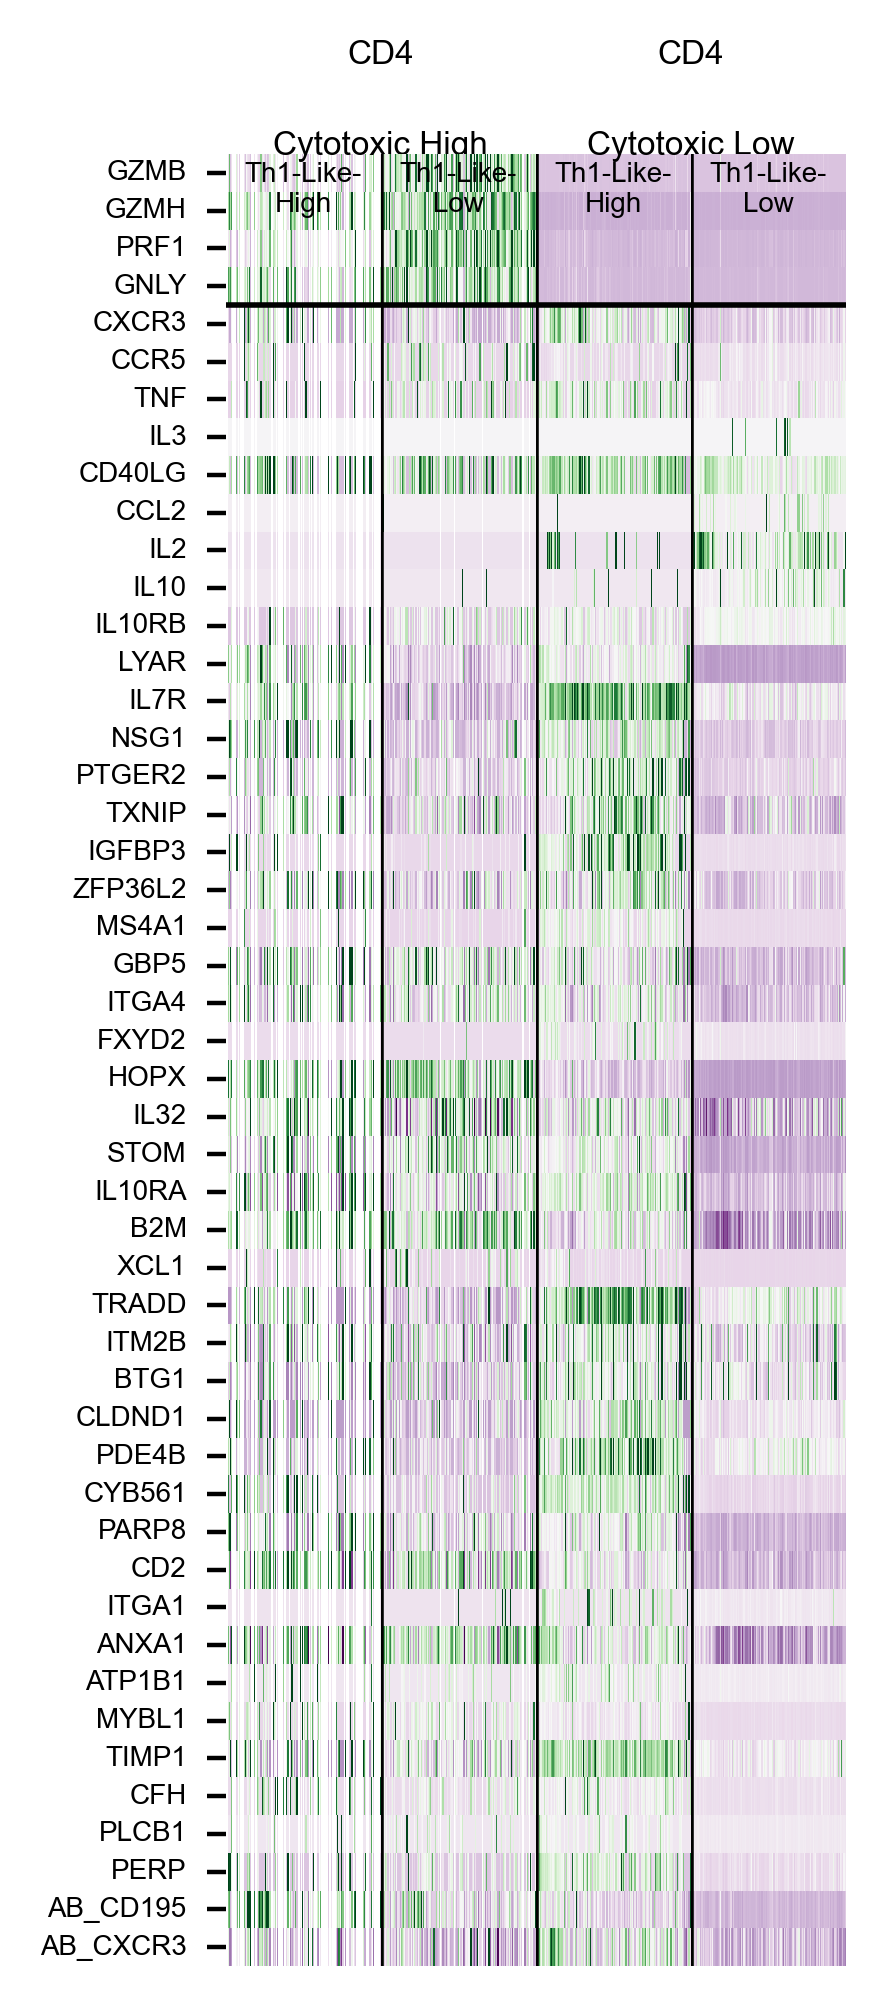

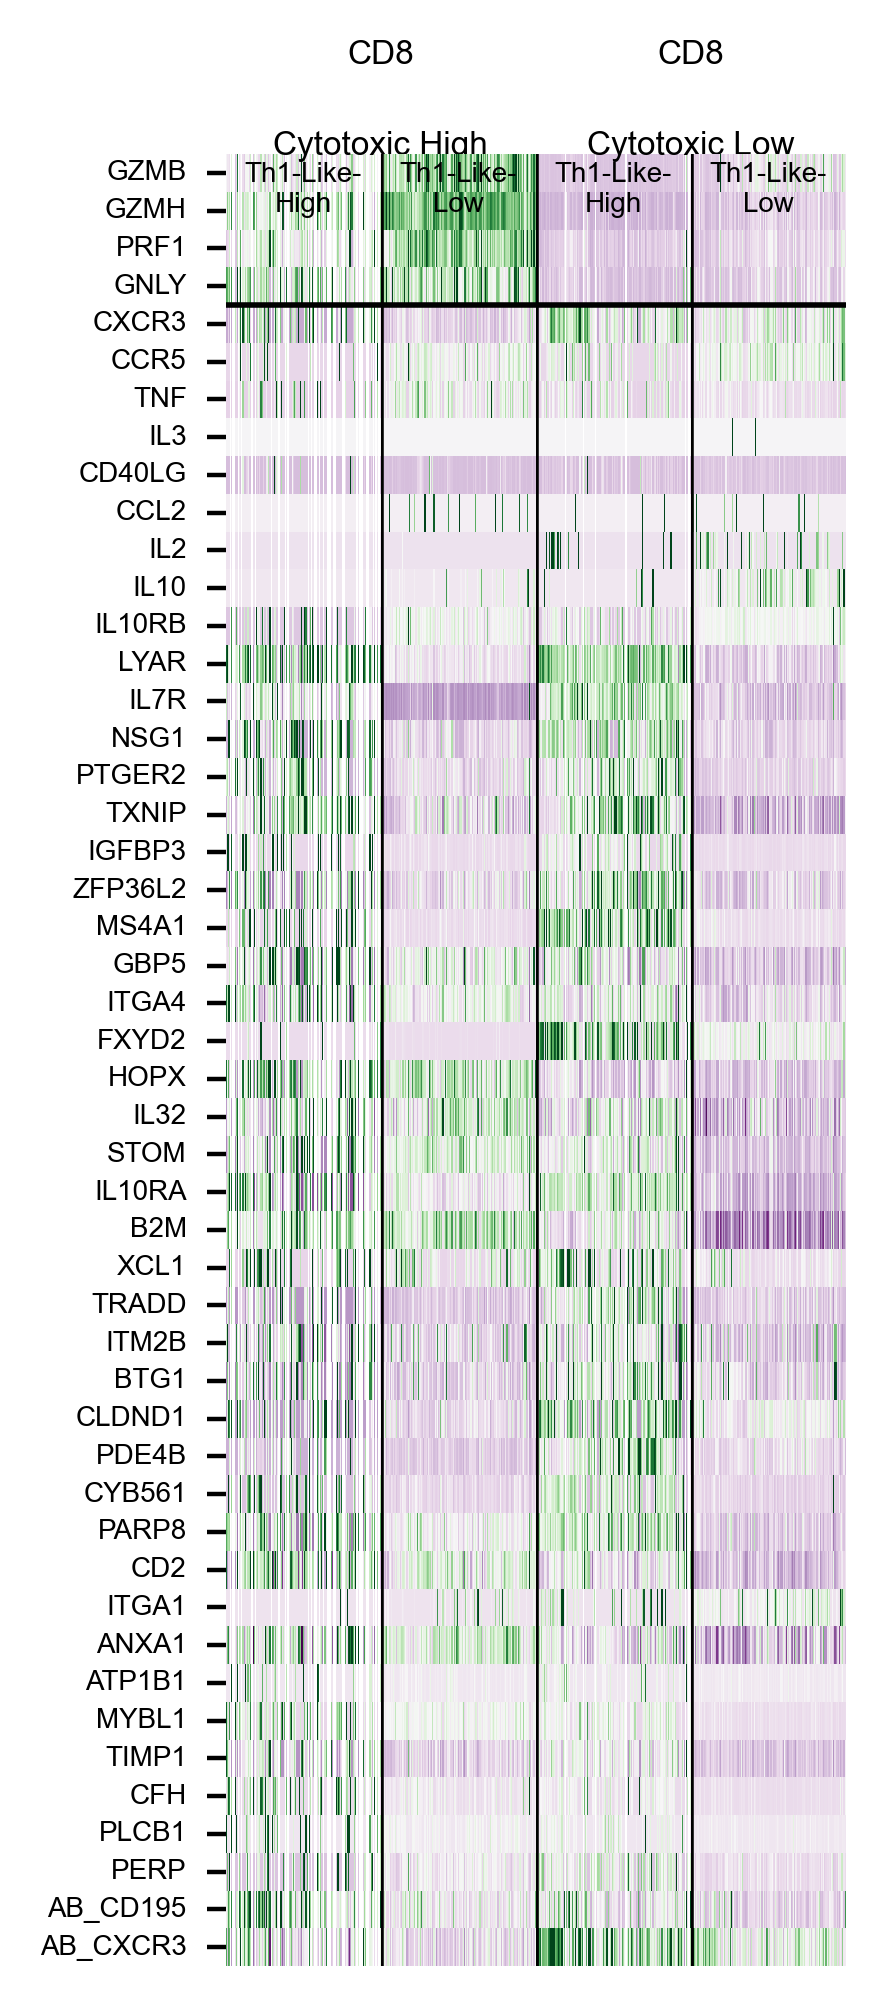

In [594]:
for lineage in ['CD4', 'CD8']:
    nrows = 1
    ncols = 4
    width = 2
    height = 6 
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                             dpi = 400, gridspec_kw = {'wspace' : 0
                                                      })
    # for j, g in enumerate(glist):   
    dat_all = gep_dat[g]
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict['Cytotoxic']
    ms_rna += ms_rna_dict[g]
    ms += ms_rna

    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt

    for class_i, class_bool in enumerate([True, False]):
        for bin_i, bin_bool in enumerate([True, False]):
            ax = axes[2*class_i + bin_i]
            print(g, class_bool, bin_bool, 2*class_i + bin_i)


            dat = dat_all[(dat_all['class']==lineage)&
                (dat_all['Bin_%s' % g]==bin_bool) & (dat_all['Bin_Cytotoxic']==class_bool)]
            sns.heatmap(dat[ms].T, cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                        ax = ax)
            # ax.set_title(label_map[b] % g, fontsize = label_fontsize)

            # if n==0:
            gname=g
            ax.set_title({True: '%s-\nHigh' % gname, False: '%s-\nLow' %gname}[bin_bool], 
                         y = .95, fontsize = tick_fontsize-1)

            if bin_i==0:
                ax.text(1, 1.05, s = lineage, 
                        transform=ax.transAxes, ha = 'center', fontsize = tick_fontsize)

                ax.text(1, 1, s = {True: 'Cytotoxic High', False: 'Cytotoxic Low'}[class_bool], 
                        transform=ax.transAxes, ha = 'center', fontsize = tick_fontsize)
            ax.set_xticks([])
            ax.axhline(4, 0, 4, color = 'black', linewidth = 1)

            if (2*class_i + bin_i)!=0:
                ax.set_yticks([])
                ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 1)
            else:
                ax.set_yticks(np.arange(0.5, len(ms)), ms)
            ax.tick_params('both', labelsize = tick_fontsize-1)

    ax = axes[0]
    if cbar:
        
        cax = ax.inset_axes([-.8, 1.25, .5, .1], transform=ax.transAxes)
        cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
                                cmap=sns.color_palette("PRGn", as_cmap=True)),
                     ax=ax, cax=cax, orientation='horizontal')
        # cbar.outline.set_linewidth(0) 
        cax.set_xticks([vmin, vmax])
        cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
                             '%.1f' % vmax])
        # cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-2)
        cax.tick_params(labelsize=tick_fontsize-2)
        cbar = False



### Filtered genes

In [717]:
sample_order = list(X['sample'].unique())
len(sample_order)

138

In [718]:
ms_rna_dict = {
                'Th1-Like' : ['CXCR3', 'IL10RA', 'LYAR'],
              'Th2-Resting' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Resting' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
               'Treg':['FOXP3', 'IL2RA', 'CTLA4'],
                'Cytotoxic': ['GZMB', 'GZMH', 'PRF1', 'GNLY'],
               'TEMRA' : [#'FCGR3A', 'KLRF1', 'NCR1',

                'KIR2DL3',
                'KLRC2',
                'TYROBP',
                'KIR3DL2'],
               'CD8-EM' : ['CMC1','EOMES',
                    #'DTHD1',
                    'CRTAM',
                    #'LYST',
                    'CD160',
                    ]
    ,
               'gdT' : ['TRDC', 'TRDV2', 'TRGC1'],
     'CD8-Trm' :['ITGA1', 'ZNF683', 'ITGAE']
              }

ms_adt_dict = {'Th1-Like' : [ 'AB_CD195'],
              'Th2-Resting' : ['AB_CD194'],
              'Th2-Activated' : ['AB_CD194'],
              'Treg' : ['AB_CD25', 'AB_CD39'],
              # 'TEMRA' : ['AB_CD45RA'],
              # 'CD8-EM' : ['AB_TIGIT', ],
               'gdT' : ['AB_TCR-Vd2'],
                'CD8-Trm' :['AB_CD69', 'AB_CD103']
}


In [719]:
gep_list = ['TEMRA', 'CD8-EM', 'gdT', 'Th1-Like',
            'CD8-Trm'
           ]

In [720]:
X_test = X

In [721]:
# Pseudobulk and normalize for each thresholded GEP
gep_dat = {}
ms_all = []
ms_all += ms_rna_dict['Cytotoxic']
# ms_rna_all = []
# ms_adt_all = []

for g in gep_list:
    sample_sum = X_test.groupby(['sample', 'Bin_Cytotoxic', 'Bin_%s' % g]).sum().reset_index().dropna()
    sample_sum['Ncell'] = X_test.groupby(['sample', 'Bin_Cytotoxic', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']
        
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict[g]
    ms += ms_rna
    
    ms_rna += ms_rna_dict['Cytotoxic']
    pseudobulk = sample_sum[ms_rna] #+1
    pseudobulk = pseudobulk.multiply(1e4 / sample_sum['N'], axis=0) #.apply(np.log2)
    sample_sum[ms_rna] = pseudobulk
    
    # ms_rna_all += ms_rna
    
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        pseudobulk_adt = sample_sum[ms_adt] #+1
        pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
        sample_sum[ms_adt] = pseudobulk_adt
        ms += ms_adt
        # ms_adt_all += ms_adt

    sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

    dat_all = sample_sum.copy()
    ms_cyto = ms + ms_rna_dict['Cytotoxic']
    dat_all[ms_cyto] = dat_all[ms_cyto].subtract(sample_sum[ms_cyto].mean(), axis =1)
    dat_all[ms_cyto] = dat_all[ms_cyto].divide(sample_sum[ms_cyto].std(), axis = 1)

    gep_dat[g] = dat_all
    ms_all += ms

In [722]:
len(ms_all), len(set(ms_all))

(25, 25)

In [188]:
# # Add normalized data for CD4/CD8 also:

# sample_sum = X_test.groupby(['sample']).sum().reset_index().dropna()
# sample_sum['Ncell'] = X_test.groupby(['sample']).count().reset_index().dropna()['Th1-Like']

# ms_adt = ms_adt_all
# ms_rna = ms_rna_all

# ms = []
# # ms_adt = ['AB_CD4-2', 'AB_CD8']
# pseudobulk_adt = sample_sum[ms_adt] #+1
# pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
# sample_sum[ms_adt] = pseudobulk_adt
# ms += ms_adt

# sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

# dat_all = sample_sum.copy()
# dat_all[ms] = dat_all[ms].subtract(sample_sum[ms].mean(), axis =1)
# dat_all[ms] = dat_all[ms].divide(sample_sum[ms].std(), axis = 1)

# gep_dat['CD4_CD8'] = dat_all
# ms_all += ms

In [755]:
vmax_list = []
# Get vmax using normalized dat and markers
for g in gep_list:
    dat_all = gep_dat[g]    
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict['Cytotoxic']
    ms_rna += ms_rna_dict[g]
    ms += ms_rna
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt
    
    vmax_list += dat_all[ms].unstack().tolist()


vmax = pd.Series(vmax_list).quantile(.98)
vmin = -vmax

In [710]:
vmax

2.573538699150087

In [724]:
label_fontsize = 10
tick_fontsize = 8

In [499]:
4*len(gep_list)

16

In [500]:
[0, 0, 0, .05]*3

[0, 0, 0, 0.05, 0, 0, 0, 0.05, 0, 0, 0, 0.05]

In [725]:
gep_list_test = [['TEMRA'], ['CD8-EM'], ['gdT'], ['Th1-Like'], ['CD8-Trm']]

In [726]:
tick_fontsize = 7
label_fontsize = 9

In [728]:
g

'CD8-Trm'

TEMRA True True Num Samples Filtered: 28
TEMRA True False Num Samples Filtered: 9
TEMRA False True Num Samples Filtered: 54
TEMRA False False Num Samples Filtered: 0
2.5712464332580587
CD8-EM True True Num Samples Filtered: 19
CD8-EM True False Num Samples Filtered: 10
CD8-EM False True Num Samples Filtered: 10
CD8-EM False False Num Samples Filtered: 0
2.5712464332580587
gdT True True Num Samples Filtered: 53
gdT True False Num Samples Filtered: 8
gdT False True Num Samples Filtered: 65
gdT False False Num Samples Filtered: 0
2.5712464332580587
Th1-Like True True Num Samples Filtered: 112
Th1-Like True False Num Samples Filtered: 8
Th1-Like False True Num Samples Filtered: 19
Th1-Like False False Num Samples Filtered: 0
2.5712464332580587
CD8-Trm True True Num Samples Filtered: 104
CD8-Trm True False Num Samples Filtered: 8
CD8-Trm False True Num Samples Filtered: 91
CD8-Trm False False Num Samples Filtered: 0
2.5712464332580587


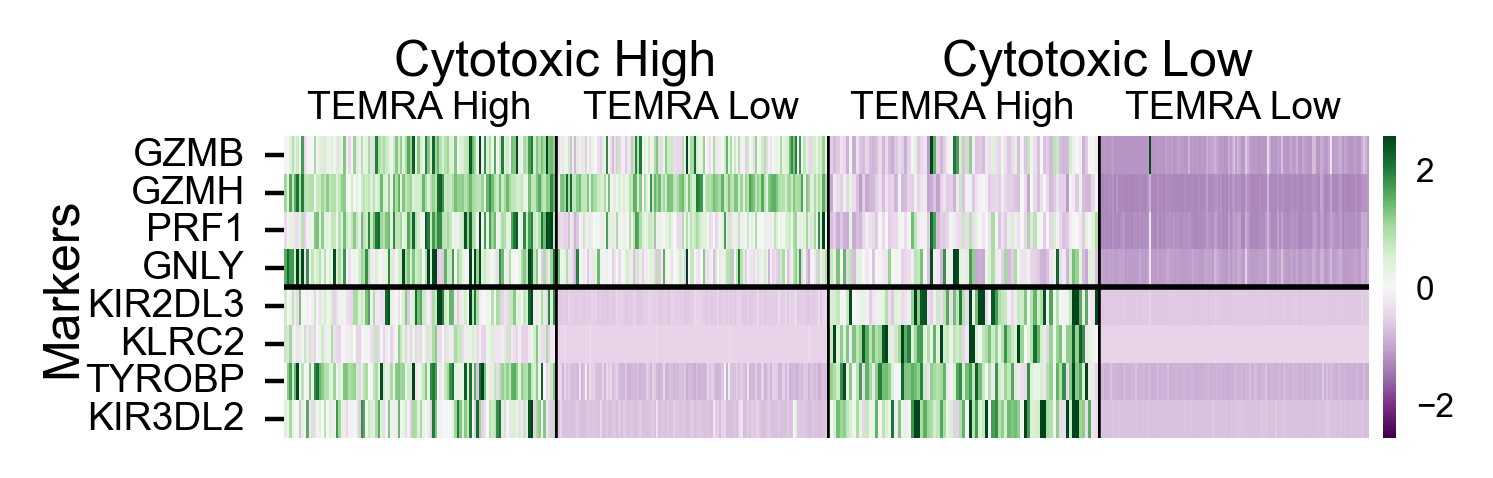

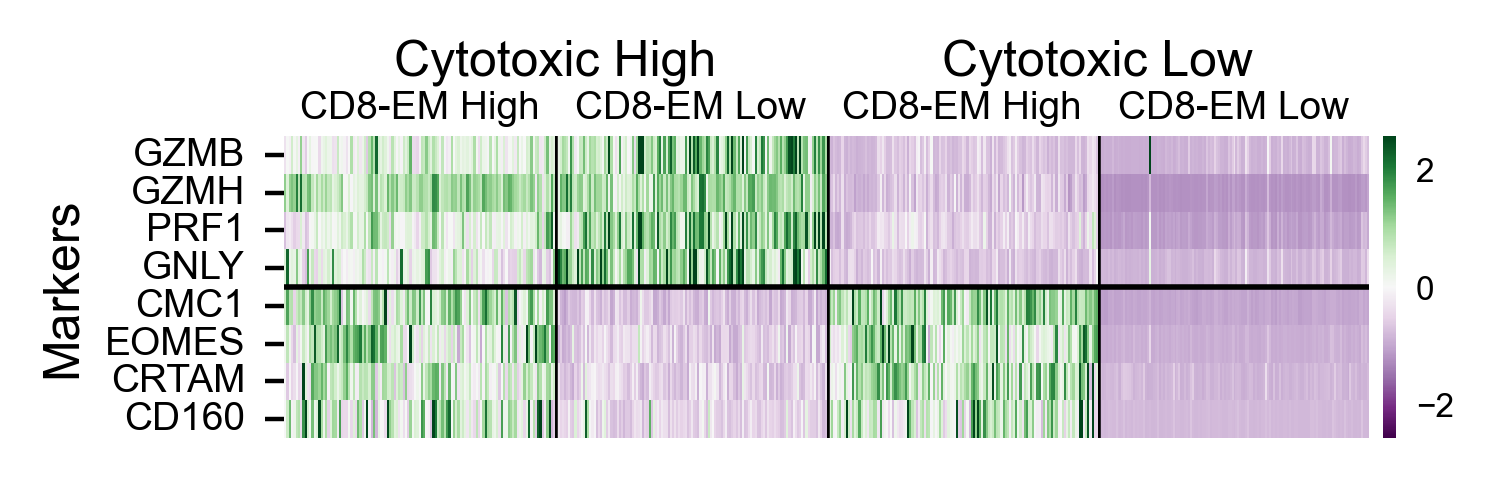

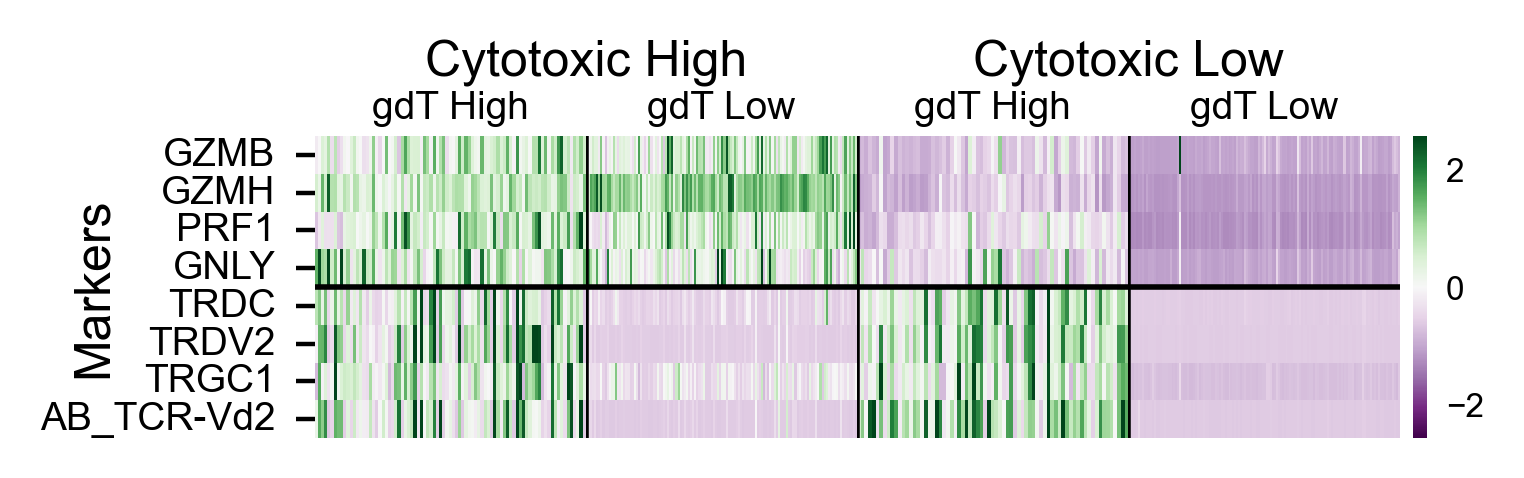

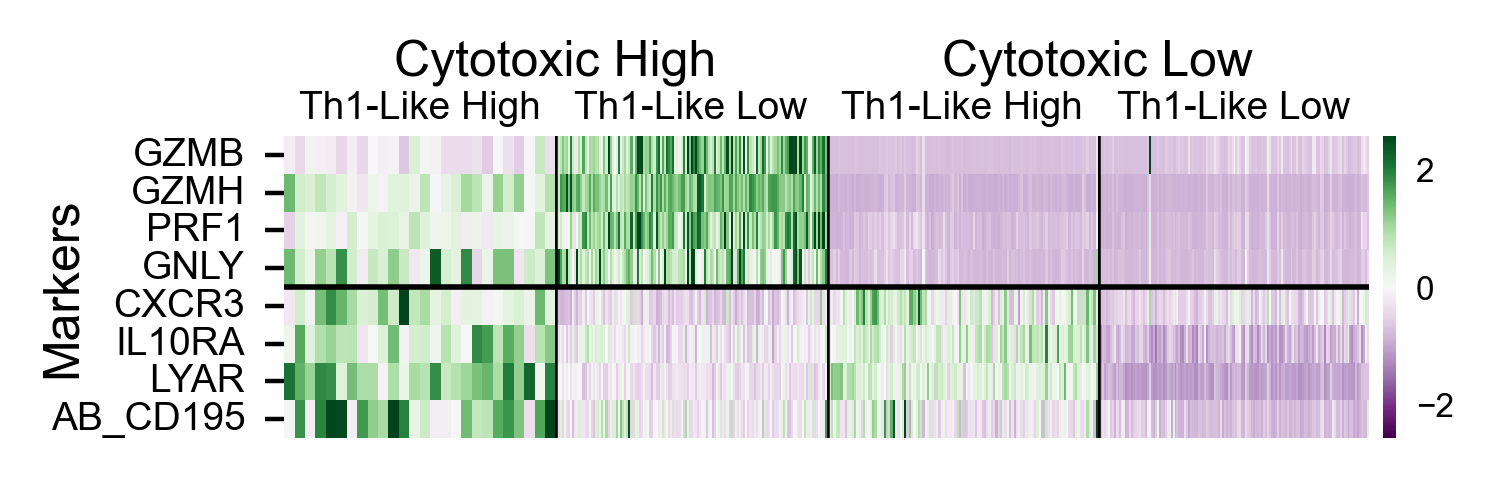

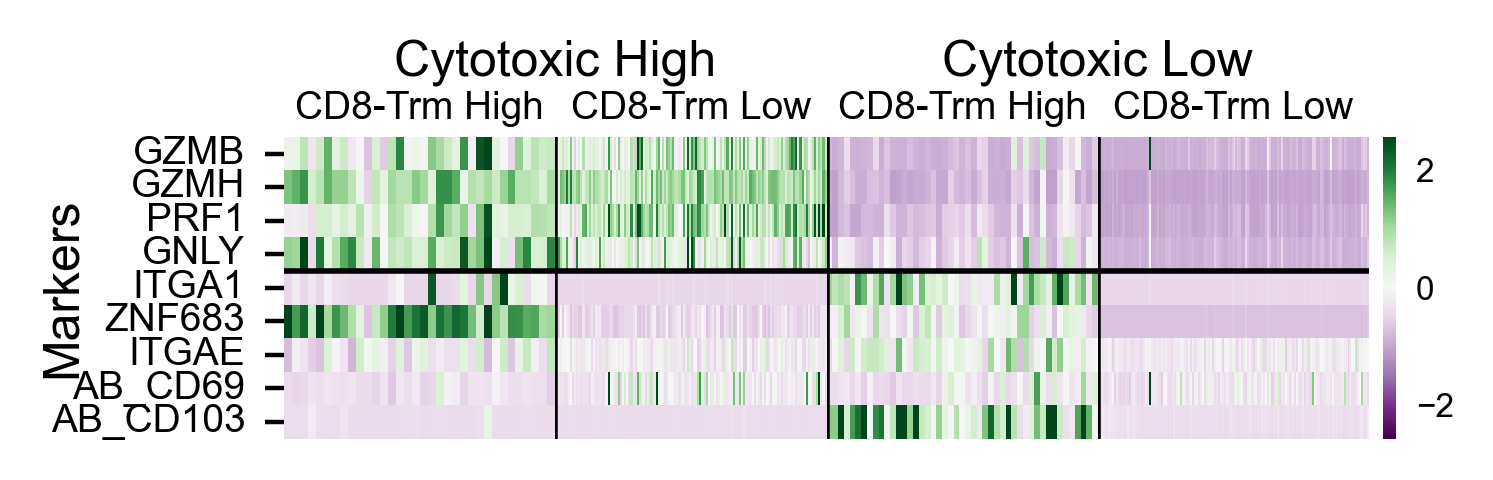

In [785]:
cbar = True
for g in gep_list:
    nrows = 1
    ncols = 4
    width = 3.5
    height = 1    
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                             dpi = 400, gridspec_kw = {'wspace' : 0
                                                      })
    # for j, g in enumerate(glist):   
    dat_all = gep_dat[g]
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict['Cytotoxic']
    ms_rna += ms_rna_dict[g]
    ms += ms_rna

    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt

    for class_i, class_bool in enumerate([True, False]):
        for bin_i, bin_bool in enumerate([True, False]):
            ax = axes[2*class_i + bin_i]
            # print(g, class_bool, bin_bool, 2*class_i + bin_i)


            dat = dat_all[(dat_all['Bin_%s' % g]==bin_bool) & (dat_all['Bin_Cytotoxic']==class_bool)]
            print(g, class_bool, bin_bool, 'Num Samples Filtered: %i' % dat[dat['Ncell']<min_cells].shape[0])
            dat = dat[dat['Ncell'] >= min_cells]
                        
            sns.heatmap(dat[ms].T, cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                        ax = ax)
            # ax.set_title(label_map[b] % g, fontsize = label_fontsize)

            # if n==0:
            gname=g
            ax.set_title({True: '%s High' % gname, False: '%s Low' %gname}[bin_bool], 
                         y = .95, fontsize = tick_fontsize)

            if bin_i==0:
                ax.text(1, 1.2, s = {True: 'Cytotoxic High', False: 'Cytotoxic Low'}[class_bool], 
                        transform=ax.transAxes, ha = 'center', fontsize = label_fontsize)
            ax.set_xticks([])


            ax.axhline(4, 0, 4, color = 'black', linewidth = 1)

            if (2*class_i + bin_i)!=0:
                ax.set_yticks([])
                ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 1)
            else:
                ax.set_yticks(np.arange(0.5, len(ms)), ms)
                
                ax.text(-.9, 0.5, 'Markers', rotation = 90,
                        transform=ax.transAxes, va = 'center', fontsize = label_fontsize)
                
                # ax.set_ylabel('Markers', size = label_fontsize, position=(-1,0.5))
            ax.tick_params('both', labelsize = tick_fontsize)

            # ax = axes[0]
    if cbar:

        # cax = ax.inset_axes([-.8, 1.25, .5, .1], transform=ax.transAxes)
        # cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
        #                         cmap=sns.color_palette("PRGn", as_cmap=True)),
        #              ax=ax, cax=cax, orientation='horizontal')
        # # cbar.outline.set_linewidth(0) 
        # cax.set_xticks([vmin, vmax])
        # cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
        #                      '%.1f' % vmax])
        # # cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-2)
        # cax.tick_params(labelsize=tick_fontsize-2)
        # cbar = False

        print(vmax)
        cax = ax.inset_axes([1.05, 0, .05, 1], transform=ax.transAxes)
        cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
                                    cmap=sns.color_palette("PRGn", as_cmap=True)),
                     ax=ax, cax=cax, orientation='vertical')
        cbar.outline.set_linewidth(0) 
        cax.tick_params(labelsize=tick_fontsize-1, length=0)
        cbar = True

    # plt.show()

    plt.savefig(os.path.join(figdir, 'HeatmapCytotoxicMarkers_%s.COMBAT.png' % g), bbox_inches="tight")
    plt.savefig(os.path.join(figdir, 'HeatmapCytotoxicMarkers_%s.COMBAT.pdf' % g), bbox_inches="tight")

TEMRA True True Num Samples Filtered: 28
TEMRA True False Num Samples Filtered: 9
TEMRA False True Num Samples Filtered: 54
TEMRA False False Num Samples Filtered: 0
CD8-EM True True Num Samples Filtered: 19
CD8-EM True False Num Samples Filtered: 10
CD8-EM False True Num Samples Filtered: 10
CD8-EM False False Num Samples Filtered: 0
gdT True True Num Samples Filtered: 53
gdT True False Num Samples Filtered: 8
gdT False True Num Samples Filtered: 65
gdT False False Num Samples Filtered: 0
Th1-Like True True Num Samples Filtered: 112
Th1-Like True False Num Samples Filtered: 8
Th1-Like False True Num Samples Filtered: 19
Th1-Like False False Num Samples Filtered: 0
CD8-Trm True True Num Samples Filtered: 104
CD8-Trm True False Num Samples Filtered: 8
CD8-Trm False True Num Samples Filtered: 91
CD8-Trm False False Num Samples Filtered: 0


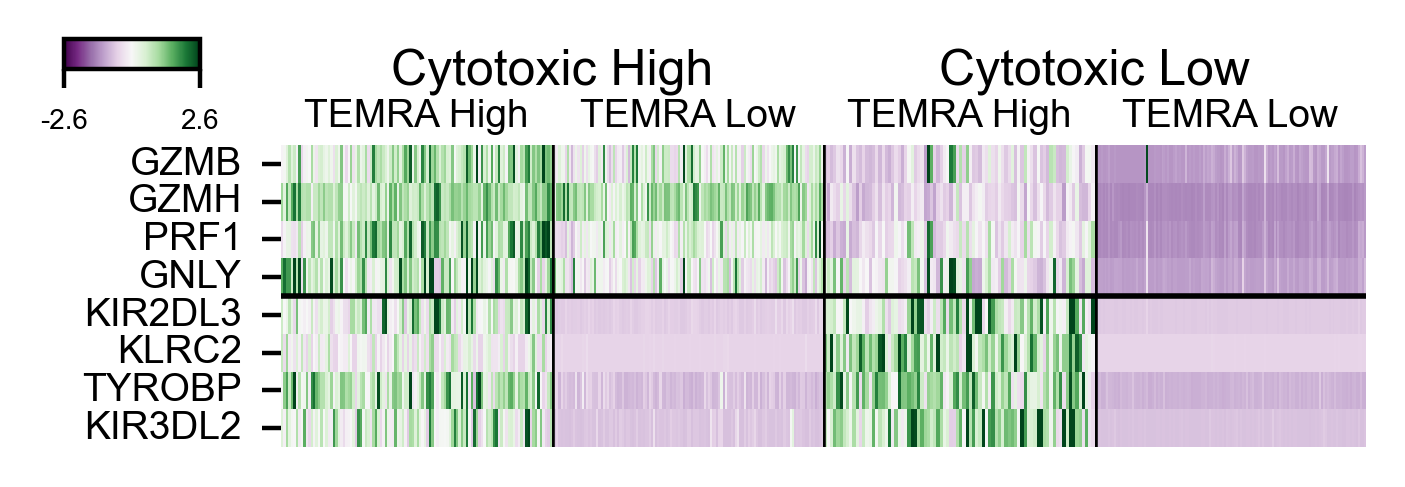

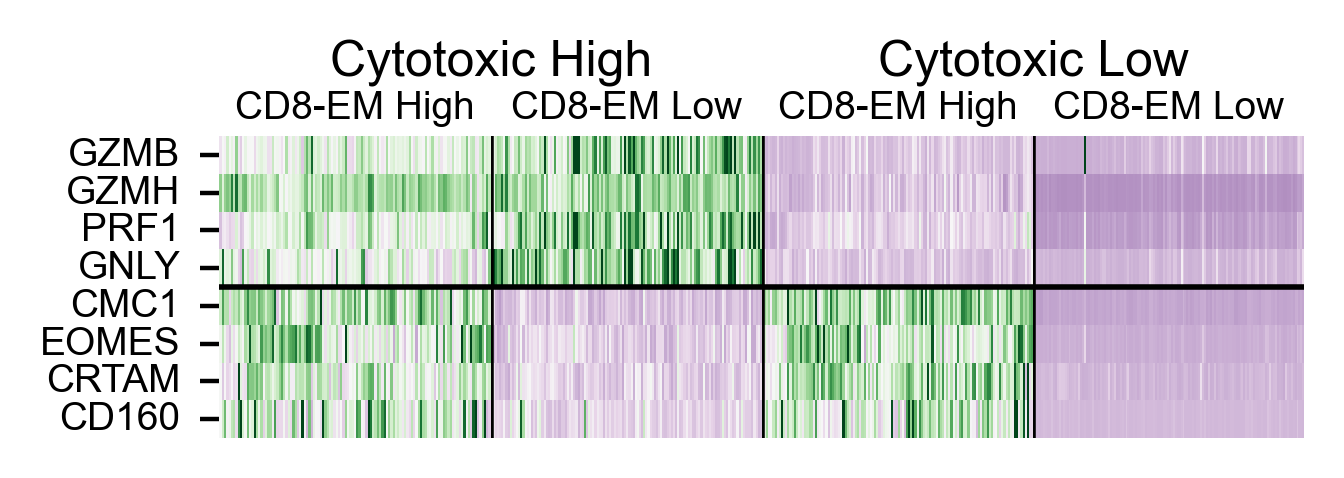

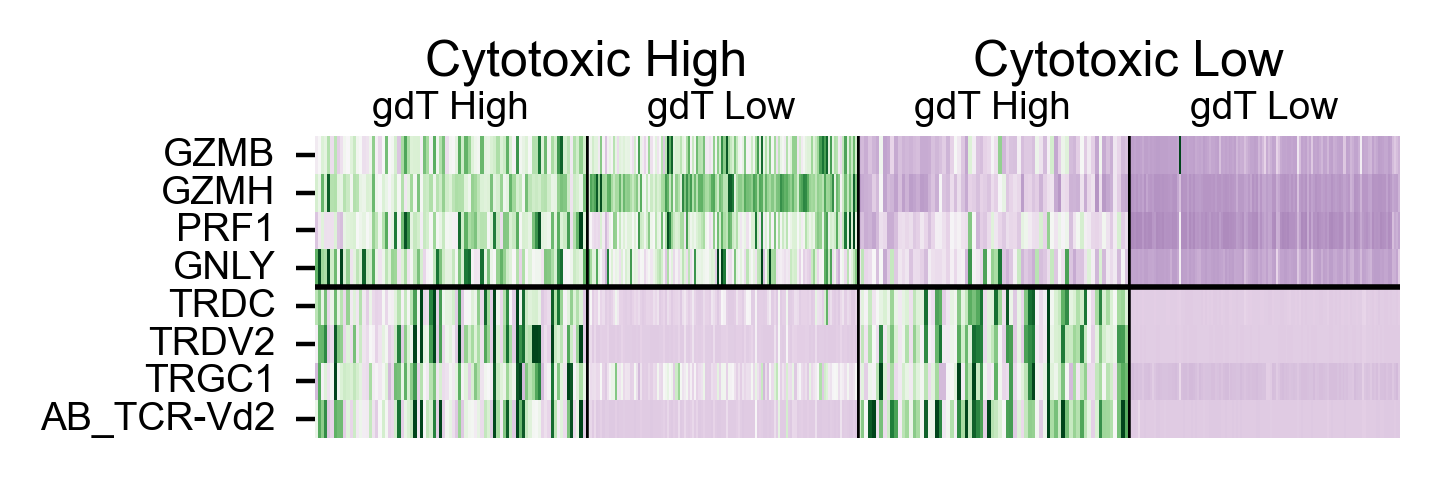

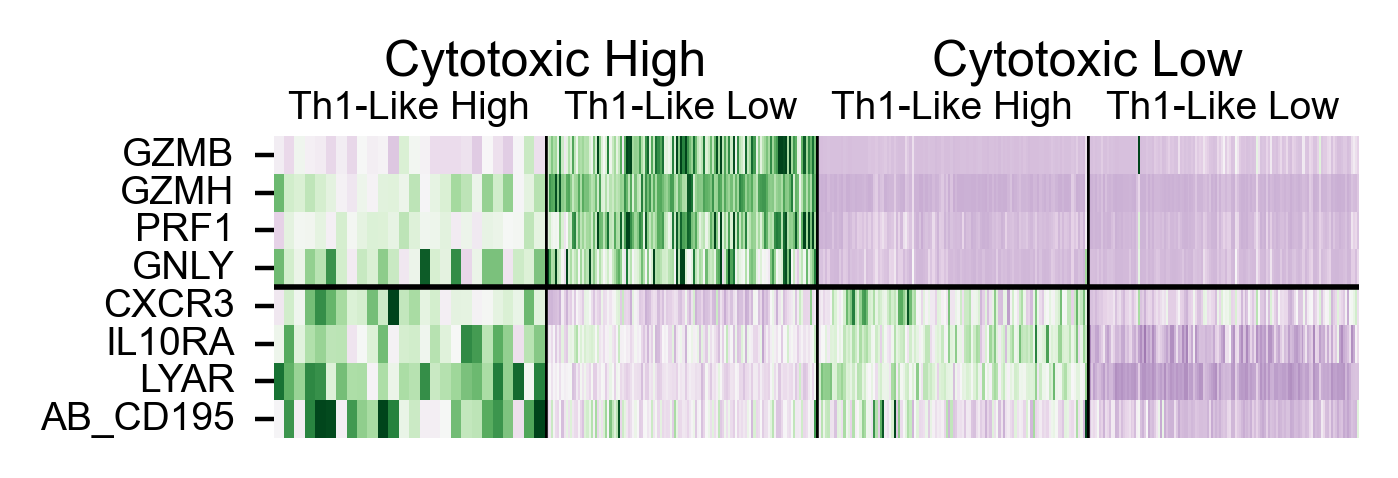

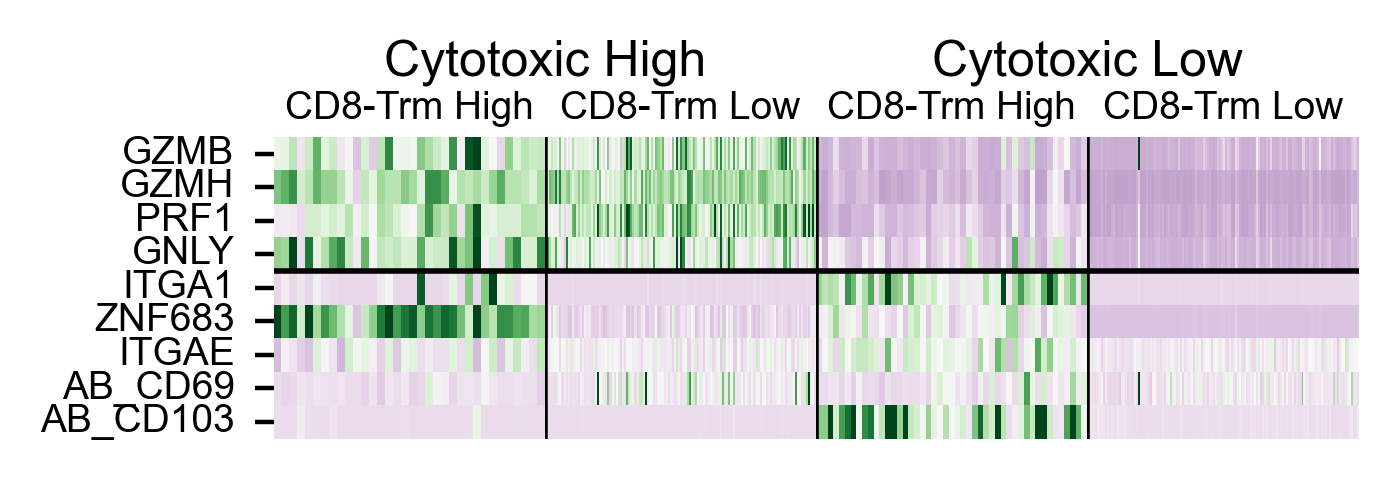

In [715]:
'''cbar = True
for g in gep_list:
    nrows = 1
    ncols = 4
    width = 3.5
    height = 1    
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                             dpi = 400, gridspec_kw = {'wspace' : 0
                                                      })
    # for j, g in enumerate(glist):   
    dat_all = gep_dat[g]
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict['Cytotoxic']
    ms_rna += ms_rna_dict[g]
    ms += ms_rna

    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt

    for class_i, class_bool in enumerate([True, False]):
        for bin_i, bin_bool in enumerate([True, False]):
            ax = axes[2*class_i + bin_i]
            # print(g, class_bool, bin_bool, 2*class_i + bin_i)


            dat = dat_all[(dat_all['Bin_%s' % g]==bin_bool) & (dat_all['Bin_Cytotoxic']==class_bool)]
            print(g, class_bool, bin_bool, 'Num Samples Filtered: %i' % dat[dat['Ncell']<min_cells].shape[0])
            dat = dat[dat['Ncell'] >= min_cells]
            
            sns.heatmap(dat[ms].T, cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                        ax = ax)
            # ax.set_title(label_map[b] % g, fontsize = label_fontsize)

            # if n==0:
            gname=g
            ax.set_title({True: '%s High' % gname, False: '%s Low' %gname}[bin_bool], 
                         y = .95, fontsize = tick_fontsize)

            if bin_i==0:
                ax.text(1, 1.2, s = {True: 'Cytotoxic High', False: 'Cytotoxic Low'}[class_bool], 
                        transform=ax.transAxes, ha = 'center', fontsize = label_fontsize)
            ax.set_xticks([])



            ax.axhline(4, 0, 4, color = 'black', linewidth = 1)

            if (2*class_i + bin_i)!=0:
                ax.set_yticks([])
                ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 1)
            else:
                ax.set_yticks(np.arange(0.5, len(ms)), ms)
            ax.tick_params('both', labelsize = tick_fontsize)

    ax = axes[0]
    if cbar:
        
        cax = ax.inset_axes([-.8, 1.25, .5, .1], transform=ax.transAxes)
        cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
                                cmap=sns.color_palette("PRGn", as_cmap=True)),
                     ax=ax, cax=cax, orientation='horizontal')
        # cbar.outline.set_linewidth(0) 
        cax.set_xticks([vmin, vmax])
        cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
                             '%.1f' % vmax])
        # cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-2)
        cax.tick_params(labelsize=tick_fontsize-2)
        cbar = False



# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers.COMBAT.png'), bbox_inches="tight")
# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers.COMBAT.pdf'), bbox_inches="tight")'''

### Filtered genes - CD4/CD8 split

In [564]:
sample_order = list(X['sample'].unique())
len(sample_order)

138

In [565]:
ms_rna_dict = {
                'Th1-Like' : ['CXCR3', 'IL10RA'],
              'Th2-Resting' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Resting' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
               'Treg':['FOXP3', 'IL2RA', 'CTLA4'],
                'Cytotoxic': ['GZMB', 'GZMH', 'PRF1', 'GNLY'],
               'TEMRA' : [#'FCGR3A', 'KLRF1', 'NCR1',

                'KIR2DL3',
                'KLRC2',
                'TYROBP',
                'KIR3DL2'],
               'CD8-EM' : ['CMC1','EOMES',
                    'DTHD1',
                    'CRTAM',
                    'LYST',
                    'CD160',
                    ]
    ,
               'gdT' : ['TRDC', 'TRDV2', 'TRGC1'],
              }

ms_adt_dict = {'Th1-Like' : [ 'AB_CD195'],
              'Th2-Resting' : ['AB_CD194'],
              'Th2-Activated' : ['AB_CD194'],
              'Treg' : ['AB_CD25', 'AB_CD39'],
              # 'TEMRA' : ['AB_CD45RA'],
              # 'CD8-EM' : ['AB_TIGIT', ],
               'gdT' : ['AB_TCR-Vd2']
}


In [566]:
gep_list = ['TEMRA', 'CD8-EM', 'gdT', 'Th1-Like'
            #'CD8-Trm'
           ]

In [567]:
X_test = X[(X['class'].isin(['CD4', 'CD8']))]


In [568]:
# Pseudobulk and normalize for each thresholded GEP
gep_dat = {}
ms_all = []
ms_all += ms_rna_dict['Cytotoxic']
# ms_rna_all = []
# ms_adt_all = []

for g in gep_list:
    sample_sum = X_test.groupby(['sample', 'class', 'Bin_Cytotoxic', 'Bin_%s' % g]).sum().reset_index().dropna()
    sample_sum['Ncell'] = X_test.groupby(['sample','class', 'Bin_Cytotoxic', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']
        
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict[g]
    ms += ms_rna
    
    ms_rna += ms_rna_dict['Cytotoxic']
    pseudobulk = sample_sum[ms_rna] #+1
    pseudobulk = pseudobulk.multiply(1e4 / sample_sum['N'], axis=0) #.apply(np.log2)
    sample_sum[ms_rna] = pseudobulk
    
    # ms_rna_all += ms_rna
    
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        pseudobulk_adt = sample_sum[ms_adt] #+1
        pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
        sample_sum[ms_adt] = pseudobulk_adt
        ms += ms_adt
        # ms_adt_all += ms_adt

    sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

    dat_all = sample_sum.copy()
    ms_cyto = ms + ms_rna_dict['Cytotoxic']
    dat_all[ms_cyto] = dat_all[ms_cyto].subtract(sample_sum[ms_cyto].mean(), axis =1)
    dat_all[ms_cyto] = dat_all[ms_cyto].divide(sample_sum[ms_cyto].std(), axis = 1)

    gep_dat[g] = dat_all
    ms_all += ms

In [479]:
len(ms_all), len(set(ms_all))

(23, 23)

In [188]:
# # Add normalized data for CD4/CD8 also:

# sample_sum = X_test.groupby(['sample']).sum().reset_index().dropna()
# sample_sum['Ncell'] = X_test.groupby(['sample']).count().reset_index().dropna()['Th1-Like']

# ms_adt = ms_adt_all
# ms_rna = ms_rna_all

# ms = []
# # ms_adt = ['AB_CD4-2', 'AB_CD8']
# pseudobulk_adt = sample_sum[ms_adt] #+1
# pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
# sample_sum[ms_adt] = pseudobulk_adt
# ms += ms_adt

# sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

# dat_all = sample_sum.copy()
# dat_all[ms] = dat_all[ms].subtract(sample_sum[ms].mean(), axis =1)
# dat_all[ms] = dat_all[ms].divide(sample_sum[ms].std(), axis = 1)

# gep_dat['CD4_CD8'] = dat_all
# ms_all += ms

In [569]:
vmax_list = []
# Get vmax using normalized dat and markers
for g in gep_list:
    dat_all = gep_dat[g]    
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict['Cytotoxic']
    ms_rna += ms_rna_dict[g]
    ms += ms_rna
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt
    
    vmax_list += dat_all[ms].unstack().tolist()


vmax = pd.Series(vmax_list).quantile(.98)
vmin = -vmax

In [570]:
vmax

2.6026068544387693

In [498]:
label_fontsize = 10
tick_fontsize = 8

In [499]:
4*len(gep_list)

16

In [500]:
[0, 0, 0, .05]*3

[0, 0, 0, 0.05, 0, 0, 0, 0.05, 0, 0, 0, 0.05]

In [501]:
gep_list_test = [['TEMRA'], ['CD8-EM'], ['gdT'], ['Th1-Like']]

In [524]:
tick_fontsize = 6
label_fontsize = 8

In [ ]:
for lineage in ['CD4', 'CD8']:

In [573]:
g = 'Th1-Like'
dat_all = gep_dat[g]


In [577]:
lineage='CD8'

In [578]:
dat_all[dat_all['class']==lineage]

,sample,class,Bin_Cytotoxic,Bin_Th1-Like,Th1-Like,Treg,Th2-Resting,Th17-Resting,Th22,Th2-Activated,...,ZFP36L2,CCL2,CD40LG,IL2,IL3,TNF,IL10,IL10RB,TRDV2,Ncell
4,G05061-Ja005,CD8,False,False,0.023059,0.010147,0.012744,0.009001,0.009418,0.004364,...,213.0,0.0,11.0,2.0,0.0,18.0,0.0,19.0,3.0,425
5,G05061-Ja005,CD8,False,True,0.149584,0.008516,0.009099,0.011561,0.010385,0.002674,...,54.0,0.0,1.0,0.0,0.0,7.0,0.0,2.0,0.0,61
6,G05061-Ja005,CD8,True,False,0.013544,0.007531,0.004528,0.004346,0.004486,0.002795,...,58.0,0.0,1.0,0.0,0.0,4.0,0.0,9.0,0.0,188
7,G05061-Ja005,CD8,True,True,0.135959,0.003344,0.014307,0.018730,0.005499,0.012321,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
12,G05064-Ja005,CD8,False,False,0.016442,0.007830,0.012235,0.010338,0.006764,0.004503,...,953.0,0.0,15.0,0.0,0.0,6.0,6.0,56.0,2.0,1119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,U00619-Ua005,CD8,True,True,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1100,U00701-Ua005,CD8,False,False,0.038884,0.004598,0.014796,0.007864,0.010033,0.003175,...,30.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,57
1101,U00701-Ua005,CD8,False,True,0.182158,0.006442,0.009945,0.006861,0.012101,0.008471,...,15.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,13
1102,U00701-Ua005,CD8,True,False,0.026718,0.004062,0.009115,0.005286,0.011635,0.002219,...,133.0,0.0,2.0,0.0,0.0,6.0,0.0,12.0,0.0,250


Th1-Like True True 0
Th1-Like True False 1
Th1-Like False True 2
Th1-Like False False 3
Th1-Like True True 0
Th1-Like True False 1
Th1-Like False True 2
Th1-Like False False 3


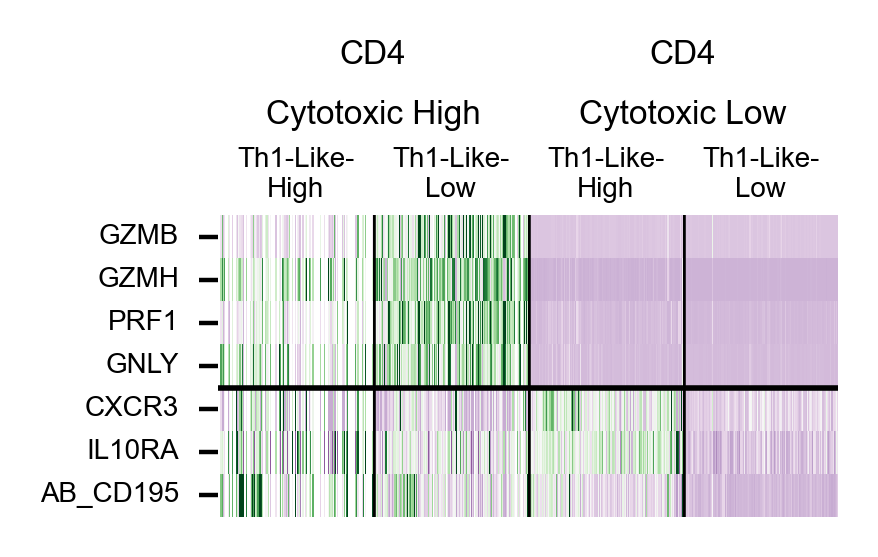

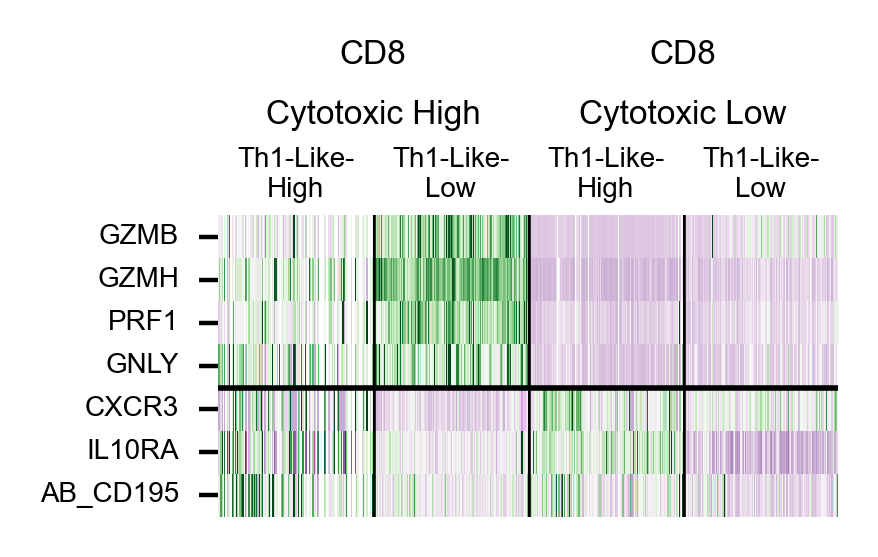

In [580]:
for lineage in ['CD4', 'CD8']:
    nrows = 1
    ncols = 4
    width = 2
    height = 1    
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                             dpi = 400, gridspec_kw = {'wspace' : 0
                                                      })
    # for j, g in enumerate(glist):   
    dat_all = gep_dat[g]
    ms = []
    ms_rna = []
    ms_rna += ms_rna_dict['Cytotoxic']
    ms_rna += ms_rna_dict[g]
    ms += ms_rna

    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt

    for class_i, class_bool in enumerate([True, False]):
        for bin_i, bin_bool in enumerate([True, False]):
            ax = axes[2*class_i + bin_i]
            print(g, class_bool, bin_bool, 2*class_i + bin_i)


            dat = dat_all[(dat_all['class']==lineage)&
                (dat_all['Bin_%s' % g]==bin_bool) & (dat_all['Bin_Cytotoxic']==class_bool)]
            sns.heatmap(dat[ms].T, cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                        ax = ax)
            # ax.set_title(label_map[b] % g, fontsize = label_fontsize)

            # if n==0:
            gname=g
            ax.set_title({True: '%s-\nHigh' % gname, False: '%s-\nLow' %gname}[bin_bool], 
                         y = .95, fontsize = tick_fontsize-1)

            if bin_i==0:
                ax.text(1, 1.5, s = lineage, 
                        transform=ax.transAxes, ha = 'center', fontsize = tick_fontsize)

                ax.text(1, 1.3, s = {True: 'Cytotoxic High', False: 'Cytotoxic Low'}[class_bool], 
                        transform=ax.transAxes, ha = 'center', fontsize = tick_fontsize)
            ax.set_xticks([])
            ax.axhline(4, 0, 4, color = 'black', linewidth = 1)

            if (2*class_i + bin_i)!=0:
                ax.set_yticks([])
                ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 1)
            else:
                ax.set_yticks(np.arange(0.5, len(ms)), ms)
            ax.tick_params('both', labelsize = tick_fontsize-1)

    ax = axes[0]
    if cbar:
        
        cax = ax.inset_axes([-.8, 1.25, .5, .1], transform=ax.transAxes)
        cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
                                cmap=sns.color_palette("PRGn", as_cmap=True)),
                     ax=ax, cax=cax, orientation='horizontal')
        # cbar.outline.set_linewidth(0) 
        cax.set_xticks([vmin, vmax])
        cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
                             '%.1f' % vmax])
        # cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-2)
        cax.tick_params(labelsize=tick_fontsize-2)
        cbar = False



## All genes

In [255]:
sample_order = list(X['sample'].unique())
len(sample_order)

138

In [256]:
X_test = X #X[(X['Cytotoxic'] <= thresh)]

In [ ]:
# X_test_nocyto = X[(X['Cytotoxic'] <= thresh)]

In [257]:
gep_list = ['CD8-EM', 'Th1-Like', 'TEMRA', 'Th17-Resting', 'Treg']

In [267]:
thresh = 0.1#0.0625

for g in gep_list:
    X['Bin_%s' % g] = X[g]>thresh

In [506]:
pd.crosstab((usage_norm['Treg']>0.1), usage_norm['Cytotoxic']>0.1)

Cytotoxic,False,True
Treg,,
False,322225,59232
True,18089,53


In [507]:
pd.crosstab((usage_norm['Th17-Resting']>0.1), usage_norm['Cytotoxic']>0.1)

Cytotoxic,False,True
Th17-Resting,,
False,318991,59248
True,21323,37


In [512]:
pd.crosstab((usage_norm['Th1-Like']>0.1), usage_norm['Cytotoxic']>0.1)

Cytotoxic,False,True
Th1-Like,,
False,320636,57141
True,19678,2144


In [508]:
pd.crosstab((usage_norm['Th17-Resting']>0.1), usage_norm['Th2-Resting']>0.1)

Th2-Resting,False,True
Th17-Resting,,
False,358280,19959
True,20380,980


In [511]:
pd.crosstab((usage_norm['Th17-Resting']>0.1), usage_norm['ISG']>0.1)

ISG,False,True
Th17-Resting,,
False,356992,21247
True,19776,1584


In [ ]:
ms_rna_dict = {'Th1-Like' : ['CXCR3',#'IFNG-AS1',
                             'IFNG', 'TBX21'],
              'Th2-Resting' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Resting' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
               
               'Treg':['FOXP3', 'IL2RA', 'CTLA4'],
                'Cytotoxic': ['GZMB', 'GZMK', 'GZMH', 'PRF1', 'GNLY'],
               'TEMRA' : ['FCGR3A', 'KLRF1', 'NCR1', 'PRF1'],
               'CD8-EM' : ['GZMK', 'CXCR3'],
              }

ms_adt_dict = {'Th1-Like' : [ 'AB_CD195',],
              'Th2-Resting' : ['AB_CD194'],
              'Th2-Activated' : ['AB_CD194'],
              'Treg' : ['AB_CD25', 'AB_CD39'],
              'TEMRA' : ['AB_CD45RA'],
              'CD8-EM' : ['AB_CD8', 'AB_CD45RO'],
}


In [ ]:
ms_ordered = 

In [191]:
list(Z_spec.loc['TEMRA', :].sort_values(ascending= False).index).index('CX3CR1')

20200

In [192]:
list(Z_spec.loc['TEMRA', :].sort_values(ascending= False).index).index('FCGR3A')

20

In [193]:
list(Z_spec.loc['TEMRA', :].sort_values(ascending= False).index).index('FGFBP2')

20396

In [200]:
list(Z_spec.loc['CD8-EM', :].sort_values(ascending= False).index).index('CXCR3')

957

In [181]:
Z_spec.loc['CD8-EM', :].sort_values(ascending= False).head(50)

CMC1             0.011686
GZMK             0.009678
AB_CD244         0.007998
CST7             0.007550
CCL5             0.006828
AB_TIGIT         0.006445
EOMES            0.006148
CD8A             0.006125
AB_CD8a          0.006124
CD8B             0.005828
AB_KLRG1_MAFA    0.005820
GZMM             0.005732
SH2D1A           0.005632
AB_CD8           0.005575
DUSP2            0.005362
DTHD1            0.005328
KLRG1            0.005261
CRTAM            0.005073
LYST             0.005027
CD160            0.005022
GZMA             0.004891
NKG7             0.004869
AOAH             0.004703
CCL3L1           0.004597
PLEK             0.004540
XCL2             0.004423
HLA-DPB1         0.004411
FCRL3            0.004364
AB_CD81          0.004349
ENC1             0.004308
CD74             0.004165
PECAM1           0.004087
AB_CD54          0.004086
AB_CD314         0.003987
HLA-DPA1         0.003920
CTSW             0.003919
APMAP            0.003901
HCST             0.003851
SLAMF7      

In [180]:
Z_spec.loc['CD8-EM', :].sort_values(ascending= False).head(100).tail(50)

AB_CD11a     0.003040
AB_CD31      0.002981
HLA-B        0.002980
CD81         0.002963
B2M          0.002961
LITAF        0.002941
HLA-C        0.002936
APOBEC3G     0.002920
PYHIN1       0.002877
LINC02084    0.002874
YBX3         0.002868
HLA-DRB1     0.002850
PDLIM1       0.002842
PTGDR        0.002799
PTPRC        0.002797
AB_CD18      0.002751
TNFRSF9      0.002718
HLA-DQA1     0.002668
KLRD1        0.002654
CCL4L2       0.002650
PLAAT4       0.002634
F2R          0.002632
CTSC         0.002608
PIK3R1       0.002590
CLEC2B       0.002585
AB_CD279     0.002556
VCAM1        0.002551
ARPC5L       0.002549
TOX          0.002540
TRGC2        0.002538
MATK         0.002516
PLA2G16      0.002494
AB_CD195     0.002462
HLA-DQA2     0.002441
TNFSF9       0.002338
ZBTB38       0.002338
RAB27A       0.002317
HLA-DMA      0.002308
PLAAT3       0.002308
MAP3K8       0.002292
GZMH         0.002292
DKK3         0.002281
GUK1         0.002269
OAZ1         0.002258
HLA-E        0.002235
KLRF1     

In [ ]:
'KLRF1', 'NCR1'

In [179]:
Z_spec.loc['CD8-EM', :].sort_values(ascending= False).head(50)

CMC1             0.011686
GZMK             0.009678
AB_CD244         0.007998
CST7             0.007550
CCL5             0.006828
AB_TIGIT         0.006445
EOMES            0.006148
CD8A             0.006125
AB_CD8a          0.006124
CD8B             0.005828
AB_KLRG1_MAFA    0.005820
GZMM             0.005732
SH2D1A           0.005632
AB_CD8           0.005575
DUSP2            0.005362
DTHD1            0.005328
KLRG1            0.005261
CRTAM            0.005073
LYST             0.005027
CD160            0.005022
GZMA             0.004891
NKG7             0.004869
AOAH             0.004703
CCL3L1           0.004597
PLEK             0.004540
XCL2             0.004423
HLA-DPB1         0.004411
FCRL3            0.004364
AB_CD81          0.004349
ENC1             0.004308
CD74             0.004165
PECAM1           0.004087
AB_CD54          0.004086
AB_CD314         0.003987
HLA-DPA1         0.003920
CTSW             0.003919
APMAP            0.003901
HCST             0.003851
SLAMF7      

In [196]:
Z_spec.loc['TEMRA', :].sort_values(ascending= False).head(50)

KIR2DL3       0.012515
KLRC2         0.011788
TYROBP        0.011444
KIR3DL2       0.011124
KLRC3         0.010217
KIR3DL1       0.009525
KIR2DL1       0.009099
AB_CD158b     0.008784
SH2D1B        0.008723
KIR2DL4       0.007440
KLRF1         0.007282
NCR1          0.006758
AB_CD158      0.006372
LAT2          0.006244
AB_CD158e1    0.006050
TRDV1         0.005901
AB_CD56-1     0.005793
TRDC          0.005636
NCAM1         0.005615
FCER1G        0.005611
FCGR3A        0.005589
CTSW          0.005586
AB_CD16       0.005564
ITGAD         0.005449
GNLY          0.005369
IKZF2         0.005227
AB_CD45RA     0.005129
AB_CD335      0.004935
ITGAX         0.004798
CD63          0.004688
AB_CD244      0.004532
KLRD1         0.004466
NCR3          0.004283
CD7           0.004264
AB_CD328      0.004138
SPRY2         0.004120
PRSS57        0.004092
B3GNT7        0.003992
AOAH          0.003985
IFITM2        0.003966
AB_CD94       0.003945
TRGC2         0.003916
SOST          0.003787
TRG-AS1    

In [194]:
Z_spec.loc['TEMRA', :].sort_values(ascending= False).head(100).tail(50)

CXXC5        0.003270
AB_CD11c     0.003209
PRF1         0.003082
KIR3DL3      0.003071
AB_CD43      0.003069
TRGV8        0.002912
TTC38        0.002911
CD160        0.002844
AKAP5        0.002804
CD300A       0.002792
AB_CD337     0.002758
XCL2         0.002734
TRDV3        0.002689
AB_CD122     0.002663
PIK3AP1      0.002651
CCL3         0.002636
AB_CD56-2    0.002622
GZMB         0.002612
AB_CD7       0.002603
GOLIM4       0.002563
NKG7         0.002563
RHOC         0.002554
SYNGR1       0.002548
CD244        0.002523
TRGV7        0.002517
SIGLEC7      0.002457
FAM49A       0.002444
CST7         0.002442
TIGIT        0.002433
AB_TIGIT     0.002433
TRGV4        0.002429
FGR          0.002425
METRNL       0.002410
TKTL1        0.002352
IFITM3       0.002335
PDLIM1       0.002332
DRAXIN       0.002305
HAVCR2       0.002284
S1PR5        0.002277
CTBP2        0.002245
TRGC1        0.002237
MLC1         0.002225
TRGV5        0.002211
OSBPL5       0.002207
DRAIC        0.002204
TXK       

In [176]:
Z_spec.loc['Cytotoxic', :].sort_values(ascending= False).head(50)

FGFBP2        0.011489
GZMH          0.009700
NKG7          0.009172
PRF1          0.007652
PRSS23        0.007354
CX3CR1        0.007167
GZMB          0.007101
ADGRG1        0.006922
GNLY          0.006738
SPON2         0.006602
FCGR3A        0.006573
PLEK          0.005939
KLRD1         0.005732
S1PR5         0.005698
CST7          0.005576
EFHD2         0.005542
C1orf21       0.005490
AB_CD57       0.005128
FCRL6         0.005075
ASCL2         0.005032
ZEB2          0.004862
TTC38         0.004646
CTSW          0.004590
AB_CD271      0.004583
B2M           0.004565
C12orf75      0.004534
LINC02384     0.004422
SH3BGRL3      0.004374
HLA-C         0.004363
PROK2         0.004290
CES1          0.004265
RAP1B         0.004118
ITGB2         0.004040
FGR           0.003978
S100A4        0.003904
TGFBR3        0.003893
ITGAM         0.003833
ADRB2         0.003787
CCL5          0.003749
FLNA          0.003706
LILRB1        0.003680
AB_CX3CR1     0.003625
LITAF         0.003624
CD8A       

In [ ]:
X_test.head(2)

In [259]:
gep_list

['CD8-EM', 'Th1-Like', 'TEMRA', 'Th17-Resting', 'Treg']

In [440]:
ms_all = []
ms_rna_all = []
ms_adt_all = []

for g in ['Cytotoxic'] + gep_list:
    print(g)
    
    ms_rna = ms_rna_dict[g]
    ms_rna_all += ms_rna
    ms_all += ms_rna
    
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms_adt_all += ms_adt
        ms_all += ms_adt


Cytotoxic
CD8-EM
Th1-Like
TEMRA
Th17-Resting
Treg


In [433]:

gep_list

['CD8-EM', 'Th1-Like', 'TEMRA', 'Th17-Resting', 'Treg']

In [273]:
len(ms_all), len(set(ms_all))

(22, 21)

In [274]:
len(ms_adt_all), len(set(ms_adt_all))

(6, 6)

In [275]:
len(ms_rna_all), len(set(ms_rna_all))

(17, 16)

In [278]:
# ms_rna_all = sorted(set(ms_rna_all))

# ms_all = sorted(set(ms_all))

In [301]:
sample_sum[ms_rna] 

,GZMK,CXCR3,CXCR3,IFNG,TBX21,FCGR3A,KLRF1,NCR1,PRF1,CCR6,RORC,AQP3,PDE4D,PTPN13,FOXP3,IL2RA,CTLA4
0,2.661783,258.0,258.0,62.0,32.0,183.0,129.0,23.0,805.0,272.0,55.0,2542.0,760.0,24.0,217.0,186.0,289.0
1,17.344290,48.0,48.0,45.0,10.0,110.0,59.0,23.0,197.0,3.0,1.0,42.0,51.0,0.0,1.0,0.0,4.0
2,1.584845,596.0,596.0,101.0,51.0,381.0,240.0,39.0,1285.0,269.0,42.0,3903.0,595.0,7.0,239.0,205.0,325.0
3,14.916384,35.0,35.0,26.0,13.0,171.0,158.0,19.0,423.0,4.0,2.0,40.0,51.0,0.0,1.0,0.0,11.0
4,1.972479,701.0,701.0,464.0,86.0,1457.0,374.0,141.0,4169.0,1115.0,115.0,4054.0,2132.0,56.0,242.0,201.0,353.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,15.512932,16.0,16.0,7.0,1.0,7.0,9.0,1.0,118.0,0.0,0.0,7.0,2.0,0.0,0.0,0.0,1.0
272,2.278314,764.0,764.0,97.0,42.0,241.0,24.0,9.0,3713.0,186.0,75.0,2096.0,92.0,14.0,422.0,290.0,643.0
273,15.687798,73.0,73.0,17.0,4.0,37.0,6.0,9.0,551.0,1.0,0.0,9.0,4.0,0.0,0.0,0.0,14.0
274,1.192371,95.0,95.0,12.0,12.0,195.0,54.0,12.0,1224.0,16.0,3.0,153.0,38.0,3.0,10.0,18.0,14.0


In [456]:
# Pseudobulk and normalize for each thresholded GEP
gep_dat = {}

for g in gep_list + ['All']:
    
    if g!= 'All':
        sample_sum = X_test.groupby(['sample', 'Bin_Cytotoxic', 'Bin_%s' % g]).sum().reset_index().dropna()
        sample_sum['Ncell'] = X_test.groupby(['sample', 'Bin_Cytotoxic', 'Bin_%s' % g]
                                            ).count().reset_index().dropna()['Th1-Like']

    else:
        sample_sum = X_test.groupby(['sample', 'Bin_Cytotoxic']).sum().reset_index().dropna()
        sample_sum['Ncell'] = X_test.groupby(['sample', 'Bin_Cytotoxic']
                                            ).count().reset_index().dropna()['Th1-Like']

    # ms = []
    # ms_rna = ms_rna_dict[g]
    ms_rna = sorted(set(ms_rna_all))
    pseudobulk = sample_sum[ms_rna] #+1
    pseudobulk = pseudobulk.multiply(1e4 / sample_sum['N'], axis=0) #.apply(np.log2)
    sample_sum[ms_rna] = pseudobulk
    # ms += ms_rna
    
    # if g in ms_adt_dict.keys():
    #     ms_adt = ms_adt_dict[g]
    ms_adt = sorted(set(ms_adt_all))
    pseudobulk_adt = sample_sum[ms_adt] #+1
    pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
    sample_sum[ms_adt] = pseudobulk_adt
    ms = ms_rna + ms_adt
    
    sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

    dat_all = sample_sum.copy()
    # dat_all[ms] = dat_all[ms].subtract(sample_sum[ms].mean(), axis =1)
    # dat_all[ms] = dat_all[ms].divide(sample_sum[ms].std(), axis = 1)

    gep_dat[g] = dat_all


In [502]:
for g in ['Treg', 'Th17-Resting']:
    
    sample_sum = X_test.groupby(['sample', 'Bin_Cytotoxic', 'Bin_%s' % g]).sum().reset_index().dropna()
    sample_sum['Ncell'] = X_test.groupby(['sample', 'Bin_Cytotoxic', 'Bin_%s' % g]
                                        ).count().reset_index().dropna()['Th1-Like']

    display(pd.crosstab(sample_sum[sample_sum['Ncell']>20]['Bin_Cytotoxic'], 
                sample_sum[sample_sum['Ncell']>20]['Bin_%s' % g]))

Bin_Treg,False,True
Bin_Cytotoxic,,
False,138,130
True,130,0


Bin_Th17-Resting,False,True
Bin_Cytotoxic,,
False,138,126
True,130,0


In [500]:
sample_sum[sample_sum['Ncell']>20]

,sample,Bin_Cytotoxic,Bin_Treg,Th1-Like,Treg,Th2-Resting,Th17-Resting,Th22,Th2-Activated,Th17-Activated,...,Bin_Th2-Resting,Bin_Th17-Resting,Bin_Th22,Bin_Th2-Activated,Bin_Th17-Activated,CD8-EM,TEMRA,Bin_CD8-EM,Bin_TEMRA,Ncell
0,G05061-Ja005,False,False,68.451727,38.146521,65.917227,66.901510,45.401211,16.539915,8.857609,...,106,132,102,15,11,82.154003,38.700822,224,61,2730
1,G05061-Ja005,False,True,2.386098,70.034490,3.659586,2.878834,6.750190,1.933816,0.936236,...,4,4,16,1,1,2.321983,1.413124,2,0,222
2,G05061-Ja005,True,False,3.123713,1.717523,0.966606,0.917596,0.923994,0.626884,0.324293,...,1,0,0,0,0,26.433636,19.465923,106,59,214
4,G05064-Ja005,False,False,142.808217,69.567005,215.041693,113.753063,88.581762,29.425165,11.454754,...,345,152,143,31,19,82.938547,39.757097,164,47,5466
5,G05064-Ja005,False,True,4.481729,69.482882,5.137596,4.880166,11.148734,3.717718,1.688902,...,6,9,38,6,7,2.195332,1.652840,0,0,266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,U00619-Ua005,False,False,9.820158,10.022065,15.933096,12.972132,13.593101,3.728503,5.715996,...,29,24,24,3,12,14.618128,4.986330,30,3,729
545,U00619-Ua005,False,True,1.001472,68.510242,1.108824,1.544273,11.450574,1.184115,0.901481,...,0,3,43,4,1,0.777092,0.654440,0,0,167
546,U00619-Ua005,True,False,1.212332,0.503275,0.368288,0.237275,0.945812,0.466457,0.377441,...,0,0,0,1,0,11.633077,10.175642,35,25,197
548,U00701-Ua005,False,False,8.394359,1.260014,4.456632,4.301155,5.042532,1.275254,0.674287,...,7,13,11,1,1,13.672041,7.080183,41,11,153


In [442]:
gep_dat.keys()

dict_keys(['CD8-EM', 'Th1-Like', 'TEMRA', 'Th17-Resting', 'Treg', 'All'])

In [ ]:
# Row normalize using all

In [457]:
all_gep_dat = pd.DataFrame()
for g in gep_list + ['All']:
    print(g)
    all_gep_dat = all_gep_dat.append(gep_dat[g][ms])

means = all_gep_dat[ms].mean()
stds = all_gep_dat[ms].std()


CD8-EM
Th1-Like
TEMRA
Th17-Resting
Treg
All


In [458]:
for g in gep_list + ['All']:
    gep_dat[g][ms] = gep_dat[g][ms].subtract(means, axis =1)
    gep_dat[g][ms] = gep_dat[g][ms].divide(stds, axis = 1)

In [459]:
vmax_list = []
# Get vmax using normalized dat and markers
for g in gep_list + ['All']:
    # if 'Th1-Like' in gname:
    #     g = 'Th1-Like'
    # else:
    #     g = gname

    dat_all = gep_dat[g]        
    vmax_list += dat_all[ms_all].unstack().tolist()


vmax = pd.Series(vmax_list).quantile(.99)
vmin = -vmax

In [ ]:
vmax

In [ ]:
ms_all

In [ ]:
ms_rna_dict

In [ ]:
gep_list

In [ ]:
gep_dat[g][ms_all]

In [328]:
gep_list + ['All']

['CD8-EM', 'Th1-Like', 'TEMRA', 'Th17-Resting', 'Treg', 'All']

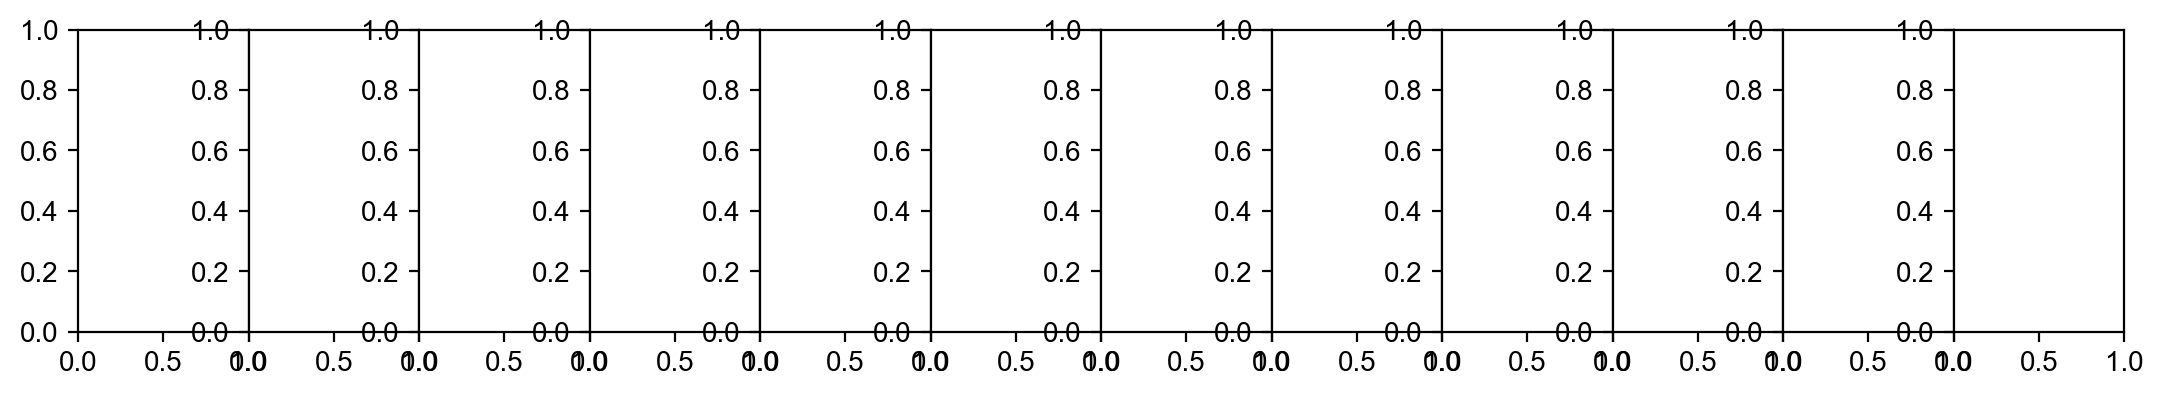

In [329]:
nrows = 1
ncols = 2*len(gep_list + ['All'])
width = 2.2*len(gep_list + ['All'])
height = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                         dpi = 200, gridspec_kw = {'wspace' : 0})


In [330]:
g

'Treg'

In [331]:
dat_all = gep_dat[g]


In [384]:
dat = dat_all[(dat_all['Bin_%s' % g]==True) &
             (dat_all['Bin_Cytotoxic']==True)]


In [385]:
dat.index = dat['sample']

In [380]:
len(sample_order)

138

In [381]:
dat.loc[sample_order, :].dropna()

,sample,Bin_Cytotoxic,Bin_Treg,Th1-Like,Treg,Th2-Resting,Th17-Resting,Th22,Th2-Activated,Th17-Activated,...,Bin_Th2-Resting,Bin_Th17-Resting,Bin_Th22,Bin_Th2-Activated,Bin_Th17-Activated,CD8-EM,TEMRA,Bin_CD8-EM,Bin_TEMRA,Ncell
sample,,,,,,,,,,,,,,,,,,,,,
S00082-Ja001,S00082-Ja001,False,False,0.025075,0.018322,0.044043,0.030067,0.036555,0.010257,0.004419,...,211,141,172,30,16,0.038631,0.019652,173,64,1779
N00013-Ja005,N00013-Ja005,False,False,0.038241,0.012815,0.032483,0.024799,0.029128,0.006784,0.006807,...,44,34,56,10,9,0.081574,0.026229,193,50,812
S00045-Ja005,S00045-Ja005,False,False,0.050727,0.017055,0.046057,0.047564,0.037104,0.005185,0.009559,...,109,162,108,5,23,0.062910,0.025531,199,53,1090
U00505-Ua005,U00505-Ua005,False,False,0.049024,0.013290,0.034225,0.049254,0.023672,0.006303,0.005215,...,91,225,68,11,13,0.025978,0.009184,99,13,1580
H00052-Ha001,H00052-Ha001,False,False,0.044968,0.011725,0.035645,0.031393,0.022437,0.006411,0.005215,...,235,251,181,25,17,0.029293,0.016946,248,77,3381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U00613-Ua005,U00613-Ua005,False,False,0.011429,0.014577,0.123657,0.024819,0.033076,0.004706,0.021774,...,79,21,26,1,9,0.034557,0.038119,37,37,283
N00017-Ja003,N00017-Ja003,False,False,0.015656,0.011044,0.013793,0.017262,0.011100,0.003632,0.006832,...,6,12,5,0,4,0.025852,0.030610,22,16,294
U00601-Ua005,U00601-Ua005,False,False,0.024766,0.014012,0.027896,0.027055,0.029622,0.007973,0.012971,...,7,15,14,2,5,0.032104,0.015768,28,6,286


In [363]:
ms_all

['GZMK',
 'CXCR3',
 'AB_CD8',
 'AB_CD45RO',
 'CXCR3',
 'IFNG',
 'TBX21',
 'AB_CD195',
 'FCGR3A',
 'KLRF1',
 'NCR1',
 'PRF1',
 'AB_CD45RA',
 'CCR6',
 'RORC',
 'AQP3',
 'PDE4D',
 'PTPN13',
 'FOXP3',
 'IL2RA',
 'CTLA4',
 'AB_CD25',
 'AB_CD39']

In [387]:
dat.loc[sample_order, ms_all]

,GZMK,CXCR3,AB_CD8,AB_CD45RO,CXCR3,IFNG,TBX21,AB_CD195,FCGR3A,KLRF1,...,CCR6,RORC,AQP3,PDE4D,PTPN13,FOXP3,IL2RA,CTLA4,AB_CD25,AB_CD39
sample,,,,,,,,,,,,,,,,,,,,,
S00082-Ja001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N00013-Ja005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S00045-Ja005,0.0,0.0,300.317627,92.405426,0.0,0.0,0.0,17.326017,14.180374,5.67215,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.539703,8.663009
U00505-Ua005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H00052-Ha001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U00613-Ua005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N00017-Ja003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U00601-Ua005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [425]:
g, b

('All', False)

In [446]:
for i, b in enumerate([True, False]):

    for j, g in enumerate(gep_list + ['All']):
        print(i*len(gep_list + ['All']) + j)


0
1
2
3
4
5
6
7
8
9
10
11


In [427]:
len(gep_list + ['All'])

6

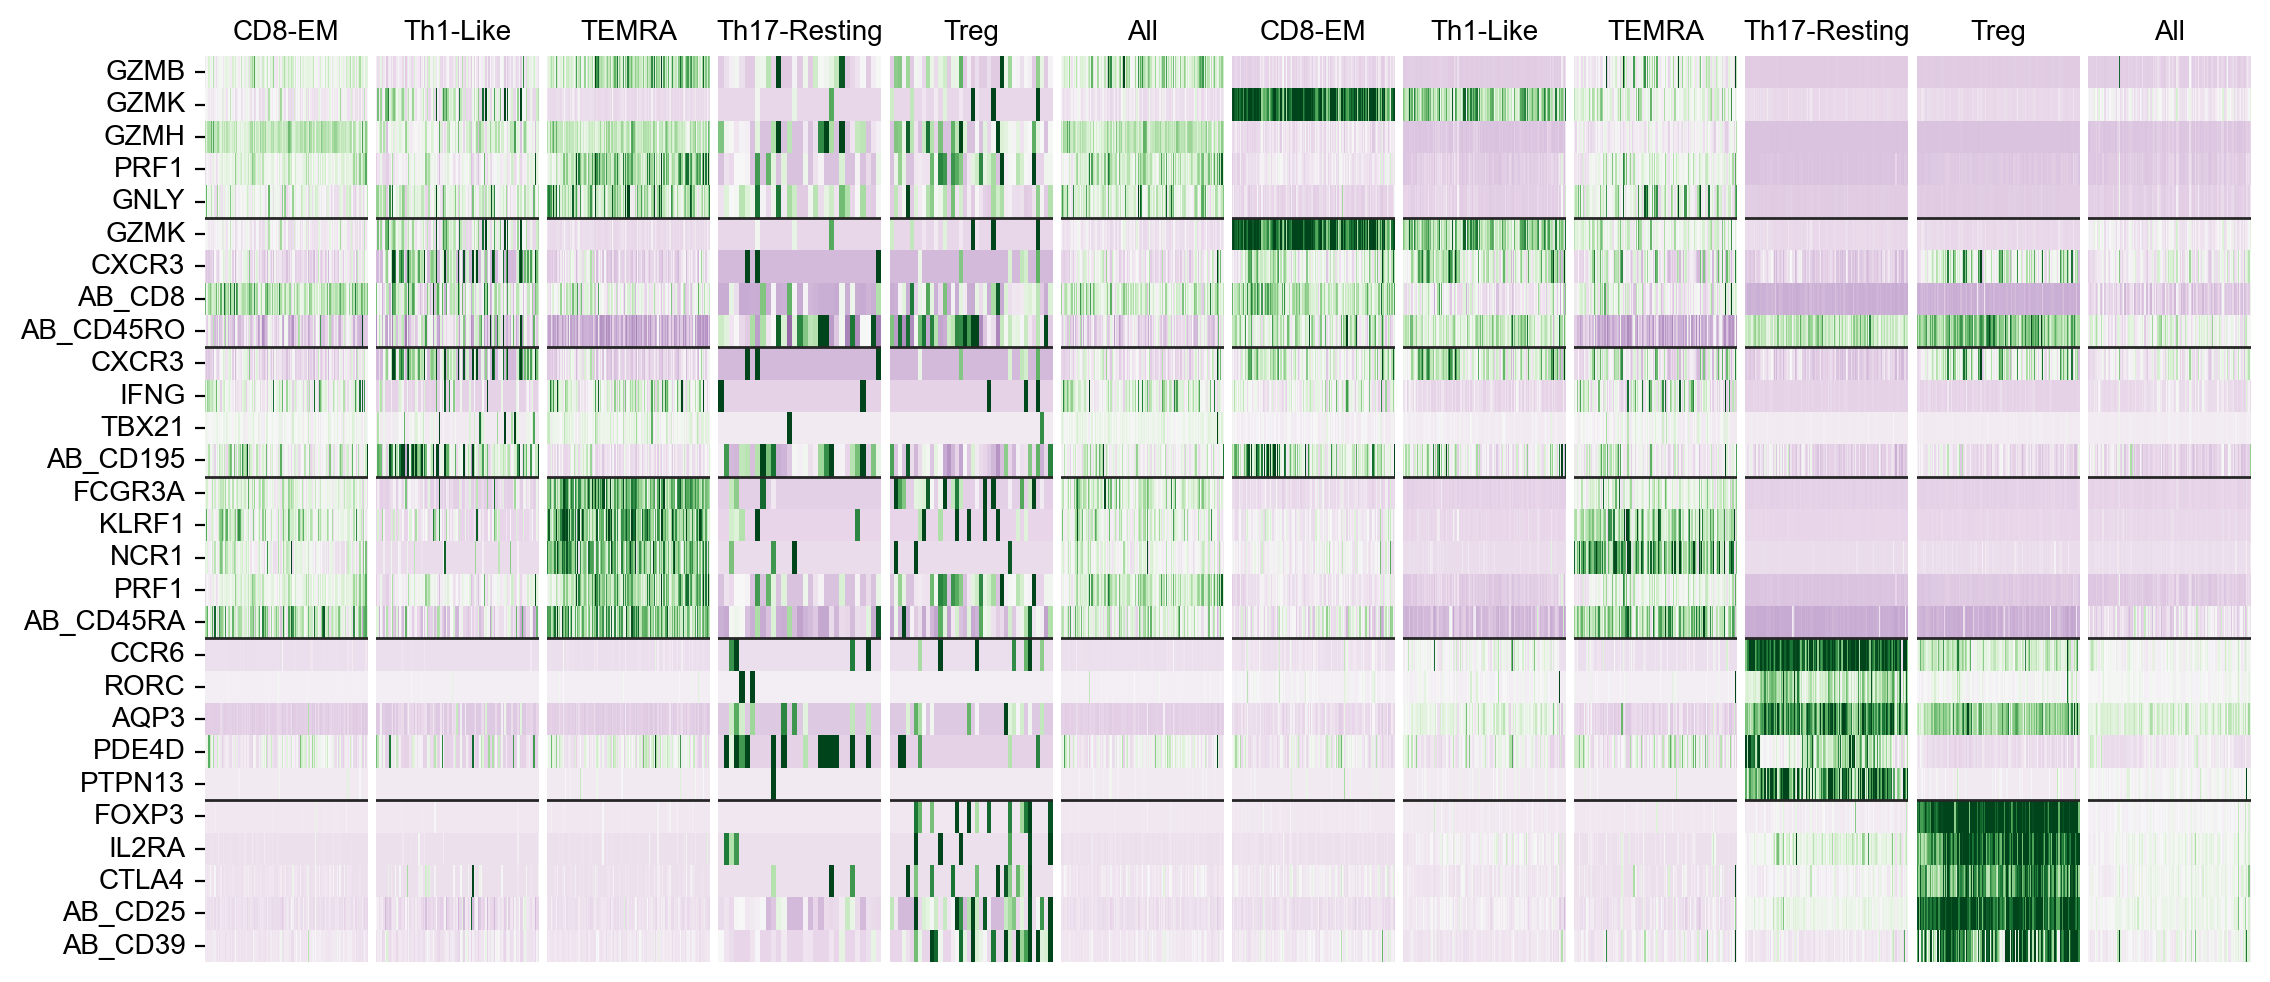

In [471]:
nrows = 1
ncols = 2*len(gep_list + ['All'])
width = 2.2*len(gep_list + ['All'])
height = 6
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                         dpi = 200, gridspec_kw = {'wspace' : 0.05})



# High/Low Cytotoxic
for i, b in enumerate([True, False]):

    for j, g in enumerate(gep_list + ['All']):
        ax = axes[i*len(gep_list + ['All']) + j]
        dat_all = gep_dat[g]
        if g!= 'All':
            dat = dat_all[(dat_all['Bin_%s' % g]==True) & (dat_all['Bin_Cytotoxic']==b)]
        else:
            dat = dat_all[(dat_all['Bin_Cytotoxic']==b)]
            
        dat = dat.dropna()
        # dat.index = dat['sample']
        
        
        sns.heatmap(dat.loc[:, ms_all].T, cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                    ax = ax)
        
        ax.set_xticks([])
        ax.set_title(g, fontsize = 10)
        
#         # ax.set_title(label_map[b] % g, fontsize = label_fontsize)
#         ax.set_title({True: 'cGEP High', False: 'cGEP Low'}[b], y = 1, fontsize = tick_fontsize)
        
#         if i == 0:
#             if g != 'Th1-Like':
#                 gname = g
#             else:
#                 gname = 'Th1-Like (Cytotoxic Unfilt.)'
#             ax.text(1, 1.15, s = gname, transform=ax.transAxes, ha = 'center', fontsize = label_fontsize)

#         ax.set_yticks([])
#         ax.set_xticks([])
#         # ax.set_xticks(np.arange(0.5, len(ms)), ms)
#         ax.tick_params('y', labelsize = tick_fontsize)
#         ax.set_xlabel('Samples', fontsize = tick_fontsize)

        if (j!=0) or (i!=0):
            ax.set_yticks([])
#             ax.set_ylabel('Markers', fontsize = label_fontsize)
#             ax.set_yticks(np.arange(0.5, len(ms_all)), ms_all)
#             # ax.collections[0].colorbar.remove()
            
#         elif i==0:
#             ax.axvline(0, 0, dat.shape[0], color = '#262626', linewidth = 2)

#         else:
#             ax.axvline(0, 0, dat.shape[0], color = '#262626', linewidth = 2)
            
        ax.axhline(5, 0, 10, color = '#262626', linewidth = 1)
        ax.axhline(9, 0, 10, color = '#262626', linewidth = 1)
        ax.axhline(13, 0, 10, color = '#262626', linewidth = 1)
        ax.axhline(18, 0, 10, color = '#262626', linewidth = 1)
        ax.axhline(23, 0, 10, color = '#262626', linewidth = 1)
      

# cax = ax.inset_axes([1.1, 0, .3, 1], transform=ax.transAxes)
# cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
#                             cmap=sns.color_palette("PRGn", as_cmap=True)),
#              ax=ax, cax=cax, orientation='vertical')
# cbar.outline.set_linewidth(0) 
# cax.set_xticks([vmin, vmax])
# cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
#                      '%.1f' % vmax])
# cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-1)
# cax.tick_params(labelsize=tick_fontsize-1)

# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers_AllGenes.Sparks.png'), bbox_inches="tight")
# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers_AllGenes.Sparks.pdf'), bbox_inches="tight")

In [469]:
cs = 5
for g in gep_list:
    s = len(ms_rna_dict[g])
    if g in ms_adt_dict.keys():
        s += len(ms_adt_dict[g])
    cs += s
    print(s, cs)

4 9
4 13
5 18
5 23
5 28


/PHShome/mc1070/anaconda3/envs/cnmf_env2v2/lib/python3.7/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


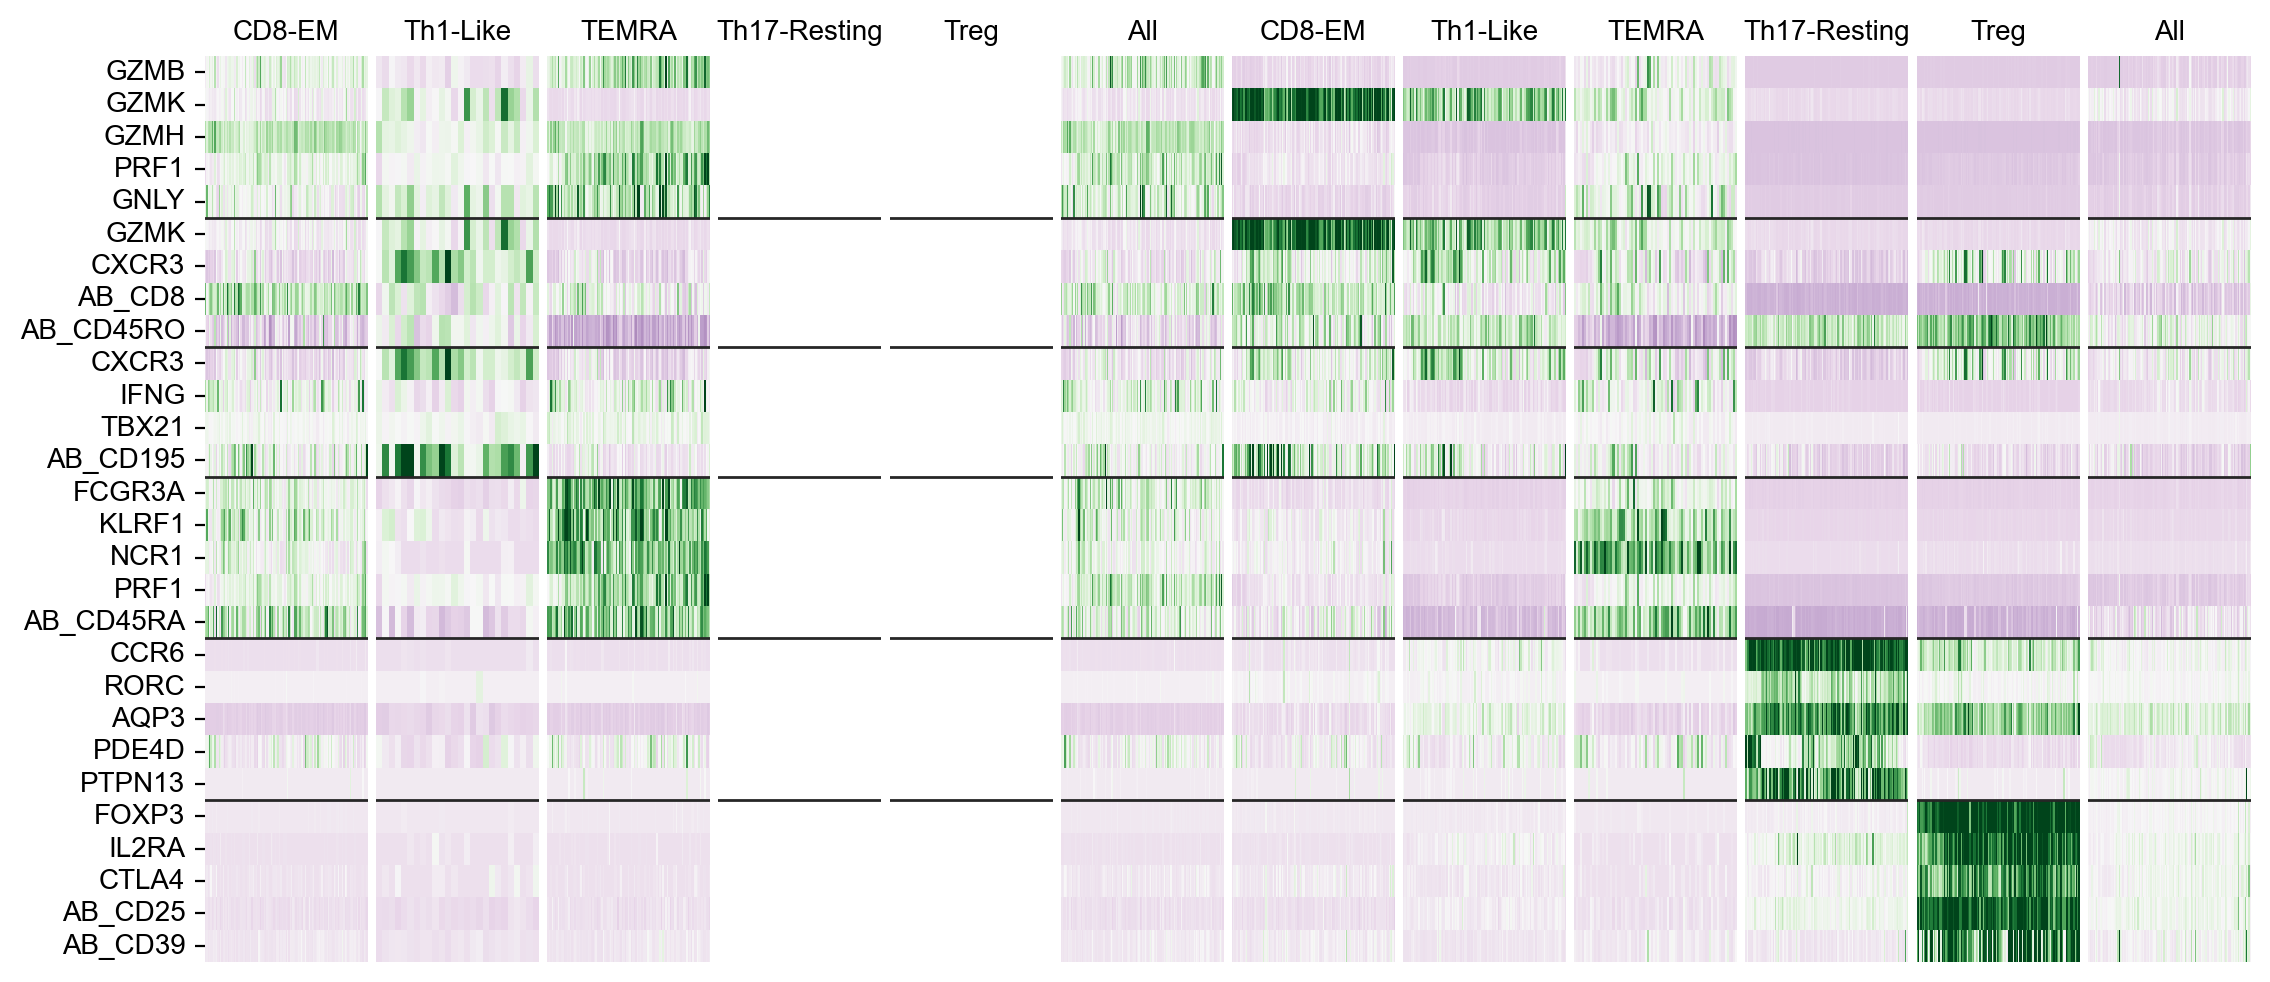

In [496]:
nrows = 1
ncols = 2*len(gep_list + ['All'])
width = 2.2*len(gep_list + ['All'])
height = 6
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                         dpi = 200, gridspec_kw = {'wspace' : 0.05})



# High/Low Cytotoxic
for i, b in enumerate([True, False]):

    for j, g in enumerate(gep_list + ['All']):
        ax = axes[i*len(gep_list + ['All']) + j]
        dat_all = gep_dat[g]
        if g!= 'All':
            dat = dat_all[(dat_all['Bin_%s' % g]==True) & (dat_all['Bin_Cytotoxic']==b)]
        else:
            dat = dat_all[(dat_all['Bin_Cytotoxic']==b)]
            
        dat = dat.dropna()
        dat = dat[dat['Ncell']>20]
        # dat.index = dat['sample']
        
        
        sns.heatmap(dat.loc[:, ms_all].T, cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                    ax = ax)
        
        ax.set_xticks([])
        ax.set_title(g, fontsize = 10)
        
#         # ax.set_title(label_map[b] % g, fontsize = label_fontsize)
#         ax.set_title({True: 'cGEP High', False: 'cGEP Low'}[b], y = 1, fontsize = tick_fontsize)
        
#         if i == 0:
#             if g != 'Th1-Like':
#                 gname = g
#             else:
#                 gname = 'Th1-Like (Cytotoxic Unfilt.)'
#             ax.text(1, 1.15, s = gname, transform=ax.transAxes, ha = 'center', fontsize = label_fontsize)

#         ax.set_yticks([])
#         ax.set_xticks([])
#         # ax.set_xticks(np.arange(0.5, len(ms)), ms)
#         ax.tick_params('y', labelsize = tick_fontsize)
#         ax.set_xlabel('Samples', fontsize = tick_fontsize)

        if (j!=0) or (i!=0):
            ax.set_yticks([])
#             ax.set_ylabel('Markers', fontsize = label_fontsize)
#             ax.set_yticks(np.arange(0.5, len(ms_all)), ms_all)
#             # ax.collections[0].colorbar.remove()
            
#         elif i==0:
#             ax.axvline(0, 0, dat.shape[0], color = '#262626', linewidth = 2)

#         else:
#             ax.axvline(0, 0, dat.shape[0], color = '#262626', linewidth = 2)
            
        ax.axhline(5, 0, 10, color = '#262626', linewidth = 1)
        ax.axhline(9, 0, 10, color = '#262626', linewidth = 1)
        ax.axhline(13, 0, 10, color = '#262626', linewidth = 1)
        ax.axhline(18, 0, 10, color = '#262626', linewidth = 1)
        ax.axhline(23, 0, 10, color = '#262626', linewidth = 1)
      

# cax = ax.inset_axes([1.1, 0, .3, 1], transform=ax.transAxes)
# cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
#                             cmap=sns.color_palette("PRGn", as_cmap=True)),
#              ax=ax, cax=cax, orientation='vertical')
# cbar.outline.set_linewidth(0) 
# cax.set_xticks([vmin, vmax])
# cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
#                      '%.1f' % vmax])
# cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-1)
# cax.tick_params(labelsize=tick_fontsize-1)

# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers_AllGenes.Sparks.png'), bbox_inches="tight")
# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers_AllGenes.Sparks.pdf'), bbox_inches="tight")

In [ ]:
g = 'Treg'

b = True
dat_all = gep_dat[g]
if g!= 'All':
    dat = dat_all[(dat_all['Bin_%s' % g]==True) & (dat_all['Bin_Cytotoxic']==b)]


In [499]:
dat.dropna()

,sample,Bin_Cytotoxic,Bin_Treg,Th1-Like,Treg,Th2-Resting,Th17-Resting,Th22,Th2-Activated,Th17-Activated,...,Bin_Th2-Resting,Bin_Th17-Resting,Bin_Th22,Bin_Th2-Activated,Bin_Th17-Activated,CD8-EM,TEMRA,Bin_CD8-EM,Bin_TEMRA,Ncell
7,G05064-Ja005,True,True,0.045817,0.128706,5.226423e-04,0.001171,2.223535e-04,0.001161,0.000512,...,0,0,0,0,0,0.212378,0.024757,1,0,1
11,G05073-Ja005,True,True,0.001443,0.110319,1.507763e-05,0.000006,2.159845e-05,0.000048,0.000029,...,0,0,0,0,0,0.010150,0.283154,0,2,2
19,G05078-Ja005,True,True,0.001839,0.107026,1.600462e-03,0.001117,1.980331e-03,0.001237,0.000492,...,0,0,0,0,0,0.056133,0.120483,0,1,2
27,G05105-Ja005,True,True,0.002928,0.134178,6.436693e-04,0.002299,2.907705e-04,0.000155,0.000085,...,0,0,0,0,0,0.129772,0.337538,1,1,1
31,G05112-Ja005,True,True,0.011199,0.114316,1.696888e-03,0.019466,4.522991e-03,0.001836,0.002571,...,0,0,0,0,0,0.026458,0.009279,0,0,2
39,G05153-Ja005,True,True,0.004895,0.116215,7.209262e-04,0.051625,2.327483e-03,0.000618,0.000553,...,0,0,0,0,0,0.123570,0.017177,1,0,1
51,H00049-Ha001,True,True,0.007077,0.258214,7.279490e-03,0.003022,2.861922e-02,0.001135,0.000987,...,0,0,0,0,0,0.121578,0.200158,1,2,2
63,H00054-Ha001,True,True,0.006379,0.191003,2.991129e-03,0.002247,4.400210e-03,0.029534,0.003219,...,0,0,0,0,0,0.098736,0.067814,1,1,2
75,H00067-Ha001,True,True,0.026321,0.142608,5.903452e-03,0.001729,1.377594e-02,0.002793,0.000874,...,0,0,0,0,0,0.126734,0.105812,2,1,3
79,H00070-Ha001,True,True,0.004355,0.107069,6.309450e-03,0.003140,4.495485e-03,0.001161,0.001695,...,0,0,0,0,0,0.019191,0.121079,0,1,1


In [491]:
i = True
g = 'Treg'

In [476]:
dat[dat['Ncell']>20]

,sample,Bin_Cytotoxic,Th1-Like,Treg,Th2-Resting,Th17-Resting,Th22,Th2-Activated,Th17-Activated,Cytotoxic,...,Bin_Th2-Resting,Bin_Th17-Resting,Bin_Th22,Bin_Th2-Activated,Bin_Th17-Activated,CD8-EM,TEMRA,Bin_CD8-EM,Bin_TEMRA,Ncell
0,G05061-Ja005,False,0.023997,0.036647,0.023569,0.023638,0.017666,0.006258,0.003318,0.009925,...,110,136,118,16,12,0.028617,0.013589,226,61,2952
2,G05064-Ja005,False,0.025696,0.024259,0.038412,0.020697,0.017399,0.005782,0.002293,0.006646,...,351,161,181,37,26,0.014852,0.007224,164,47,5732
4,G05073-Ja005,False,0.032439,0.022632,0.023856,0.046605,0.022133,0.005217,0.004382,0.009492,...,155,729,191,29,49,0.024164,0.013579,262,108,4693
6,G05077-Ja005,False,0.022011,0.038727,0.028517,0.038795,0.024349,0.008606,0.004062,0.009325,...,115,234,105,22,11,0.029384,0.008342,149,20,2102
8,G05078-Ja005,False,0.022169,0.017998,0.019119,0.031679,0.011736,0.005249,0.003034,0.007268,...,130,523,105,20,26,0.021768,0.008451,247,56,5293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,U00607-Ua005,False,0.021182,0.065093,0.032499,0.041187,0.038443,0.004214,0.010648,0.009572,...,6,14,13,0,1,0.023907,0.007890,6,1,121
268,U00613-Ua005,False,0.011476,0.023078,0.118610,0.024678,0.033978,0.004614,0.021180,0.015117,...,80,21,27,1,9,0.033044,0.036276,37,37,299
270,U00617-Ua005,False,0.025210,0.021038,0.033921,0.029902,0.017447,0.006044,0.006112,0.010879,...,31,52,10,3,5,0.015438,0.008185,15,3,588
272,U00619-Ua005,False,0.012078,0.087648,0.019020,0.016201,0.027951,0.005483,0.007386,0.007497,...,29,27,67,7,13,0.017182,0.006296,30,3,896


In [465]:
gep_list

['CD8-EM', 'Th1-Like', 'TEMRA', 'Th17-Resting', 'Treg']

In [463]:
ms_rna_dict

{'Th1-Like': ['CXCR3', 'IFNG', 'TBX21'],
 'Th2-Resting': ['GATA3', 'CCR4', 'PTGDR2'],
 'Th17-Resting': ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
 'Treg': ['FOXP3', 'IL2RA', 'CTLA4'],
 'Cytotoxic': ['GZMB', 'GZMK', 'GZMH', 'PRF1', 'GNLY'],
 'TEMRA': ['FCGR3A', 'KLRF1', 'NCR1', 'PRF1'],
 'CD8-EM': ['GZMK', 'CXCR3']}

In [464]:
ms_adt_dict

{'Th1-Like': ['AB_CD195'],
 'Th2-Resting': ['AB_CD194'],
 'Th2-Activated': ['AB_CD194'],
 'Treg': ['AB_CD25', 'AB_CD39'],
 'TEMRA': ['AB_CD45RA'],
 'CD8-EM': ['AB_CD8', 'AB_CD45RO']}

In [451]:
dat['Bin_Cytotoxic']

0      False
2      False
4      False
6      False
8      False
       ...  
266    False
268    False
270    False
272    False
274    False
Name: Bin_Cytotoxic, Length: 138, dtype: bool

In [448]:
g

'All'

In [449]:
b

False

In [416]:
ms_all

['GZMK',
 'CXCR3',
 'AB_CD8',
 'AB_CD45RO',
 'CXCR3',
 'IFNG',
 'TBX21',
 'AB_CD195',
 'FCGR3A',
 'KLRF1',
 'NCR1',
 'PRF1',
 'AB_CD45RA',
 'CCR6',
 'RORC',
 'AQP3',
 'PDE4D',
 'PTPN13',
 'FOXP3',
 'IL2RA',
 'CTLA4',
 'AB_CD25',
 'AB_CD39']

In [412]:
dat.loc[sample_order, ms_all]

,GZMK,CXCR3,AB_CD8,AB_CD45RO,CXCR3,IFNG,TBX21,AB_CD195,FCGR3A,KLRF1,...,CCR6,RORC,AQP3,PDE4D,PTPN13,FOXP3,IL2RA,CTLA4,AB_CD25,AB_CD39
sample,,,,,,,,,,,,,,,,,,,,,
S00082-Ja001,0.508292,0.140811,150.530380,106.989540,0.140811,0.432735,0.151114,27.327814,2.359437,0.865470,...,0.003434,0.000000,0.157983,1.002846,0.0,0.003434,0.017172,0.140811,8.520179,4.595786
N00013-Ja005,3.068481,0.783343,661.196716,90.296143,0.783343,0.273475,0.129785,62.216656,1.946771,1.719647,...,0.000000,0.009270,0.259569,0.245664,0.0,0.009270,0.004635,0.037081,5.107187,4.457912
S00045-Ja005,0.551641,0.713456,448.783508,110.257271,0.713456,0.467056,0.224334,34.563843,3.817357,0.901014,...,0.007355,0.000000,0.165492,0.257433,0.0,0.000000,0.007355,0.088263,5.165629,5.420919
U00505-Ua005,0.314651,1.533923,409.645905,87.345192,1.533923,0.196657,0.235988,30.481424,2.438545,1.101278,...,0.000000,0.000000,0.117994,0.353982,0.0,0.000000,0.000000,0.000000,5.668934,3.096110
H00052-Ha001,2.485911,0.983437,483.154388,107.705231,0.983437,0.327812,0.300495,31.344269,6.692837,2.458593,...,0.136589,0.027318,0.655625,0.464401,0.0,0.054635,0.000000,0.081953,6.169643,3.937411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U00613-Ua005,0.572277,0.572277,297.124207,136.174271,0.572277,0.480713,0.251802,35.511757,3.868596,1.762615,...,0.000000,0.000000,0.137347,0.091564,0.0,0.000000,0.000000,0.137347,5.299235,5.482758
N00017-Ja003,0.770167,0.539117,342.424438,135.131119,0.539117,0.154033,0.308067,24.218819,3.388734,1.925417,...,0.000000,0.000000,0.231050,0.462100,0.0,0.000000,0.077017,0.077017,6.524253,8.699004
U00601-Ua005,1.617748,0.568398,470.101929,135.197113,0.568398,0.131169,0.218615,27.332930,2.361038,0.787013,...,0.000000,0.000000,0.262338,0.612121,0.0,0.000000,0.000000,0.087446,5.870159,4.891799


In [411]:
g

'All'

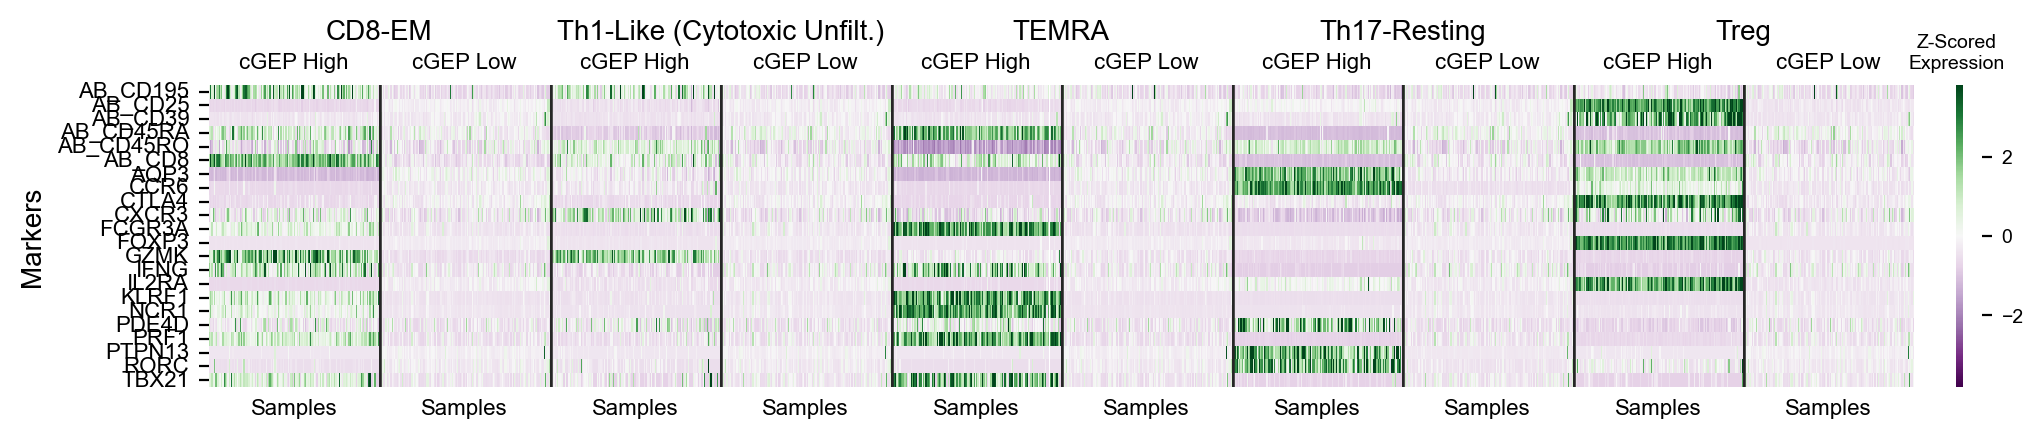

In [285]:
nrows = 1
ncols = 2*len(gep_list)
width = 2.2*len(gep_list)
height = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                         dpi = 200, gridspec_kw = {'wspace' : 0})

for j, g in enumerate(gep_list):
    # High/Low polarizations
    for i, b in enumerate([True, False]):
        ax = axes[2*j + i]
        dat_all = gep_dat[g]
        dat = dat_all[dat_all['Bin_%s' % g]==b]
        dat.index = dat['sample']
        
        sns.heatmap(dat.loc[sample_order, ms_all].T, cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                    ax = ax)
        # ax.set_title(label_map[b] % g, fontsize = label_fontsize)
        ax.set_title({True: 'cGEP High', False: 'cGEP Low'}[b], y = 1, fontsize = tick_fontsize)
        
        if i == 0:
            if g != 'Th1-Like':
                gname = g
            else:
                gname = 'Th1-Like (Cytotoxic Unfilt.)'
            ax.text(1, 1.15, s = gname, transform=ax.transAxes, ha = 'center', fontsize = label_fontsize)

        ax.set_yticks([])
        ax.set_xticks([])
        # ax.set_xticks(np.arange(0.5, len(ms)), ms)
        ax.tick_params('y', labelsize = tick_fontsize)
        ax.set_xlabel('Samples', fontsize = tick_fontsize)

        if (j==0) & (i==0):
            ax.set_ylabel('Markers', fontsize = label_fontsize)
            ax.set_yticks(np.arange(0.5, len(ms_all)), ms_all)
            # ax.collections[0].colorbar.remove()
            
        elif i==0:
            ax.axvline(0, 0, dat.shape[0], color = '#262626', linewidth = 2)

        else:
            ax.axvline(0, 0, dat.shape[0], color = '#262626', linewidth = 2)
            
#         ax.axhline(4, 0, 10, color = '#262626', linewidth = 1)
#         ax.axhline(9, 0, 10, color = '#262626', linewidth = 1)
        

cax = ax.inset_axes([1.1, 0, .3, 1], transform=ax.transAxes)
cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
                            cmap=sns.color_palette("PRGn", as_cmap=True)),
             ax=ax, cax=cax, orientation='vertical')
cbar.outline.set_linewidth(0) 
cax.set_xticks([vmin, vmax])
cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
                     '%.1f' % vmax])
cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-1)
cax.tick_params(labelsize=tick_fontsize-1)

# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers_AllGenes.Sparks.png'), bbox_inches="tight")
# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers_AllGenes.Sparks.pdf'), bbox_inches="tight")